# Naive Bayes decoder for position decoding based on DLC tracking

Here we will use scikit-learn Naive Bayes decoder in order to decode animals positions from calcium neural traces using as labels DLC tracking information.


In [1]:
#import useful libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pickle
import configuration
import general_statistics as stats
import figures as figs
import matplotlib.cm as cm
from matplotlib import colors
from scipy import signal
from scipy import stats as sstats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import scipy
cmap = cm.jet
import math
from sklearn.datasets import load_iris
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import cross_val_score
import random
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")

In [2]:
from scipy.ndimage import gaussian_filter
BINS = 70

def occupancy_map(tracking = None, binnumber = BINS):
    
    x = np.array([int(tracking[0,i]) for i in range(tracking.shape[1])])
    y = np.array([int(tracking[1,i]) for i in range(tracking.shape[1])])
    xpos = x[np.logical_and(x>0,y>0)]
    ypos = y[np.logical_and(x>0,y>0)]
    
    occupancy = np.zeros((binnumber,binnumber))
    xdenom = int(np.max(xpos)/binnumber+1)
    ydenom = int(np.max(ypos)/binnumber+1)
    data_points = 0
    for x,y in zip(xpos,ypos):
        if x>0 and y>0:
            x1 = int(x/xdenom)
            y1 = int(y/ydenom)
            occupancy [x1,y1]= occupancy[x1,y1] + 1
            data_points+=1
    occupancy = occupancy/data_points
    return occupancy

def binned_tracking(tracking = None, binnumber = 70):
    
    x = np.array([int(tracking[0,i]) for i in range(tracking.shape[1])])
    y = np.array([int(tracking[1,i]) for i in range(tracking.shape[1])])
    
    xpos = x[np.logical_and(x>0,y>0)]
    ypos = y[np.logical_and(x>0,y>0)]
    
    xdenom = int(np.max(xpos)/binnumber+1)
    ydenom = int(np.max(ypos)/binnumber+1)
    
    xnew = [int(xpos[i]/xdenom) for i in range(len(xpos))]
    ynew = [int(ypos[i]/xdenom) for i in range(len(xpos))]
    
    return xnew,ynew

def neuron_activity_map(activity= None,tracking = None,binnumber = 70, neuronID = 0):
     
    x = np.array([int(tracking[0,i]) for i in range(tracking.shape[1])])
    y = np.array([int(tracking[1,i]) for i in range(tracking.shape[1])])
    xpos = x[np.logical_and(x>0,y>0)]
    ypos = y[np.logical_and(x>0,y>0)]
    
    act_map = np.zeros((binnumber,binnumber))
    xdenom = int(np.max(xpos)/binnumber+1)
    ydenom = int(np.max(ypos)/binnumber+1)
    counter = 0
    for x,y in zip(xpos,ypos):
        if x>0 and y>0:
            x1 = int(x/xdenom)
            y1 = int(y/ydenom)
            act_map[x1,y1]+=np.mean(activity[neuronID,counter])
            counter+=1
        
    act_map = act_map/counter
    return act_map

def mean_activity_map(activity= None,tracking = None,binnumber = BINS):
    
    x = np.array([int(tracking[0,i]) for i in range(tracking.shape[1])])
    y = np.array([int(tracking[1,i]) for i in range(tracking.shape[1])])
    xpos = x[np.logical_and(x>0,y>0)]
    ypos = y[np.logical_and(x>0,y>0)]
    act_map = np.zeros((binnumber,binnumber))
    xdenom = int(np.max(xpos)/binnumber+1)
    ydenom = int(np.max(ypos)/binnumber+1)
    counter = 0
    for x,y in zip(xpos,ypos):
        if x>0 and y>0:
            x1 = int(x/xdenom)
            y1 = int(y/ydenom)
            act_map[x1,y1]+=np.mean(activity[:,counter])
            counter+=1
        
    act_map = act_map/counter
    return act_map

def speed_selection(tracking = None, speed_limit = 3):
    
    x = tracking[0,:]
    y = tracking[1,:]
    vx = np.diff(x)
    vy = np.diff(y)
    speed = np.sqrt(vx*vx+vy*vy)
    index = np.where(speed > speed_limit)[0]
    
    return index

def poisson_pdf(n,l):
    return pow(l,n)*exp(-l)/math.factorial(n)

In [3]:
# define mouse information, and preprocessin versions from analysis.
# load data for all sessions in this mouse and compute mean activity for each neuron.

mouse = 411857        ### mouse number id
decoding_v = 1            ## decoding version, normaly equal to one
motion_correction_v = 20  ### 100 means everything was aligned, 200 means it was also equalized, 20 is for day wise
alignment_v = 3           ## alignment version, version 3 is for day wise
equalization_v = 0        ## equalization version
source_extraction_v = 1   ## source extraction version
component_evaluation_v = 1 ## component evaluation version

# here we will do analysis with no registration
# registration_v = 2        ## registration version
sf = 10                   ## sampling frequency of the original signal 
re_sf= 1                 ## value of resampling
session_now = 1
period = int(5 * sf / re_sf)
period_resting = period *50
fixed = 'None'
## define task for plotting. This will cahnge for other mice!!!!

if mouse == 411857:
    sessions = [1,2,3]
    if session_now == 1:
        task = 'STABLE'
        colapse_behaviour = 2
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
    if session_now == 2:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]   
    if session_now == 3:
        task = 'OVERLAPPING'
        fixed = 'LL'
        object_fixed = 3
        colapse_behaviour = 1
        labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]   

if mouse == 56165 or mouse == 32364:
    if mouse == 56165:
        sessions = [1,2,4]       ## sessions for this particular mouse
    if mouse == 32364:
        sessions = [1,2]
    if session_now == 1:
        task = 'OVERLAPPING'
        colapse_behaviour = 1
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
        if mouse == 32364:
            fixed = 'LR'
            object_fixed = 4
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]   
        if mouse == 56165:
            fixed = 'UR'
            object_fixed = 5
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]   

    else:
        if session_now == 2:
            task = 'STABLE'
            colapse_behaviour = 2
            labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
        else:
            task = 'RANDOM'
            colapse_behaviour = 0
            labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32365:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 2:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
    else:
        if session_now == 3:
            task = 'OVERLAPPING'
            fixed = 'LR'
            object_fixed = 4
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]           
            
if mouse == 56166:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]

    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UR'
            object_fixed = 5
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32366:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 3:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32363:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UL'
            object_fixed = 6
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]

In [4]:
file_directory = os.environ['PROJECT_DIR'] + 'neural_analysis/data/calcium_activity_day_wise/'
timeline_file_dir = os.environ['PROJECT_DIR'] + 'neural_analysis/data/timeline/'
behaviour_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
behaviour_dir_parameters = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram_parameters/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
tracking_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/center_of_mass/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
objects_dir= os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/object_positions/'
figure_path = os.environ['PROJECT_DIR'] +'neural_analysis/figures/trial_aligned_events/'

In [5]:
# define all relevant files names and load them into a list
session = session_now

activity_list = []
timeline_list = []
behaviour_list = []
behaviour_list_copy = []
behaviour_list_unsup = []
parameters_list = []
tracking_list = []
total_time = 0
day = 0
print('LOADING TRIALS ACTIVITY AND CREATING LIST OF ACTIVITY, TRACKING AND BEHAVIOUR')
for trial in [1,6,11,16]:

    beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75_ethogram.npy'
    ## LOAD BEHAVIOUR
    behaviour = np.load(behaviour_dir + beh_file_name_1)
    reshape_behaviour = np.reshape(behaviour[:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
    resample_beh1 = np.reshape(scipy.stats.mode(reshape_behaviour,axis=1)[0],reshape_behaviour.shape[0])

    beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75_parameters.npy'
    ## LOAD PARAMETRS FOR BEHAVIOUR CLASSIFICATION
    parameters = np.load(behaviour_dir_parameters + beh_file_name_1)
    params = []
    for param in range(parameters.shape[0]):
        r1_params = np.reshape(parameters[param,:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
        r2_params = np.reshape(scipy.stats.mode(r1_params,axis=1)[0],reshape_behaviour.shape[0])
        params.append(r2_params)
    resample_params = np.array(params)
        
    ## LOAD TRACKING
    tracking_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75.npy'
    position = np.load(tracking_dir + tracking_file_name_1)
    resample_position, resample_position_stc = stats.resample_matrix(neural_activity=position.T,
                                                                                            re_sf=re_sf)
    ## LOAD TIMELINE
    time_file_session_1 =  'mouse_'+ f'{mouse}'+'_session_'+ f'{session}' +'_trial_'+ f'{trial}'+'_v1.3.1.0_10.pkl'

    timeline_file= open(timeline_file_dir + time_file_session_1,'rb')
    timeline_info = pickle.load(timeline_file)
    timeline_1 = np.zeros(len(timeline_info) + 1)
    for i in range(len(timeline_info)):
        timeline_1[i] = timeline_info[i][1]
    timeline_1[len(timeline_info)] = behaviour.shape[0]
    timeline = timeline_1/re_sf
    time_lenght = 10
    resample_timeline = timeline_1/re_sf
    timeline_list.append(resample_timeline)

    behaviour_list.append(resample_beh1)
    behaviour_list_copy.append(resample_beh1.copy())
    parameters_list.append(resample_params)
    tracking_list.append(resample_position)
    total_time = total_time + behaviour.shape[0]


    file_name_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_'+ f'{trial}'+'_v' + f'{decoding_v}' + '.4.' + f'{motion_correction_v}' + \
                            '.' + f'{alignment_v}' + '.' + f'{equalization_v}' + '.' + f'{source_extraction_v}' + '.' + \
                          f'{component_evaluation_v}' +  '.0.npy'

     ##load activity and timeline
    activity = np.load(file_directory + file_name_session_1)
    neural_activity1 = activity[1:,:]
    ## z-score neural activity
    neural_activity = neural_activity1[:,:int(int(behaviour.shape[0]/re_sf)*re_sf)]
    ##downsample neural activity
    resample_neural_activity_mean, resample_neural_activity_std = stats.resample_matrix(neural_activity=neural_activity,
                                                                                            re_sf=re_sf)

    activity_list.append(resample_neural_activity_mean)

    day = day + 1
    print(day)
    

LOADING TRIALS ACTIVITY AND CREATING LIST OF ACTIVITY, TRACKING AND BEHAVIOUR


FileNotFoundError: [Errno 2] No such file or directory: '/home/melisa/Documents/calcium_imaging_behaviour/data/ethogram/56165/session_1/mouse_56165_session_1_day_1_likelihood_0.75_ethogram.npy'

In [6]:
    ## define targets of behaviour according to protocol (random, overlapping and stable)

    id_target = [0,1,2,3,4] # 0: unlabeled, 1:resting, 2:Navigation, 3: Obj1, 4:Obj2, 5:Run1, 6:Run2
    
    print('REDIFINING BEHAVIOUR FOR DIFFERENT SESSIONS')

    if colapse_behaviour == 0 : # RANDOM
        for day in range(len(behaviour_list)):
            for trial in range(5):
                behaviour_trial = behaviour_list[day][int(timeline_list[day][2*trial]):int(timeline_list[day][2*trial+1])]
                objects = np.unique(behaviour_trial)
                selected_object = np.random.randint(len(objects)-4,len(objects)-2,1)
                index0 = np.where(behaviour_trial==objects[selected_object])[0]
                index1 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-4], behaviour_trial!=objects[selected_object]))[0]
                index2 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-3], behaviour_trial!=objects[selected_object]))[0]
                behaviour_trial[index0] = 3
                behaviour_trial[index1] = 4
                behaviour_trial[index2] = 4            

                index0 = np.where(behaviour_trial==objects[selected_object]+4)[0]
                index1 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-2], behaviour_trial!=objects[selected_object]+4))[0]
                index2 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-1], behaviour_trial!=objects[selected_object]+4))[0]
                behaviour_trial[index0] = 0
                behaviour_trial[index1] = 0
                behaviour_trial[index2] = 0 

                behaviour_list[day][int(timeline_list[day][2*trial]):int(timeline_list[day][2*trial+1])] = behaviour_trial


    if colapse_behaviour == 1 : #OVERLAPPING
        for day in range(len(behaviour_list)):
            behaviour_list[day][np.where(behaviour_list[day] == object_fixed)[0]] = 100
            behaviour_list[day][np.where(np.logical_and(behaviour_list[day]>=3, behaviour_list[day]<=6))[0]] = 4
            behaviour_list[day][np.where(behaviour_list[day] == 100)[0]] = 3        
            behaviour_list[day][np.where(behaviour_list[day] == object_fixed +4)[0]] = 0        
            behaviour_list[day][np.where(np.logical_and(behaviour_list[day]>=7, behaviour_list[day]<=10))[0]] = 0
            behaviour_list[day][np.where(behaviour_list[day] == 200)[0]] = 0


    if colapse_behaviour == 2: #STABLE
        for day in range(len(behaviour_list)):
            objects = np.unique(behaviour_list[day])
            selected_object = np.random.randint(len(objects)-4,len(objects)-2,1)
            index0 = np.where(behaviour_list[day]==objects[selected_object])[0]
            index1 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-4], behaviour_list[day]!=objects[selected_object]))
            index2 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-3], behaviour_list[day]!=objects[selected_object]))
            behaviour_list[day][index0] = 3
            behaviour_list[day][index1] = 4
            behaviour_list[day][index2] = 4      

            index0 = np.where(behaviour_list[day]==objects[selected_object]+4)[0]
            index1 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-2], behaviour_list[day]!=objects[selected_object]+4))
            index2 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-1], behaviour_list[day]!=objects[selected_object]+4))
            behaviour_list[day][index0] = 0
            behaviour_list[day][index1] = 0
            behaviour_list[day][index2] = 0  
            

REDIFINING BEHAVIOUR FOR DIFFERENT SESSIONS


In [15]:
pca = PCA()
activity_list_pca = []
variance_list = []
variance_ratio_list = []

cca_components = min(13,activity_list[day].shape[0])
cca = CCA(n_components=cca_components)
activity_list_cca = []

for day in range(len(behaviour_list)):
    ### run pca on the entire dataset
    pca.fit(activity_list[day].T)
    transformed_activity = pca.fit(activity_list[day].T).transform(activity_list[day].T)
    activity_list_pca.append(transformed_activity.T)
    variance_list.append(pca.explained_variance_/(1+np.sqrt(activity_list[day].shape[0]/activity_list[day].shape[1]))**2)
    normalized_variance = pca.explained_variance_/(1+np.sqrt(activity_list[day].shape[0]/activity_list[day].shape[1]))**2
    variance_ratio_list.append(np.cumsum(normalized_variance/sum(normalized_variance)))
    activity_list_cca.append(cca.fit(activity_list[day].T, parameters_list[day].T).transform(activity_list[day].T))
    

## Maps characterization

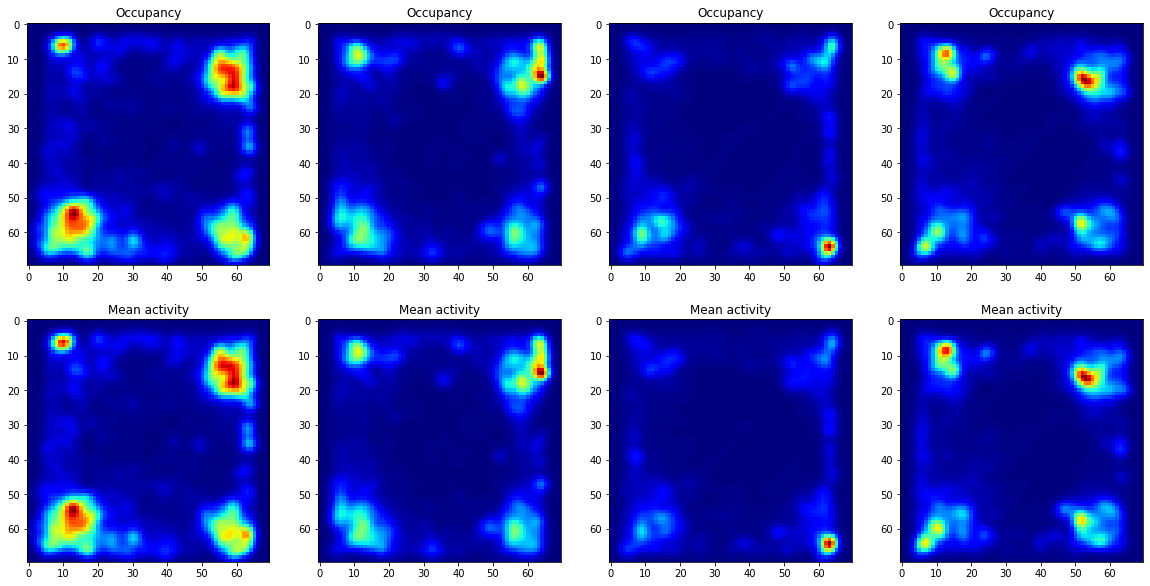

In [7]:
from scipy.ndimage import gaussian_filter
sigma = 1.5

figure = plt.figure(figsize=(20, 10))
gs = figure.add_gridspec(2, 4)

for day in range(len(behaviour_list)):
    
    occupancy = occupancy_map(tracking_list[day],binnumber = BINS)
    activity_map_variable = mean_activity_map(activity_list[day],tracking_list[day], binnumber = BINS)
    
    occupancy = gaussian_filter(occupancy, sigma)
    activity_map_variable = gaussian_filter(activity_map_variable, sigma)
    normalized_activity_map = activity_map_variable / occupancy
    normalized_activity_map =  gaussian_filter(normalized_activity_map, sigma)
    data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABH4AAAJKCAYAAABajoKYAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjQuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/MnkTPAAAACXBIWXMAAAsTAAALEwEAmpwYAAD8eElEQVR4nOz9fbglZ1XnjX9vupN0Op3k0N2kO+mOnEBiXkigkUgQMhJ5UUQUVHwb9cEZHJy5xhn9qY8gzjzqjM7oPD4jzjg//fGAguILDioyUVGChDFigg00pMkLacKJ6STdobs9SQ6dE9JJ/f44J3uve52ude6qrr13nX0+n+vqK3edVS/3rrpr1V2V9V0rVVUlAAAAAAAAAACYPp426Q4AAAAAAAAAAMBo4MMPAAAAAAAAAMCUwocfAAAAAAAAAIAphQ8/AAAAAAAAAABTCh9+AAAAAAAAAACmFD78AAAAAAAAAABMKXz4AQAAAAAAAACYUvjwM6WklH4gpXRrSul4SulQSunXU0ozk+4XAKwv8EUA0AfwRQDQB/BFMCn48DOFpJR+XNIvSfo/JZ0r6UWSninpQyml0yfZNwBYP+CLAKAP4IsAoA/gi2CS8OFnykgpnSPp5yT9m6qqPlhV1eNVVc1J+k5Js5K+L6W0IaX01pTS51NKj6SUPpFSunB5++eklD6UUjqWUjqcUnrr8t/flVL6eXOc61JKB83yXErpp1JKt6WU/jGl9FsppU3LtqenlK5PKX1x2XZ9Smm32fbGlNJ/TCn97XJ//iqltN3Yr00pfSylNJ9Sunf5S/lXL/dvg1nv21JKnx7RqQWABuCL8EUAfQBfhC8C6AP4InzRpOHDz/TxYkmbJP2x/WNVVQuS/lzSKyX9mKTvkfRqSedI+ueSjqeUzpZ0g6QPSrpA0sWSPtzg2N8r6RskPVvSV0r6d8t/f5qk39LSF+2vkPSopF9z2/5TSf9M0nmSTpf0E5KUUnqmpL+Q9N8lPUPSHkn7qqr6e0lHJX292cf3S/rtBv0FgNGBLwKAPoAvAoA+gC+CicKHn+lju6QjVVWdOIntgWX7D0r6d1VV3Vkt8emqqo5Keo2kQ1VV/T9VVS1WVfVIVVW3NDj2r1VVdW9VVcck/YKWHJeqqjpaVdUfVVV1vKqqR5ZtL3Xb/lZVVZ+rqupRSX+oJechLTmbG6qq+v3lL+NHq6rat2x7t6Tvk6SU0lYtObTfa9BfABgd+CIA6AP4IgDoA/gimCgbJ90B6JwjkranlDaexLGcv2x/iaTPn2TbC2v+Xsq9pn2Plr5IK6W0WdKvSHqVpKcv289OKW2oquqJ5eVDZtvjkrYU9Ok9km5PKZ2lpTDJv6mq6oFT6D8AdAe+CAD6AL4IAPoAvggmChE/08ffSXpM0rfZP6aUtkj6Ri2FBd6rpVA/z72SnlWz3y9J2myWd55knQtN+ysk3b/c/nFJl0q6pqqqcyR97VPdqv0VeZ9O1ldVVXWfln7vt2kphPB3CvYHAOMBXwQAfQBfBAB9AF8EE4UPP1NGVVUPaSlx2H9PKb0qpXRaSmlWS6F5B7V0471D0n9MKV2SlnhuSmmbpOslnZ9S+tGU0hkppbNTStcs73qfpFenlLamlHZK+tGTHP5fp5R2L4f0/bSk9y7//WwtaUbnl20/0+An/a6kV6SUvjOltDGltC2ltMfYf1vST0q6Sk4zCwCTA18EAH0AXwQAfQBfBJOGDz9TSFVV/0XSWyX9sqSHJd2ipa+yL6+q6jFJ/1VLTuavlu3vlHTmsrbzlZK+WUthfXdJ+rrl3f6OpE9Lmlve7imHYfm9ZdvdWgr9eyrD/NsknamlEMabtZSYrPS3/IOWEpz9uKRjWnJuzzOr/ImWEpL9SVVVx0v3CwCjB18EAH0AXwQAfQBfBJMkVVU16T7AFJBSmpP0g1VV3TCBY39e0g9N4tgA0C/wRQDQB/BFANAH8EXwFET8wJompfTtkipJfz3pvgDA+gVfBAB9AF8EAH0AX9Q/qOoFa5aU0o2SrpD0/VVVPTnh7gDAOgVfBAB9AF8EAH0AX9RPkHoBAAAAAAAAAEwppyT1Ws5IfmdK6UBK6S1ddQoAoAn4IgDoA/giAOgL+CMAsLSO+EkpbZD0OS1lGD8o6e8lfU9VVbd11z0AgBh8EQD0AXwRAPQF/BEAeE4lx88LJR2oqupuSUop/YGk10qqdSgpba6kmVM4JABMnnlV1fE06V4Y8EUA65YHjlRV9YxJ92IZfBHAuqVXvkhq6I/wRQDTQr0vOpUPP7sk3WuWD0q6xq+UUnqTpDctLZ07bALAGuXtk+6AB18EsG75uXsm3QMDvghg3dIrXyQV+CN8EcA0Uu+LRl7Vq6qqt2v5TTGlCyaYSfq0wOZPw4lg3cdH3Jeuj9XkeG3pqp8Ao6M/vmjaaOtf2vqNLvwZPmt82OvFeZfG4YvGPceAfhFd/z5d81GPU7//6JXHzvv7dI5GC/MigPXFqSR3vk/ShWZ59/LfAADGCb4IAPoAvggA+gL+CAAyTuXDz99LuiSldFFK6XRJ3y3pA910CwCgGHwRAPQBfBEA9AX8EQBktJZ6VVV1IqX0w5L+UtIGSb9ZVdVnO+sZAEAB+CIA6AP4IgDoC/gjAPCcUo6fqqr+XNKfd9SXllgN75nOdmahzWP1vY8428Om/Whhv/xpjmwWn2vo8cAW7af0eE1yZ0R9qVsvItoHrE6TW3n6tOzj80Wl95Jn1ON71LnHIh/WlraPnyZ5Gyz2GrQ9dltfN+o8a+OmyTMtyvFjn6HR827tMDpfFI37trlMmsw/LH29Nn26z0Z9jtr6wVHktGzy7Bg10bz/7GA764v8vN/a+jr2T87439Oa+KnoXK5F/7OeGLWv7cpvdDH3nq7xdipSLwAAAAAAAAAA6DF8+AEAAAAAAAAAmFLGHYPZkkjOtdW0dznbxaY9m5s2pvrDnThuFj7pjLeb9jG/oWnbfvrw0h016/l9POxsD9es54lkbU0kG6UlQUvDYH2fuwifjUJH+yQf60piV7dPf80jeYUNY/ZjLJIvrkf8tbH38jnOFl3jSNJSSpN7q02IfuQb/PjqInx7FOXc216DNnIxv88mj9Mu7vm2dHFsvw/7HN7hbHbseP8yZ9pRsZnpCrVuh7/2W2vakrTNtCN5nff/9tngt+tCIjYK1sg0tnO6SiEQzRXsfiKfWeqTR5FOwP9W63/8O8ElwXbW/9zubHM1/YIlrI/3vsjaouvvnw3R+0GpjxnFtRq3BK30npmk3L9t2oNxzJnqiMZUEz84ir6MFiJ+AAAAAAAAAACmFD78AAAAAAAAAABMKXz4AQAAAAAAAACYUtaIONpqRM9ztq8aNmeuyE3fbdqvd5tdtjhsH9yU2963edj+tWtz26LV93kdsNXp2T7PuvUuN22vQbYa+4PO9qBpe22+xefjOCewRZTm8SjNC+NLZD5c05ZiHWikGY76FfWzrT6+jiZ62M2BLSLSVdtr7s/tPaY952zTV+r91Ihyis0GNk809qJ7MsrHZJejsR7dS1Een6gsbqluv0n57uNqR6n2OzrP9h6MSv629WERXWnn685DdO2aYPfvz9Fzh83LXD9mTds/0vZfZRb+whmtn1qvvii6P20uk8udbda0/Riy84gmc4xHa9pS+7LM42Qc093S39okZ00dUdns6B6P8sFFpd6blOlum9fHYn9DNL78c9fk8dn43Nxkp/Nb3GZ7TV6sQ/4Y9l540NnWo2/y19TON3c7m33H8ePSnjv/bG3rb0rfAdrm6unrHHkUeQOjuUjpHLDJsUvnktF6ke+LxkZ0XUttEZFvjWzdjzEifgAAAAAAAAAAphQ+/AAAAAAAAAAATCk9lXr5MK5ANrXFyLt+Njd944/88aD9Vv1CZnvuE7cO2rfsuiaz/dg1/3XQ3n/oq/OdvseGVB92/bThoDb00cu5TCjkrDMtmO2O+PBtex6iUvI+DN+Wdm0SUlYavlca1nvULduQ2UiyFcltvM2G7/lzFMnjTqtpe6JzFIVaR3I7u93mwOa3M+vOOJMNY/Zhyydsn/01seeoT2Gs4yQKb7X30qyz+RBng1WT+tXsso8anTNtr8rQF0zbl8K2YdNWQuXHdqnUy/uUttLIKHx71CUzI6mSlc3MBtt5HzJn2v4aRPdSqZQ18geeumsZldf1RPe87Ysr2f4q035LbnrmS+8YtO/5/KW58S1mn+/Ln8O5/24S6j+tRPKK2dy03azrJS3zO07elpQ7GT+/OVbTlropvVxK22vfdTlgqX1f2sq5SolKrzc5Rtsy7WfWrNd2LEQ+0j9QjbzrNc70g6a93dn+wLTf5iRiWVoHL/Vaj/jrYZ+n/n3HynlTsM8qsLntNta0JWnRLnzBGa182M59o3lKJFf3jLP0utReZmSJJP2l87xI6hmtG23XxFfY8XeOs9nfZOdk0TOsKylz9P5mt/PzSi97LO1LGUT8AAAAAAAAAABMKXz4AQAAAAAAAACYUvjwAwAAAAAAAAAwpfQ0x4/HauOcJv1K0359Ju7Uv9V/G7Sv/U+fzLf722HzlT90U2Z6xbfcMGjvv9jl+Am1hJaWJXOzK+L1sPZ4ka4w0jh6fWBp6cPSksOlJZNX2y7KL2LHgP+tUR4fS6SBb1Iq0C6fZ9oX5avN1BxKyjXJ3ma32+lsdtnr1e0+9zrbHTbnxyjyHkwz9gK5sWdzacy6zayfepWzvWJRtdxokgO9z9luMGNswd8HNt9M6T0R6bu7Ktdb+siJ/FTbMRvlM5odNne7/dv77Ig7z3M2f4H/bdE1iHL8WD8Z+dPIJ9t73Odc8H7Y8nhN220360xmTH/jS/84M/2g3jFo3/rsqzLbz/7wLw0Xrne5OhbtuSavRpxrwo2vEyYX2abclI1nbztkr4H3KXP2ACft4cnp4hkzzTmdJp17qOvS69E+2+ZPjOa05+UmO76vdaZvunvQ3u7yG+4/aOb673KHm6/LWSRN99gsJXq2mveYGWey/me7e9+5zLSvdtvtMW2/TzvffY+bh99s/dtnTDvK9xLNn5q8R1hbkzLz0fhqkyssypnq77Mo507Uryg3UKmtSV5E+xt8zq+6Obs/DzavTpM8ddHcNMqfZLfz85uDNeudbLk5RPwAAAAAAAAAAEwpfPgBAAAAAAAAAJhS1ojUKwg/XzDtQ3nc8p27hqVjX/Xyj+bbmUjoL35LXu/0Fpmysgd8X2zIV6mcy5dmMyGmc9tUz3G3XCq9ikLKfNiiDXGMSshF5TRtOyp1GMkdouNFJag9UVix7WdXZUVNmPGMCSt9nVvNhqouOJsdY/POZqMWr3S2i0/Wv2X21ewfThE7bvxYN2GkXnpnrv/ON9ydmb5b7x20t7h78G++92sH7Y/udBoxOxQ/6PzIgh37NqQ9uj89paU8m4RCRyHUpeU0Iz9liXykl48aZtyyvQdXSGNMePqi9+VRP6NysW1Du61/syHNTtrly3tbFgplGf48zAybF+j+zHSVbjU9yZ9pW68dyuGO7XaStAP2N6xXeYX9nf5esvf1XG6aN+fuhLuO9vpH0uJ5H/Zvw+m9NMJe1ybyxDq6LgG/2j6bTIW76Fupb21y7K7mNKW2iDo/Eu0vknP5MWX992xu2l3TlvR0M8HaoCdyo1VcrziV68XfdEGDc2XnSS9ytn85bL72Bb+fmb5Xvzdon+dkMu+/5nWD9tsu+6l8nz9qxuL+y43hvny9zL/556Cdt/jxbNNQbHU2u5/DzmaP732rpck4rLvvfL/sc9elUsmO5/tV+r7YJE1AaRn40vdRv52dC/k5YOnzIZrT+utTNyfz6/o+2+epP89N5vAnh4gfAAAAAAAAAIAphQ8/AAAAAAAAAABTCh9+AAAAAAAAAACmlDWS48dq6pzO8A7TflduesvF/3nQ3ntNXg9w+zVHBu0b9IrMtv9/mLKON8hh9Z1eI1hXrs9r8mzSFa/1jPLQlJbP88ezesFIyxppB0tzCkVld5uUyItK0PvcR9ExLKWlSqMSjV4fa/L6vH7Y3PTL+Th9xbkfHrTv1/mZ7ZOfMDVH71COKU269br82l264c5B+7jL4/HpjUYw/UG3z+z3oV1vRlTu2hCUUL7I5ePYYxIyPdslZLIlZ4++PM8hs/+A8VMHlbPX5viwfsrrhUtLUfr7P/Ibkc2OvSiHWbRdW+xv8JrquWHzwCX1h17MTflyE99TWh40KKkeXi+Te2ynW83mvfCX1eYfO+Js/rdbDg2bd+rSzPR5PXvQ9n5q84bhGDjm82IdsL/H/9ZT17mvPaJy7v65e9ewueASnSwY3+Cvf/GM0N8/Ua7CupwO/mBR/jSbzyjyYRFdTXe72E9pCXX/26JcExFRKeRSonwcmwNbdM1t3gs/t7L5RoI8Vd6/XVaznqT7H7tg0H7okBuzN5n2QvRsGkX+qbVOlIvM2KJ8Yy6H5QtfMMzL+tP6T5ntq//H/uHCXZlJ1/zCxwftj738xZnt49e+dLgwZ8bsgk+Yaf1plF/Kj9krhk0/Li2H/PE+btpdle+um+9Eudv877Hvu/7+L+1X5N+i98om+yzczo63Tc5nbaxZT8rn834eZHPhzQfH9u8Ets8Llzubfcb53EpRTqEyiPgBAAAAAAAAAJhS+PADAAAAAAAAADClrBGpV1BS7oSRSr0vL0W3eGgYtvaei/9Fvp395V5eY0M+D/lQKhtS5kPm6sLNorD0aP9dlfm05+xoYGtS7rRtP+vw4ZRRmH+T0OhSolBoe52dDMSWoPy+YfMHz31Httrr9UeD9pwrP/reFwzDSm/Zc01m27BhWHL0Kn0ms12qzw3a864G9a0XXzVoP7nlrLzPa+W27yWF8q4ZZzPLp+vLmel0PTZoP93Fis4aCZKXge2/zEi9fOSwlekcsSXHvc8y+FDUqOz3QRsm7/2bDZOOSrZHUtYmMtc6vxWVAPfhs+bcLrpj3eFLnFqsVNfvs62kslQG5sOyjaRnu7nmV7vVrBRixtnmTdvLB+2yHyvmVD/iJNCP6YxBe5t7/tjxfXC3860rpNSQE8kmo3LE5h484c7xCfvcjSRV/trYseh9jF03KvVuf48ffHXr+X5FtJ3fTDv2vERzLX/t7HX246Hu/EXlr530ao9p++fbTE3br+vkow/dYfQ3Po1DJom/1Rnt/YQ8PiaSKrlxYYfDTG6aMQ+jbV53bB8jTnqzwQznM/3cxI6HWdM+mPL15u249OPe7tPNDa6saUu5jPpmd7wj1n9G5cg90XtLdO/W7SOar3lb2/sgSmdiiX639zfWF7ntZkx7Z83f/bK32bmw77Idmoecza4bzafn3Hg4aJ2Yfxaeui8i4gcAAAAAAAAAYErhww8AAAAAAAAAwJSy6oeflNJvppQeTCntN3/bmlL6UErpruX/Pn203QSA9Q6+CAD6Av4IAPoAvggASilJ9vEuSb8m6bfN394i6cNVVf1iSukty8tv7q5bUdlvrzOcGzYPOR3j+4J8FuHx/DEsbUocN9ExRvuPzkNUQjnSaVodf5NyxF3n9fEa1Kj0cqRXtUTlb6Pf6ve/a9icdefhNcPm5S/95KD9Cn04W+2l9w/LNV69bW9m23bGUCT6gg257UGjId7s8jhsMdfuuOvz6ZuGeWMWZ3yOH3tflJ7LXvAujcUXRblmAgpz/Hhsfqb7dUFme9CU5Z6Xm7ctqB57vOhWtbYox09UxvxIVObTn7+oZHPdPtrij21/rD+21VF7H3lA9bQtaWqXo334i2fvV5/jx9zXe8yfr3Wr2Zw/voS6va7+Z0enweQ6u0K3ZSabm2zHY3nZ8avOGObSuGn2lW6n1k/1Mi/ZuzT2uVEdXd1npePSl28f+iltcvkK7BiLqpEvmGPPX+SMdp4S5aEYhU/pIt9P2xLgkW+N7okmx4vmWlG5dXPNbX4xSfXnLBhvs85kc5H5PGX2cL5s9qw5xsYncts+85C72W03Z/vm82pE46oXvEsT9UWRv7E5xVwJ7bpdSDpifMwn3AC48EeuH7SfcLfBb531hkF732N7cqN9vm2pafu+LAQ5y/wtaOdQ/ha0x14xd2s558w6UPqO5u9B++7YJMdPdE9E+Q031rRPtmyxeX3888dcI++K7PNnxrSj+a4fD3Y730Vr874oyvETXeYsh6a/Z+x1bueXVo34qarqf2tl1srXSnr3cvvdkl7X6ugAAIXgiwCgL+CPAKAP4IsAoJS2/xttR1VVDyy3D2lFavMhKaU3SXrT0tK5LQ8HAHBS8EUA0BeK/BG+CABGDL4IAFZwyvHTVVVVKaUqsL9d0tslKaULateLicLgbPjZnLPZ0LAmJUCj8FYbCts2rNju4zxni+RpD9e0/bIvwxqFQrcNMawr0dhELlYqgSstRSjlvy86D1GIu78tTNjdi5zpdcPmdbpx0L5Gt+TrfXTYPOvhJzPTay7662H78r/ObPddOBx/9+rCzHbA1C096jQbZ2walgxfnHF9zn5r92GEk2I8vigIYV2saUtZaO/9Oj8z3aJrBu3bdEVm+5wuHbQ/+vlvyPd5k2l7Gc68To4Pb7XLftjb3+D3ly17XxSFfUf+YZxlcqOSs21lGf4EBiVGoxK3Gf7+tPt08/hZ076spi1Jlw0v7NadeXn14wtDX7u40T37Zmraki55yacHbe/7Ljo2rHGa3KndcF7bc91/In/U/bwoGs/eZudF0diLJNZubFh5VxRqb/Fyh3AoRHOA6LeWjq9IFtp2XhTJHU6rWc8f21NaCjkikp02kZYaOZ4vt27HgL3OB92x7TMmymwQyZqdvGLr7qGc1PozSVqcNw+8Ob8jK+/yc8e17ae690VN5t1mfrDoJDonatqSHjXPvjvNPEiS3nfuhkH7Qfcc/EsN50kPzbnBYeU2fi5UjPF1/jTcYdpeLThv2ouHnfE+0+5q3l3n2yPJVuQ/m8zPSsvMR8+fYD61yb0n7zFt74vqUhb4OXp06E01bb//mWCfnnnTXuFeRjsXblvV63BK6XxJWv7vg6usDwAwCvBFANAX8EcA0AfwRQCwgrYffj4g6akMWm+Q9KfddAcAoBH4IgDoC/gjAOgD+CIAWEFJOfffl/R3ki5NKR1MKb1R0i9KemVK6S5Jr1heBgAYGfgiAOgL+CMA6AP4IgAoZdUcP1VVfU+N6eUd96WQqER3lPcmwuc8M8sbnQbRnrFFn3/B6okjDbddLyhLJy+3LS2fF+XVaKsdjHTobfcZDT+7zyblW0tLE0a4fAJWwzmbm3Y+5+5B+2oNS7HvvOWhfEWbuucud7gNpu2Gw65Lhr9n10vyog2zr54btB90uaIuOOP+Qfuh3U7nPGPa8z53Qi/LJkualC+K/I0ronHE5DzwOXeGQ0N3bXleZrpr1ujXT2zIbNpv/MgH3T5vMO07VIYvKemXLQs1bUm5gP0+Z7N5Y6Lz1xVt83HUEfmzJvk47G+NdO6eKOeGzbPhdO5W225zbKwoIzocYytyYCwE5XZNrpatV+fX/MX62KD9AjvYJSUzHB5+Vv67H9AFw4Uj/oD2/PUvx8b4/VGTku0tn3VZ/h9Xlt3i8xzMBLa6XC3+emfLR53R+lr/24JEIZ3kSmib46d0vSZ5LqL8GKPOkRb4ulm3fKVp22vud2EfI/40+xwpliA/x7ETu05+bCl/Lh9ytiw3zTjzzZ06k39Ps+fruLO1e+Y/pjMG7cNufrtBTwzaj2Q+SzpPw/w5z7v05sz26VeYJJ12LPj5U5RTKvut7rctGNuC/932fcTPmax/62rslb73lY77yA9GCbr8M6a0X34783J0pTO9zrSvdTY7/5kz7eia+7x0vky7xfqReWezp8H7rIM1bUmSzQHl32NPfXy0lXoBAAAAAAAAAEDP4cMPAAAAAAAAAMCU0l9dRzE27MmXEYywYWQuZH6TCaH1peEsPlT0iJWMRTKz6LRbeVcUvt2kTHIXRH2OQpVL9+HDCKPQ7qjkuD3vTcII7RhwequZmrakp5vYvhkb5+cj1W3k3t256fFgqJxmVRP357adFwzlZOfvyY1n2nBbH3q/sXYBVsWOKSf1svGae11NYzu8vQxsi7lAPhzU+pj9zjZnfcXtzmjvCzPWF5ysdcGX6LXY3+dDkw/XtKU4dLhUNtF2XNrtmkgoIqI+l4Y/R/KUSM4R+CkffmyX7S69pObEcP+LW4Lr73+aCX/esSG/5lfotkH72gc/mW/3P4fNcy7Px8NV33rroP1HK8KpN9a01yv+XookjtFcIQjDt2XZ/fWwz5FIdeZlEnZ53ra9lH3OtCN/E4W+t5UqROs2mbd0jd9/6VzLE52XyE/Zc+2fd+YZd8j1q04aEZVJ9j91vtDm/ZuVcPjt9pn2CnmF/a39k5b2m0huWXgund+YOzw7aN+647mZ7ctGBnap7sxsNuXCS4wEWZJ+4yXDvnzyRqMJ8jL6TK4W+U/vi6L3ligtSSRr7io9R93+2pZsL91nJAOLcLLzGdN2cq4tP/zFQfu7znpvZttmXsZufd5Vg/bHXvXibL2H5oZO67Tt+fWZ2TY/aH/xnvPzg99ofJ+f21vf5J+LodRrFNK/IUT8AAAAAAAAAABMKXz4AQAAAAAAAACYUvjwAwAAAAAAAAAwpawR4Xyprtlr4Up1ze402PJvM24zny/FMm/6ecLmiYk0r5FevUmJ1igvRN2x/fE8bfL6tM0FFOUsivIleUpzbviyxTbXhcuDYtO1OO362XV5pS5wy1eddC1J0mlfGLaPfyG3HTPLO/KKltKDw+YT7rxbDfSKvDEnahegEX7MmrwU/pzfbAaRz9Vj/U0kh15RftbmwXjQ2XySqafweRrsuPf3p73vov37e8Cel1HkHoty4lhb5AebUPp7ojwrURl438+oZLMpXevLtNtnk9WTzwWH9rk4rK9zJU2ftv1Lg/bp+nJm22x/64fz7e76adXyfx39L4P2z77ml3LjL86ahba5TaaZKDeDHXv+/jynZj1JG815nnGb1Y0vKc5lYH1hdhvMuRVtgoQob1g0V+iq9Lodb6Mo5166/2g+FT0smuRWKy237e/BuWFz/yX1h5sx7aAMe5iLMCqF7HP82GEUloiPyo6vrXLu48efnzMDm112eb0WTE4xlx/lyRvOGrQ/+qJvyGzzz54ZtC/UvZnN5pt7TKdnto/o6wbtT24xiWJWjEvrf6LcsVFOrOhdq8l93da/WUrz+HT1PhD5t+gdN8g/Z+cm1+WmHzjrtwbt//tLb85sm24Zto+9bOhk3nvGd2Xr3XrpMI/UBtfnR8374kee+XWZ7e6Nzxku+Fw9c6btx9i8Arq45vUQ8QMAAAAAAAAAMKXw4QcAAAAAAAAAYEpZI1Kv0tC0KBw8kls5+cMRI9Py8ooo3DkjOrWRjKk07DYqRx4dbxR0UUI5Cg9tEuoW9SWSwxnJiw85tiGGF+em84wE5gltGLSP7cl3stXG+e1x+zehiJv/Mjcds7Kgh1TLo+73HLdStkhlslZcQG+wJ9Pfq1EJRmPzJdQX7L3r7uPWl6cutNdLKILQ2uLyo038yyikhbbf9txuc+tFZYuj3xoR/fbIh7WVxBqbl3rV7dI/pzbVtCWdduXwt1+6LS+Tu0FPmHb+e+632lZ32j9j2rfmJv2s8XenfX1+3h/P7gX8VEwUTu/H85k1beW+yIet27Hi5TVZGHskobF98SXbrf9sIh+NfEpX5Ym7pnT/kRSii/2vdjyLv64P19sOmvmHHRt+bhX4ogzvw+ZNOyr17snm836MIXtvTyTfsefZvWsdNA8LL4G342YuZaZPv+pFg/YFL7g/s1npl52TS9JtusLs0xhWvMtFvih6rre976K5SUTp8UYrHYqP10SSGvweO9+ZzU0v1scG7U0/k9uOvm3Y3nbVcFD9qx9/d7bel75jGAdz4IxnZ7ZP6OpBOxtDku4+YaRe867P9jnpT3s25pwEcsQQ8QMAAAAAAAAAMKXw4QcAAAAAAAAAYErhww8AAAAAAAAAwJSyjoXzVpPs814Y3fuB3SrH7tNqRL3GPsoTYjX3hbkeJIXl6WvXkyZbttL+hki337aPLUsA+1O0paYt6Qw9NmjPm7qlt+q52Xo79gzH2LMvuieznfaYWbg53382Oh5TLSeclnmzHYuzbmW7fMTlmwlLSVPiNNayR/ddlEPG3vM7ctMJt5xhr8/ZzmaPEem7S3NnNLn2XYyTSIfux2Xd+ZsNtvPl7u9RPSdq2tF6q1FaSjoqXe3Og/VNtkx7lFfj6rwfr9h2w6BtdfNSnjdsn0tUdpsuH7Q/+vUvzGzf/gsfH7b/Ie/KR79nuO7j7/Z56uxzuUneA4jvXT/2LWbdI9732PHmfZhdjvLSPFzT9tt1lfNvrRPlpmxL2zmg97v2ft2cm2ZMO8rjY5d9txZr2lKc48cuR+lFmuQXgVWInpH2Pnc5fuZNjp85t5m95j6nmDnEX2z8tsx04HnD/Cxf1hmZ7Z4/umy4cFNdH6XcF3l/Zt/zohw/0fuHH2tdzMNGXaa97f0RzTmjG9Sd9yP1+efmnzczXHD5mv5wmJpQh/cN2//mB/L1tu17ctB+3g/eldnmLrtItUT+xvo378Mm+PWFiB8AAAAAAAAAgCmFDz8AAAAAAAAAAFPKlEu9SqU+TcoyR2H4NlzwkZq/e3wfHw1sFt+vKNS6lLbDoVSW0VWIdhRbF5URtMv+mthy207eN2/aLuT0Xl04aN+pS1XCs72sxEbe55Ups4K3F7ty7ulLw/YOU1Zeki7VsBTzndfl/Xr8BhMyuXfW9e6Tpu3CctclTcZsaZlKf39GPsUu+3LrCmw2DD+SSdiw5SbSvtLzMm5Zhj0PXjpkbb40cWmp9yalpKP1Nga2SBZo7sl5J6+wXGzaXq28ZRhzfPmu2zLTNbpl0P4G/WVme8TICR9xmte/0dcO2j+jn8tsz3/rp066D0l656d/eLjws66fmS9C6rWSUnl3NL68zN0+jLz8sXR+EMkfSuVcnmgutJ6kXxFdSJX8eT4R2IxMfKczzZq2HTZN5A52XV9u2+/HMm/aXloWSr1g9AQXPCp3fcjZ9pr2fG66a/fzTr4PKU+lsM8a/HO21N9Ec4UmtC0R38b3NfGzXdwjfh/RTW/XdXM0K++6MTe995u+e9D+V2/Oy7T/qz8ftt9z77A990S2mrbZR2GuENT9On/QPqJtudH+nCgzjB+LdkzPJ2e016H7zzRE/AAAAAAAAAAATCl8+AEAAAAAAAAAmFJ6KvXy4WZR2J39CU2qOEXVi6J9RmHSx2rWi+RiTaQDpeGATcL/or60Ydxh120lFP66BlXYDlhpVG76+MUvHrQ3PHMYO7hBeRzh5RpKKk67wx1637B51FW9sT0+4UITTzPqrgt1b2Z7tj4/aF+87UBmu/3irzJLXi4ShRiux9DoJhXyIr/xeE1byq+ylyBZm6/AZqVL0X0QyS0fDWzqwBbRZDxFfsr+BnsfB9UaV8gY7T3flW+1NHnU2uP5EHTzmw65uGIbSmyUWFsvvi9bbfOG4Rg7c8V4G3K6KyO4zSyf7eKWj5rw509/4kWZ7aMHXzVccFUL9QemPfcZZ5wzbeQ88bwomsN4IqmC5RG3HPm30uNF91Lkp9bT9R/1c7bJfHRjYDtx8tWkXGJlL52XO0TFoOy68woI+rxCEmbHtH8GlD4LYSWR7PScmvYqm1n85bApF/w1tvNrLxGbs/uM5mQRkWw/eu/rgtL3w7aMuYJyiDu3i6ZvN+TH++hfDucY/+Ybfimz/bd9bx60v+83jOFLynn1sHnTRV+VmT6hqwfto09sz7ezi3vcPq0E1o/FqOLXIVtR06dxiFJDlEHEDwAAAAAAAADAlMKHHwAAAAAAAACAKYUPPwAAAAAAAAAAU0pPc/xEtNUSRpp0r6E7M7BFlGpGo/WiktCRrW69JkR5Sdqe9y600m1Lakd4baQtY3swN91xxbB9o9ts4/C8/N2rXjZozzxnPlvtFbphuOD1nOcOm9vy9Bj6Rlve/SK3nZFL+5xCT2jDoO1LKPuS9PWgc19JlFfD5kuK8iNFOWSie95vF/mmRwvaaxV/HmzehjnT9vlx7PXxuW3q8rOd7HjjxPfF9HPRjZU5Mx6NC3vk4vz+f2LL0DecOGNDZrtVVw3aPm+YzQdky5tK0uGjRpPu8qDpJtO+0dkOWl97uzPa67ce84t5opxi3hdEU7u2eb2i/HltS73XEf1WxkK3lM4lfU4cc+8e3JGb6h5b88HuG1GaM8/7T+tTfA6rKD8LYy7GzoWi9yk3Z4ryP9WtJ+XuwM+n7bLPqzJvF0rnQtGcrG2On65y4qz1cRnlnPT3p/E3+9zL0DuGzV/b8pOZ6XMvuXTQ/ua3/q9Be1ZfyNY7apL17NULMtunTPKe4wtufM+a9kx9l+Vzu1rCHD+ufLzu06lCxA8AAAAAAAAAwJSy6oeflNKFKaWPpJRuSyl9NqX0I8t/35pS+lBK6a7l/z599N0FgPUKvggA+gC+CAD6AL4IAJpQEp97QtKPV1X1yZTS2ZI+kVL6kKQfkPThqqp+MaX0FklvkfTmYD8dddN3uQsJUpOS6tGx25RZa1I6eNxlhSMmGWJYGkIZnSN/HoKQ5hMmPHivK0dZwy2XXZMt790wLAf4lS+9M7M981lfHC485Hbklw2PXzlsf17Pzmx3ahjeePCWS/INMymGk7WtkMf0ijH5okjOFclA7XKT+6NtqfT6UtztStM2KRVaKk9bbT+llG4XlVqNKJXRRseLnkVdSWPs/enu3f0m/NnIqx7fmPush7YPlx/alJl0w5VDOdwjZ+QSMSv1suVNJenxm8wx9rku76/vclaefm3JEHswL4p8USTLiuSjluie99fKjv0u5hjIjCdD5Pv83OCAabvrdeg8s1A6L/bjxkpzm6RcsMfwfT4W2NaU/7FMwBdFqTOi56A/5+a6zrvt5k3bPacyacxMYFshH6tMu7Qs+yhKtvvtSt9j+yrtin5P9PyJpJjROdmcL96w4+SrSfqrudcO2h951dcN2pduy9/DNpv5zT+6QXXvQxcO2ouHttZ3K3qt9HIuawsfmZExSs9Sz6oRP1VVPVBV1SeX249oSYi/S9JrJb17ebV3S3pd0REBAFqALwKAPoAvAoA+gC8CgCY0yvGTUpqV9HxJt0jaUVXVA8umQ5LqP7kBAHQIvggA+gC+CAD6AL4IAFaj+MNPSmmLpD+S9KNVVWXxelVVVcpj6Ox2b0op7U0p7Y2lCQAAq4MvAoA+gC8CgD6ALwKAEorE2Cml07TkUH63qqo/Xv7z4ZTS+VVVPZBSOl/Sgyfbtqqqt0t6+9J+Ljip4xkPTcozdlEyvlTX3CQ/Rmm/muSTaLvPUlt07C7Kxbclyp8UlHo/4nL87DNt81OPbd+Vrfb/e8MPDdq36YrMNnPhPw7aT1yYny+rO92WlZzPuVNfmS1n5QhvditnZQV9acAu9Mujo9++KDpfkS3Kx2EZdw6C6J4ozRMyDuryDU26X6PAXgd37x6cHbZvTMO215bvNG2XO+GhO4bGv7rstbnRDtP9uSkr0+7LuWfrHnZGm3MjGmP9Yzy+KMo3ZolyH3Z1HkvnAKU5fsb9zIfmRM+AKD/XimReNURlwO1cy+fVCEqEZx8vmuSpWrvPjn7Pi+x59v4/yilprvGim3cfNCWufcl2y4rLaEuE22NHuWaiHD/Re0RX9G8evjrRu10X+W8d8+aZc4Mrfz5v9nDHcBzt3/PV+Xo7VY8dY/POFuXxsWnQ/JzJ7nOFu7Tvei7nbOt8lENKqnolSe+UdHtVVf/VmD4g6Q3L7TdI+tNWPQAAKABfBAB9AF8EAH0AXwQATSj5XzMvkfT9km5NKe1b/ttbJf2ipD9MKb1R0j2SvnMkPQQAWAJfBAB9AF8EAH0AXwQAxaz64aeqqpskpRrzy7vtThtK5RVNpD1RqeLTAlsppXKaqGRiVDeuSQh127LCXdCFpM7ThXzM/1YbaufKCNqypVZeMZ+vds8dlw3bey7LjVZu4UMFrc2HIu4ervy0jU9kpicPnDVc8GGEWYnLtRNG2g9f1NY3lIZnRvdjk7DiNuWVm5R9bjtuuvCfpYxCztvkeKM4hr0OjzibiSved8nJN5Gk3abty+TOmPa+oBsH3LJdd86vfDQwRnKR/vqmfvgiS9vnczSPaMKor1Vpv/o7ZtY+/hpEkpc6CU80p/VSr2iebKU/TZ6Za0vCVUL/fJG/VqXvO1GKikAGeOJsZ7Nz9Kgvdox6OU0k9epi7hMxbT6sye+J5teRzTDvlm+skQXe4daLpF7zNW0pf2fz72/23WvO79TOi7wE8p7AduopHxpV9QIAAAAAAAAAgLUDH34AAAAAAAAAAKYUPvwAAAAAAAAAAEwppckfekQTzW6UV6M050akLY7WjXIIRRq9KI/PKHJGRLlAHg1so9ahjiL3UJQHydqiEpP+eEanuWDGxk078tX2muN5LanNsxH9nBm3PDvc8MkrnW174X7m/XiOygdPm/a4Dvs7m+QPOB7YSu/5rqi7Vk2O1USP34bSXF2jYBz5eEaN91O2vLu5r+ecL7JDYIvbhc3/dSSw+Rw/B2sXlGvUvV7d5ilaL/6lCZEvajuHKfUBTfYZ2erurSY+hLHRP6IccHVjzD8H7dhoMh7sfnz+F78M3dPk3STKzdI236l9jvg5rL3+0RzWHtvn+Hm0pr0aa3EeMUmia+7Pe+QfgvN+wmy338yF5tx6M6bth/dCTVtamdcnw74T+APa+Zoff3bZz/NO/VlIxA8AAAAAAAAAwJTChx8AAAAAAAAAgCllDUq9fJhT27DOqNR7aWhfWylM6XrjKD0ZDYEoDLdN36IwyLaho21pG/5+3C3b0pF2H3P5aotWehGVn/QE5en3mrBFL714UU23JFfC2d8/a9AljJW28opRjNnSvtj1urq+dj/TUCI3uM9q1zsVSs9Z9Izx19KGBFsJqpN6WbzUK7qskQwsLE36oGlHIfXTMI7GSSQnnyRt5Q6jlpbC+Ghzvbw/szJQvz87b4nSL0Tzm3GkUliPNHkvinxYNG+xx/DbRVKv0mOP258iZV2i9Dw84pZLr3NNao4Vy1HaEz82om8Jdk72oLPZOZP/PXa77p99RPwAAAAAAAAAAEwpfPgBAAAAAAAAAJhS+PADAAAAAAAAADClrJGEHpPUd7ctH98m/8Zq2MvVlR7Z6hX7pHHuIl9Sk5LNUa6JKP9HnRbYr2dzW0TlR6Nje0zujn3PzU22xKDP45HlA/I5N8ilUE6pL1ht3bbHi7TFdds1yWvQttTuWqdPevsm5U4tXjNusL7BD4ctNetJ+RBYUcL0WE1byvXqkT6+T+e9j0Q+JbI1meaN4j6vSxwV5SyLYJyMj9I5YZNS3HW0HXt+fNscij7/z9ZgP9Y3dV9Cef1ir390z0fzm2i7yL9FY6p0/6O49ut5PLV9z4yupb9fLXW5nPw8JcoNVZqLyl/XyKc8UrOep/uxQsQPAAAAAAAAAMCUwocfAAAAAAAAAIApZY1IvSKJUxfypyiEzJ+iUmlRF6GvEU3Cv6KwyFK5SBSiHzGKMN/SPjcJAbXrRqW4S4/XRNJQGubXQD50x2xNv6Rc6zXnbDYccT2Ho9YRldOuW281RlFuvc21i3xrVBY3Gr9tw/eblITtC11JZUulwdFYsSXVD+amQ7uHbS8DnTFtL+eatwu+j22lXutJQjhKRjGVayI7jsZ+F9d4Ldz/a5XSUshtiaTypccqlSRLubxrl7NtrmlLufQiksAzFleysaYtxdeurd+K5mGl/sauN47y7etp3Iw6bUj0LuSvZZtvBH7/UTn348F2kUSsqxQwzSHiBwAAAAAAAABgSuHDDwAAAAAAAADAlMKHHwAAAAAAAACAKaWnOX6ibkX6Ua/fa6szbFvmr06XN+4y6U3KIpaWbG6rT2273Sg0jpHWvI0uWKrPDVRa9n21Y0fnz2pLDzubPZ7fx+Ga9mp9WY80KaEcbRdR6obbli0tzUvl9+/z+ljs+Ir8TVv9/VrRw4/at5fmlJPyc2v7NZevNm9yYOxz5Y5nanYnuRw/Lm9QlhPD+7rIF62V69xHmsyT+gLXu3+shWvi+xg9m+zYd3l8Zkx7fofbzpZ6H/ecfZqJfJE9z03yqXaRz7XJs7VuH7BElB+yLW3zvkZzTrte6fzWb3fc2dp8E5DK3727h4gfAAAAAAAAAIAphQ8/AAAAAAAAAABTSk/jgduGPZWGf/p1o9LBjzjbUdOO5DtRX6LSc11Io5rso7TU5igYhbSsC3lfk/2XllculQg1ObYNY97qbFbC8bCzRX1ZC2HffaGrczWKcu4lx/LLowg3nbaw6FH4yFGcI/tcuS84tCt3fMT6Df9brR95MLBFJdunbTyMk1LJxMmWLeP28XXHazIW7O/hGTU9tPUHUXnlQFq6EI0jxlU3dPWMLC0DH60XzW9LZTh+XNhj8zzrllGfz+jdOzp2acl2T5RKwR7ffy9oK0Msg4gfAAAAAAAAAIAphQ8/AAAAAAAAAABTCh9+AAAAAAAAAACmlJ7m+GlCpO+0ujn/U8+pWW+1/Ufa4rrtIm1fdAm6KilYWs55kqXX14q+2vezbvxF60Xa8qgsoh8rNj/Hc3PTjGnP+77Z8XcssK2VazJOorKR485L1QXR74n8WzRO2uYbg1OjTr/uc3xZ/DW2ucL8cxG/0S+iOUbp1K5tnp22dDFXiHIyTgOjeB705Rw1KdFdOm/1Psz6psNul7tq1vP76cv56hOn1bRXs9nniL9Wpbl6or6Ulu9ezTZq+pR3rS+0zfPaZKzU7ScaixFNnmHRPqP7wtp8nuFTh4gfAAAAAAAAAIApZdUPPymlTSmlj6eUPp1S+mxK6eeW/35RSumWlNKBlNJ7U0qnj767ALBewRcBQB/AFwFAH8AXAUATSmKbHpP0sqqqFlJKp0m6KaX0F5J+TNKvVFX1Byml35D0Rkm/PsK+dkwktyoNoS4NOR5Hyb/1Gio46vLtTWhT2t2vG/Vrs1ueHTb3ONNlpn2Hs+27xCzMOaMPf+4VPfNF0XUsDVNvsk9PF1LQtuUto7Ko69UX9Ql7Dfx1tT4zkoGd45Yfr2k3oe147h098EX2XHpZnn9WWI4HNhg/k5T6rhX8MyYqhWzx5zaZ9hRkulhiAr7In7sza9onW7ZEcnJLVyXbS8u5j4K2463r5+I43pnantsufmvkK0r7FX0TaNLH0jQe42XViJ9qiYXlxdOW/1WSXibpfct/f7ek142igwAAEr4IAPoBvggA+gC+CACaUJTjJ6W0IaW0T9KDkj4k6fOS5quqeurz2UHlmWbttm9KKe1NKe3l/zQBwKmALwKAPoAvAoA+gC8CgFKKPvxUVfVEVVV7JO2W9ELlQpLVtn17VVVXV1V1dRx+DAAQgy8CgD6ALwKAPoAvAoBSGonMqqqaTyl9RNLXSJpJKW1c/qK8W9J9o+tWVCowIspJEOVjOVHTXo3S7Up1pl2VLR2FlrBrfWyfde5d9C3SejYZA5azh81ZZ7KP/UVn23desP/SfEOTZXy+KCK6r5rcc23HRt0+2uKPNc5jQxmlJU6jZ1H0/IlyPkXP02gMl5be9ayNcdUPX+TPuXk2hNe/rZ9a7fjjpG3+hVEz7nPSp98+Tvz4tuf9bNXjc5jZXDR9no/WMz5fFJVs9+e8NAdTVzlwSsu5d0GTPpeOqVHkHupiPI/inmjrs9rm2YnObTROLdF7eZNrVzoP656Sql7PSCnNLLfPlPRKSbdL+oik1y+v9gZJfzqiPgIA4IsAoBfgiwCgD+CLAKAJJZ8rz5f07pTSBi19KPrDqqquTyndJukPUko/L+lTkt45wn4CAOCLAKAP4IsAoA/giwCgmFU//FRV9RlJzz/J3+/WkpZ0jRKVu41CBev24fdTGooWSW2ahHv1Jdx5HOHgTcphl9J1GGPbku1RGGEQtrrotls8+WorWTslTafXF5WOvShsedylSdeCrKCtLHjSdBH+XFr+NpJsRUTyikgG0OSZ2adrktM/XxSd84jScsqr0cW16mLu0JU8vskxuqa/435tYMf0I862uWY9afzP0G7ohy8q9f+j8Dd9Ktke+YbSuXb0bB21b2j7bjVpGXCbeYt/RraVQLdlcnLSouTOAAAAAAAAAACw9uDDDwAAAAAAAADAlMKHHwAAAAAAAACAKaWnCT6a6DI31rSl9qUCS8ustdWWRn3pU8m8Se7fnqOu8iBZon1G1yD6rVFfrC26/k1ySj08bB7ZlpuOmPZC1Bfoji7u3SZ+qlRz3VZ3vhbHydosw5vTtabf7yPyn9G4ifpi9+m187Zssj/e0eB4pbn21ivR/CayRXkORj0ljMbeKO7dts9yGA9tr7kdOz5vjJkXac7Zjpu2z/9jfZHfJ2OlnMjfeEpz9TRhkvOW0vcIT1/mWqPox7jvndJ8Q9G8KMKvF+UwrFtPyvONPexskX87dYj4AQAAAAAAAACYUvjwAwAAAAAAAAAwpfRU6uW7FYWRnxnYSkOhfXiWDQH1YVY2VDQqr9y2nPtaDCktlSZ4WxQKaW1ROHqTEoPRPs8O+mX348dDXRhek+vYwW3odzFj2rv9uub3nTjHGe1v7z7EcO0TlS0dtYSzrXy0LV1IKsfBOOVdTXzYWqCJn4r8vPWnWwNbJMvo6XSkN7Qda038VCneH5T6vi7mN13JYdv2a9Kli9cLbSUb1qccC/bppV6P1KwHzYgknF3JuSLGOW9pcr+PIkXFJFmL90hpqg4/T4neHTerHnvNo3lR5Ke6l50S8QMAAAAAAAAAMKXw4QcAAAAAAAAAYErpUWx1JKGwIVFemmKXm0gt7LpR6FQk7Wlb1attiHGfpDddh1NG8r5IprfafupsPlzPVsU629nseT/sbFGVt1JKK375323G/k5nulL1tr2mfccOZzxg2lS2GM+47KIvpdemSZ/7dL1HHeI8CtlHW6JnYRcyk9LqgxE+vDmSepWG+o9DBrBeKJ3TRHL1iC5krU2q/4xiqtrF+OqT9GItsFaeN9CMx2va0XrjoImPGTV9lsuXMO33p/190fPGz338+6LFzot8zg07T/LvlVZ26mVgpy6dJuIHAAAAAAAAAGBK4cMPAAAAAAAAAMCUwocfAAAAAAAAAIAppUc5fiw+/4rN4xOVRPN6t0dr2lKsk4s08Cq0RZRuR86DJZrkpGibo+DMmranC01/25LQwThddPtYMO0mlXdhFdqWc+/62FI3+aVgJW3v8XH4Z9u30vHWdpxGfsrvw+rcvf+MyqSWPmvXK23zNkW+weYP6FPeQEtbXxr5wa7GV9d5faZ93I8zP5uU+x+ff8O+P/jtHg5sfb1PJoUfs1Gutuj6R8+UtnkL2+wjosn4HUW+01Hss47S3LTS9PutOo675Sh3rP124fKpbjHtBZ//Z860u/efRPwAAAAAAAAAAEwpfPgBAAAAAAAAAJhSeir6aFJy2OLD1KLS6xFRCFvXkoq2UrJxlz5tcvxR7z8KK61bb7X9P3zStZaI5AilZSwjSrfz4cZzw+ZNz81NizVtSdpvF3wZwS5+z3ohkgt67Hjr6rxGpeW7vnZrZSyU9nMU8oNxhEJHktQ62XMkU4jkxNFzJLJFz2HvZ5ErxtjrEfmXiMhPNbkPur5nmki4p4214k9HzSjOgx2n5zjbtmC7nr4OTRXeh5XKwJrQ9n2xa7ravx2Xbfdpt+tTifu+Es1honX9+PapaQyZ1MsbRyuPJeIHAAAAAAAAAGBK4cMPAAAAAAAAAMCUwocfAAAAAAAAAIAppaei1ijvQKS183rhKK9GaW6YSIMclVcuZRSlAruq3x2VvFehLfp9XZRhbKIRt+tGOX2iPBR+/NVdkyZjofT6BDl+vEb0xl1BX+46+T5OegxoRzTux132+/Gav6/GNGu/o1LlfSLKz3Kes9l8FvY+PubWK9WrN7n+jwS2UeS3Wo9E+eX8OLFlrH2ek7pcUFKcz66tPyjNyTfNMO7HR5T7zi731eevdaJnVmTz+VGiHK2lc+bSvIt9YtRztK7y3a4noueitfnx9qBpu5Lth+xz2b9z2uXurwERPwAAAAAAAAAAUwoffgAAAAAAAAAAppSeSr2iUKomUhT785pIlaLQ5NIw0lJGUVqvC2lXW5pIuyYZatuknHu0XRdheG0lfFbC4fsxF9iO1bQlpF5N8OO3dDy3LfvdpIR2G6YhrLdUnjoKRl2aWMpDib2Exy8/RdvnQZPnYunxNgfr+u2mYTxOCjtOfElZa/P+/lhgK/UxXUnEuqat3207T1nP4xcZ1fritJq2FEu9rCQ18jej8CGlz8UmY7mLZ6TH7ifqSxdS3Gmn9Fo2+V4QSdkPm/ZnnC2Setnt/H1x6teLiB8AAAAAAAAAgCmFDz8AAAAAAAAAAFNK8YeflNKGlNKnUkrXLy9flFK6JaV0IKX03pTS6aPrJgDAEvgiAOgD+CIA6AP4IgAooYnQ8Eck3a6hMO2XJP1KVVV/kFL6DUlvlPTrHffvJHh9W2l5xqj0ehPNXoQ9Rlf6zi62G7XeujSvT9t+RHmQ2ur2PaPOQ9C2pHYpvv/RGI7KZK4JeuqLrJZ9FFrsaJ9R2dIujj1uJumz+kSUZyfKSxbd4134oug57InGptW5+5Lwa6IMfE98UROifBxrnWictM3J1tXxp5k+jaMoN0zbfKFrggn6Ijvu/XktPc9t8960pUk+0lLsdlEfJ+kn1quPGhXR+YzysNrxF+Xa637OXhTxk1LaLembJL1jeTlJepmk9y2v8m5Jr+u8dwAABnwRAPQBfBEA9AF8EQCUUir1epukn5T05PLyNknzVVU99SnqoKRdJ9swpfSmlNLelNJe6fip9BUA4G3CFwHA5Hmb8EUAMHneJnwRABSwajxbSuk1kh6squoTKaXrmh6gqqq3S3r70r4uqJpuv0Tb0LSobKllFCW624YKWprImOy6XRy7K7oIAW4S6taFnGwUIZpd9MtLJrbWtD1eQhGFO/c3DLQfvqgtowiFt+Oh9B5p6+ui/vdpzPSpL22JfoO/l+tsUeh9qQy57XNkrcgJ29M/XxRJfdve89NwL/VJgjRttJlzjsM3RHJY288mfrG/9MMX2XPnz2tbSXJEW99UN8/347cLv9Hk/a20DHzb3z0NvrxrRvGeHEngo7lbJOnv/tqV/PKXSPqWlNKrJW3Skn70VyXNpJQ2Ln9R3i3pvs57BwAwBF8EAH0AXwQAfQBfBADFrCr1qqrqp6qq2l1V1ayk75b011VVfa+kj0h6/fJqb5D0pyPrJQCse/BFANAH8EUA0AfwRQDQhOJy7ifhzZJ+LKV0QEt60nd20yUAgEbgiwCgD+CLAKAP4IsAYAWNRG5VVd0o6cbl9t2SXth9l6RmenVLE52m3Y9PaBZp6kr1l23LuUe5ZiJNdaneum2//HalOXEsXWkVuyoLX8qo9bFRyXubx8Xn8bnYtHcH+5xzNqu5jvL/9Jfx+aKIJuOwdOw1GWujKEdaug97zzfRspcSlb5cbd2u999kP6PG3p+lvyHqo7/G0bO2dDxEPqRJqd+1kZegH77I0zZHQPQs6oJR51Fp65PXZn6X8eLPbeQP7LqluSmbjFO7ru9HlMOwbX6ztv0cL5PzRVFOudLtmpzX0vu19F1rHJTOYbo6D/0dp6Ol9BnQZH7T9bH98Up95GrrlnEqET8AAAAAAAAAANBj+PADAAAAAAAAADCl9Kjutw1f8mWrrc3LsqKSxqVSCL+e3c+oS7tHYVzRdv4c+eU6moQ0R6Uvu9h/23BNe46ahNZF5RtLr3kXkrcI369zTHuHs82azTbnpqwr29x2pWNlvXJaTVsqDwdvIjuNfFEUAlwaHtpFie6IyO92FW486rDlvoZFtw377qK8ctux4p/RdtkfL5KuQTc0eS7Ze7er50TdnKbtXMTTtQy0CdM+Zkch9xsn0Rjz49vOodb67+4TUQqMLiSpXcy7m8gYLW1L0I/iPWk9M8n7NZr3n1nT9ttF/ffv3ki9AAAAAAAAAACgBj78AAAAAAAAAABMKXz4AQAAAAAAAACYUnqU46etRq8090yUcyPSskelIttq7UpLr5fuY7V9ti3RPWptaRe/vW3p+khrfCr7OVUirXGgEQ278bBbXhsl2/tBlHPpHGez16dJ7q5Rl+S0ffHHGkVeqlGXeofJ08R329wZ/vrbeyYqvbxex02UB8Ceu+ge9DmXLNH1ONvZ2j5rLfYaNxlDXeRPa/LMj5jmsVh6LlejzTlqkqspWrd0LEZ5Mr2ttPTyeqXt/Vma92YUr6qlfW4yX4ueWaN+j1jP47Jt3tdSSvcZPaOjXKt+7mPH3IPOdurzIiJ+AAAAAAAAAACmFD78AAAAAAAAAABMKT2SekWSlkhCYfFhT1EZY7vsJRv2GJEsZhSSmS7KFLYtMdhkn3XbRUOqq+HWNpSvbcn2UkqvXZPzYPfjJVsHTduPYbvufYFtPYeHPkUUnunP61bT3uVsNpTTn9dHa9onW7Z0LcWK/GCTY5feg+Mo9b6e6EKKURri3kRaZOVc/r7wy5YDpn27sx027fU6Vgqlvo2kL9G5tPvxvi+S7EVS1jr/1uQZGUnzS5+7lEU+Nfz567qkdkQ0vpuU4o7GftvS4uuRlikJVlD6DtUktUXpWGzrW0vfHZpI+NuWj2ecLtGVRLVkf233H5V697aHA9upQ8QPAAAAAAAAAMCUwocfAAAAAAAAAIAphQ8/AAAAAAAAAABTygRz/ESaTa+3tLkzfInRaJ+lGs4mJWYtj7jlLnL+lGoL22pEo+M10YuW9tP2q4kW29JW11qay6DJPj11vyHSHUda+Sg3zLGgH95mtzvaoC+QXw/vb2y+ksudLQX7tCWVD9euFfelCXW5oaJy7l3lLCvNN0Kp99Vpq10v3S56LjYpd7zDtJ+bmy6rObQk7bfPdj/+Hg5sEOfuansvRdc42n+UP89eu+ia2n1E+RCieURUFrdtbj1P6Zyp7Vxu3HSRM7ELmlyfUj/liXLtlT4nYSWlueE8pTmXovfFaLvSe6tJDqGIKNdZNPcp3acn8kVt7utJ+6IuiPLDjfuTRzS/jq6dXe7e9xDxAwAAAAAAAAAwpfDhBwAAAAAAAABgSpmg1Msf2koqdjjbeabtS4xGJSUjmVFpuG4UYh7Jrex2TfoVhSaPulRpk5KZdeesidxuc816UlzGPLrmUXho3f49o7gt2u4zClu1vyEKd/a/1UoUu5IITBN23Gx2NiNN2eikXTtNe8FtNm/34/cZjUXrF0vDm6X8GkfhxxFdyBiaMMlS703O7ThpEr5dF9LcpCy7tflxWij12u5MV5r2Jmc7YtqHtjpj25K6a5m2koOupCmRLCM6fqm85lhNW1r5nLeMO1y/banyNn5x3L5nFL67lC7kqVI+3rzf2FaznsePP/vMRFq6kujdJLo/20q97Hb+va90n/46Ru9ldTS5/6N+RXLYtscvlY81eXasBaL3zCbvoHU0OSfRO5o9tn++RT7G2iIZWDuI+AEAAAAAAAAAmFL48AMAAAAAAAAAMKXw4QcAAAAAAAAAYEoZc46fpKH+zuvwrIbTa3Z3m3ZUzr2JLq9tmXGrAz4vsD1c83cpL+3chNLfF+WC8bQtqV6nJ420v020l5EetrRco+9LaT6otvrOUprkUorOn71PZp3N5ufw+uiHa9oS2nZPMIa2OJNdbi2b9v7NXrvoHjnqbG207E3yPUW5tKYt/0pf8/9EROWO7RjzeXysLSr1HtwXfrjZPD7edsgueF/UpizveqI0V0t0//trXJobym9nn0Uu91nGwcBmiZ5DUV6/rnIdlW436nw5Xfmecef1qRtH0fwwIhpvs85mc4T64x02bZ/jJ/I3+J+Y0vcpP78pnXf77aL8oNZ3+GdKXR6n6J2p7X026veI9UapH4lyTJX6myb+MhrDUTn3aI7eZv5eDhE/AAAAAAAAAABTCh9+AAAAAAAAAACmlB6Vc7fhWD6sLwpN7wAv2ZgxbV9+1kovNnoJjeFITVuS9AXTftDZSsMPI7yUbBRlBOv206TPpaX12tJEwheF1nURhtm23GBU0jK4L+yYXtjltpsz7fucbZIltftIIHGM/IYnk7REEkTv3+w19+MmkoyW3vP22FHp8HGMhb6MtyiMuFT+Ngnq/Ih/nm4LbJG00BL4+Xlnutm0F/1+7jLtOWdDdtqeaCxGYez2mntfFDyLttS0pfyaz9tnUSQz9tc+knPVredpIhHrgrbT677IzFajtDR7JBEsPUd+7mPH0eW5aZM59grlhe2Xn3tDTJR2wNIk3UPp+1wTiWBU4rxNOe+2Uq+2JdSbHK/0GNNWsr2JDL3O1lbOFaU28M+t0nE03rkjET8AAAAAAAAAAFNK0ef2lNKclrJiPSHpRFVVV6eUtkp6r5Yyq81J+s6qqv5xNN0EAMAXAUA/wBcBQB/AFwFAKU0ifr6uqqo9VVVdvbz8FkkfrqrqEkkfXl4GABg1+CIA6AP4IgDoA/giAFiVU8nx81pJ1y233y3pRklvbr+7lnrrTTXtaD1J2m7as85ml7c725ZCm83rc5Nb74aLhu1DO5xxzrR9GfhSHWBU3rCJ7jTSJ5ZqF6NrWVqyNSqDF9G2dKjvs9WTlh67bSncrc4WlSIMckxluTTWor63ESP0RX4MmZwoO53pYtP2eb2ynF9NrnE0ZktL/UYa+0gHHmnl1zqRfrxJbrCItnlWusD22fuJ80zbP3/sutFzJHo2Hc1Ni/a3Hs5tut20fXnlNem3OvZFEVH56SiXhbW1LYvrsHOfaB6WlXqP8jR42o6FtnOTtvfuBNNmjpzSnD5S/XzH5xQrfb757Xabbrl92Oeyv8QHrX9r0pc1yRh9kaVJXs/IF0X7jHKhHg9slihnTNSXyO9GbKxpN91Pm+N1lVOoa0rzzUnluVBL53ZNjn12YLPn1uets3OatuXcu6c04qeS9FcppU+klN60/LcdVVU9sNw+pJUzSACArsEXAUAfwBcBQB/AFwFAEaX/e+LaqqruSymdJ+lDKaU7rLGqqiqlVJ1sw2UntOyIzj2FrgIA4IsAoBfgiwCgD+CLAKCIog8/VVXdt/zfB1NKfyLphZIOp5TOr6rqgZTS+aqpjVhV1dslvV2SUtplHE8U2uTDpWxYeVC22ksvrBRrt7Ndadovyk3nvmhYe/m8M/LQ9I16YtA+05VTPlsLg/aDJpz+9iu/Kj+APevXu99zxHb0oOu0PQ9NQpGjcsT2Ovjy0Lajbcur1u1Pyq9zk/1Hx2sbat22VOWJGlskyzrP2S4ZNjcFZXLn/aHtc9xd1+wURRKKtRWa3p0vuuCkk6CV+OtopAqzznSZaXup13zNPiRp0fgAL5Owy74U9hHbt23OaH1F25KSpaHCnrZl4LsOtZ90efVxSwfqfJiXFlqZhPM3M6btx9uCfVZFpbG9L7d+3ku9olDoSV+/mNH4oib3YOk96SUtUVh8JEk263o/Zbuy4Gx+ufbYkRQiootS76Mea6Wy3Cb47Ubhb9qUbPfLdvx52WkkSYykXsanzTiTnTOFt0jUF38uRyu9OFXGMy+KJE7RHKMLyXPkK/z8tpToetdJ5aWV76d1RPtsS5N7vO54k36utvEb3ha940YSsVIps/cNNlguugb+Hfq+mraUz4UiX9695H1VqVdK6ayU0tlPtSV9vaT9kj4g6Q3Lq71B0p923jsAgGXwRQDQB/BFANAH8EUA0ISS/62yQ9KfpJSeWv/3qqr6YErp7yX9YUrpjZLukfSdo+smAAC+CAB6Ab4IAPoAvggAiln1w09VVXdLet5J/n5U0stH0SkAAA++CAD6AL4IAPoAvggAmjDmBB+Vhlq2JqVivW7OMGPas85m8/hcl5t2f8Ndg/Y3639ltm/QXw7aF+j+zDZvDnivLsxsR0yejdt0xfDvL8nrvn9x31cMFw64Pt9ktYU+b0epfr20lKvfzlNabj3Sw0Zl2aNcM13oGtvmBmqi/a777V6fajWiLuGUHadXu81mTNuPlZtNrhifUybTIXtN8qQ1vn0n0AvPmLbPGzZbs56UX5/I6/rtohw/NgXYATdmF2bVnEi37xl1qe0mj6a6vnSV86JtDrNRE+U9sOPBFXOxeX0uy01ZXjw/3uZM+5D3kZYmZUshJsqdEZ3X6Hlmcz5FY8jlIttU05byseLHTda1aK5gfa3LfZj91mgeEfmwtmOvrR9pu13b3GrRue2CJjmZ6q6lH4tRmeQob4exbXEmu+zHorUtNCkt3jZv3bTix6V9R/P3p32f82PIXP9Nzt/kr00582bdBf+eZI/h+1Ka7yUq0R3lF4rKzEe+aJzPxSb5jCJK74Pgmq8oNLfLtH1uwi78aeRTjG/a6I51sWn7XMJ290fcc+uAyd+64H+PZbw5xErLuQMAAAAAAAAAwBqDDz8AAAAAAAAAAFPKBGs5Nwl1M+FTPqzTyi2udLZXGNPL/z4zfb9+e9D+t1/6tcy26b+YhdvdPq0U5wdy0wfPe+mgfdTEKXq52BevNFIv32crCbnDh8FZfFncqJR4JP2KwsXbllosJSoP2cXx2pa89+fLhh9GEoeghPIWY/PX/LqatpSHFd7sbLZM7o1R+VEfqor0IsbeS06yZ8OPfcjnrGlHJY29D7OyCb/PLDTd2azUy0sv9plxumjHb1RqtYnUKwp9L5VURrT1KV2M51GE8rct5xxtF4QqZ/7HPUfsM3NW9TZ/KmdM+w5nm7PHbiInhtEQPc/MfMrfjtaPRBIaPzbmA1ttv3zoeyQXiWxROfe2coRSSv1ZV1Nt+/tGUS46kjhFtqiEclSi2fomPx6c9McyY9rROPXPxVDqNQp53DRRKqn096c9z8EYjd7tvG3etA95m3kWnXDzdTss/diw2LnWoh+zUVoSO9du64s8pdLPtvsftZQ1uuevcrZhipQVUj/70/1cuItp34xpzzrbZTVtKR+b885m50k3OUniIasfO+o29O9s3ULEDwAAAAAAAADAlMKHHwAAAAAAAACAKWWCUq+oCoAP+TShYV4mY6VX1+amnS+/e9B+hW7IbK/X+wbtTNol6a7/MGzf6A73XR8Yts85I7dd/iO3DdoHTBrwS3Vntt79L71g0P7ioa/IbFmo2Apphw2R8+fvWGA7rabdBL/PLobOKKrlRJXCSo/hJXYmM7vP9l4XLurDFG1U3x5nM5LE3S+/KzNtMyGAn95yTb7dPhMK7WVgizbsMwpHHW82+X4S+SIXKmzDjy/OTaddNjyvjy+e7vZpBoofGzZUNJJ6zTvbjGn76iXWd+y3IaZNYmJHEVZcKmsap385FbqQB0T7iHx5FEI9O2xucvufMW0fQm/HpvdtM4HNLs+54y3a53kkO4aVRPdBVFUpqOpVKi2dcTa7HEm9SsPwj7hxcmTWLPjnkq+eU3eAyL9E91KE32eT+7VrItnHqOVqTVIIWKJrYivpOGnXjGlHkq0ZZ7Pr+lOU7Qdp12iIzqu3mWsePYtmApufT/m5kKVOBujHiZWP7XfjcsH6U59yw9JkjhRVlIvm6NExupj/RP4m8huRDNTOUy7PTfb93lfNjaRetit+HFlsKhW/Dzse/LF31rSlfPxF8ng/Lq+3B5lzRvu8i6TN7SDiBwAAAAAAAABgSuHDDwAAAAAAAADAlMKHHwAAAAAAAACAKWWCOX4ivfB5uclq6nyOnxcNm5uuzXXgz9Wtg/YVui2zPeteI+K8NTNlFdzvc4ebe8zs35V6f+YdXxy0X3zZxwbtzVkpUul0fXnQfv9rXpfZFg4+Y7jgyxRajeARVxouExceVz1ROWdPVCK+VD/aRHNfit1npCduokk1JW59jp/t5hi+lF+dTtjrju12V+emLS8ajhs/TmdM8oSjz86v+cFZk3vI607n7LoPOmPXuVSmDXt+3Fiw53k2N+3YNtR7P6Y8AdgXFy8cLmz3uQyqQXPLziOZ6fRNQ19x7JC750+Ywed9he2b1TLP+fxVEW014qXlR0fNKMb2KPJCNCmTHOXCe6Zpm+vs9erWN3k9fFTO23bT69Wj1GoHjG9ddM92HTRtn8dlPeYfa5IfI8rdd069bda0m4wN6/tmnM2OG587wS5b93bArXez8YsLfn5jZ2L+t9oBV5pDzG8XUZrLogldlF5vQltfWJpHKuJETVsK53KRL4ryeFjfFD5+ot9D/p+VROfHPpd87jn7nAryjc2o3uZzPNmu+O3q9iHV54by48T6pnlnu8P+vsgnR4Mvyo/ln3vR/VO33iho4gejsRLsJ/qpUW66INdvdrh9pu3zotpnUzTeotxAUV7EKG/QIT+XG20uRCJ+AAAAAAAAAACmFD78AAAAAAAAAABMKWPWeSQNw74alFC24cc+XMqUVL7o3LnMdL7uH7RnfLzel0zbhWd9lWnPusM990LVs9fs48RQB3bBlfdnqz2hDYP2rWddldk+vd1IvaKSuSuI5BVRyHwUox9JDurwIcylso9Jhz4HEopZ0/ZSw5maXc7mq9ntzt2T63IuPePOQfs8J8s6Q0Nt4dm+LLu9F/zxDpl7aNHVHc/GQ1Qmd70QhS2Xl8LeoCdMOx/rT9sylF8+uWlDZtu68+igvW1DLvXabK7V5l25hPPgESP1m1GOXbYhpV6ic8hKv/w92LZMcmmI87jv+S5oUtrZ0qQs+zk1bSkOqd990qb87T9r2lE572h24KUW9ngzwbo3X+SM95i2F1ZDLMu1y/75bMaNv8ZWduzHRhS2PmvaTq78jEv/YdD+8mOnZ7aHDpgO7A/2n5VQ9qHv9j6IJIGjkDt0Ub49km94uijR3HZq30ROGFH37PDnwcxpTmzOTVZSEf0c/0yLynRHpb6RdzUgmj8Hvsg/z6I5rLWF7z6OSJ1on0VRGe75mm0k5WkhmtxnpVLCScrjPVFfIoltZLP+2+l97zBz2nwqnI8Hl3Jjyw8O02X84FnvyGzbNJxf/+XzvmHQvuniV+Y7ucm0592x7WnwaRXsupEE1ZOt6+d5kd89dQk8ET8AAAAAAAAAAFMKH34AAAAAAAAAAKYUPvwAAAAAAAAAAEwpE8jx89QhvaZtl2m7Up5WC7eiXNpQP2i1fJK03Syf6Uuc2zQbTk6+2+Rj2e3PkE1R4G13n3z/O897KFvt9POGJZof8XkajtS0Jac7rJzx0Zq2X26Sx8eeGJdfpjZ3TzSkolKeUZ6QUeQCaVB+0I4/ny9h9uTtLVd/MVvtqrNuHbQvUJ7zaYs5t09fIS4d4sd3mHvIatn3ufspK6l8MLfpYdNeizlYSrH5xhpgh+V8bjr80PC8Li64fAVHjOPakt+7p28Y5nHa7q6xveY+T9mR2eF1XdzinJgdzlHJVJtHYcGXeo98yrjHRl/HYlCOOMPb7PWadTa77HOdWJzP3GLKYdtdeN+wx7S9P7P4548d+1H+F+/KbS4Fr4+fs77IP3/sOevr9Z8k0bPbzK+CvIgrcvxYgtwpm3bmeXYuNrkanjgjz2F24LJh7rNji2ae58eC7ecBd7/Y7Rr5otL8hp4oR0VUsrk0p+Eo6KIceZRHKpo7tr0/7bzc7WM++A11zze/3CT9HHSEv27GF213Jvtsus7ZZk3bXzfrO+adbbGm7WmSN6oW73ftctuy7JF/i/Iwjpvovc/a/O85HOzTPFeOzOYmOz99RW7ac9a+Qfv79TuZbVZfGLTtHPrwS87L1rvrxPOGC3e4btnXJP/cKh1j886WlYUf7/yGiB8AAAAAAAAAgCmFDz8AAAAAAAAAAFPKmKVeT9MwFM7LCkwZNx+abMMDXY9P2zIMI9vmYtOtTOIMfTmzZeGgTgkjX3G2bruHApvp533n5eH6+0ys/d13Piffhw0x8yFlWWiYD58rLfsala725YFLy8bZMDUf+mhtUVi0pzSMMCIKTfYUhkYHEodnvHRY0vbF+ttstas0lHr5suxf1hmD9ummfLskbTQlwr0s8M6XXDpof/HIV+T9svI0f7r22hvsdq1PKg3HZjRmH85NcyZseX9uWlww9/m826W9BrtTZvry7PD6n70hHxtWQvGYGSeSdPTcoePav91JgurKMs8E/Zpz98AJ66Pdech8g7dFdCFB8AO6Tbhzk360DcO1ffa+dda0X5ib7PiYcZvZsOIFZ7Pr2lvcSb1Oe9Xwel247d7MdtzcC4c++6x8w8glb6lpe3yo/5y/9yCnsGS7lwTaa+DlXFcHNjuFCsLdF+/Ij3fgmuGOznDPsEfmzdiP5IJ2bHgJ4pyVenl/Y5ejOUuT+ziScEY3Qt0x2pZv95RO2ZvMfSyRdCW6V6N+lc67AkndfHC4Fekfgm6dqF04yfEhJ5IqRePbXEfvb64dNp/23V/KTFfsuG3QnncPwoN/a94X97p9zpu2l+GUThXsPsJtfMoSO3/zG0Z+KnpPWgv6xCZ9tL/dy76C9AKL5jlyKE+lYMfHceennjBOYIPp52a/f/v8ieYwft5ln5l+vFn/47fLliNf1L1fIuIHAAAAAAAAAGBK4cMPAAAAAAAAAMCUwocfAAAAAAAAAIApZQLl3J/SewZ6dZ8HIMgfsG3bUGB3sT6f2S7UMH/B6S7HT3WW6dWF7ng2d4/X7D2meqzc8/Jhc28mqnfLXkdv9YKhbNKViw5z/ES6d6vV9/u0pTYjnbYv9V7XL69V7CLHTxf5NzxunwvmN/jxYMbjDqNXtWNPyku4e23pExqWv/Ulu20+IJ8byOZ8ufW1V2W2W180XH5yy1mZTfvNQF30GmV7vUpzPK11/O+053kuN+197rDt/dRscIjCHCj++p9vxs0TbszaMbXfH9vmeLG3iz92pGU+YMdGVOrd34Ol96T3KaWPI3+92jzG2j76mvgb+/v8fWZylmzPcz5lOXn8GLO6cF9u3TJj2rO56aptnxm2Te4xKdfKf+I5T2S2g/Mmr8KcO54dY95HLgS2NZG/YJxEuVn8nMnmjXL356xp59MPnfu6YfLAZ59xILN97kvDvHELR56Rb2hzmt2Um764YHLM+RyNlmgs2OUVt6e9R/x5aJs3rJTono9KvbfdZ1tOq2lL5XkeXa6ozG81mYdZW2meoJZEKS092ZiLym2T7ycmeua7a2yfYT7Hz4uGzet2fCQzvVgfG7SPugfhe1/0XYP2sf27MlvoYzbWtKPHUPiI8vfLaYHtPtP2uW3a5nQpnceM+jkb9SN6pvl+2XvyqLOZ87f/ksyy/9NfPWj/3vO+N7PZPJkf04sH7Tsf+sp893Om7edWpc+taLz1KHUTET8AAAAAAAAAAFNK0YeflNJMSul9KaU7Ukq3p5S+JqW0NaX0oZTSXcv/ffqoOwsA6xt8EQD0AXwRAPQBfBEAlFIaJ/arkj5YVdXrU0qna0kT9FZJH66q6hdTSm+R9BZJby4/dBAquOBCUW34lCvduEMPDtqzLv7cSm9WlBg9d3iMc74iCK2LwkjPcDYTffbZK4elcPfqBdlq98poy3yJN/v7fJi/PfaKcDNzzhZ8ffoAG5btjzdvpF9zlzhjXfnBtlIIT1QivrRkaxMpSVDC+6A5n3NuM1Pi9pEXDEPvv+wGhy3L7iVbm42kzkp7/Lp+u/PM2H+93pfZ5nbMDtq/8NM/ndm+eKMJy7/Bh6OOWf3ZnBH4Io+9/nO5ad6EFd/g7rPLTNuXI7Y2J6+6YMPwmp/nQoDPMBLV+RVSzCGn7c7H7ONXmhB9ezwfwmqX/aW3Puagl3odM20v9Yzu60jCGclVS/cf+YZo/5EPa1tCOZI4tJSnbKppS/Wn1o03+8y8yI1vK/V6QBdktoO7Z4cLh1z/o5Kmh0x73tnWtpy0I19kJfCeUomOs1n/c2VuesEZw/rHz3VSv7PPGk5IPjr7qnxDK0ufd12x19/7vi01z2Tvi+w4WSFjtPvw/iaac9RpO6T2JdZLy7m3LWPeFrufaOLqbXYO4LU4doLo+2mfAaX3cam8X5Iq03ZyWOvT/LzVL9cxd577g5VOen8dpTPoBWOYF0UEckE7hC7LTZodPiy2O2mPlbKf4VJ1bNswdBDHTjipV6kEOpK5lyqXTrg52UazfMLPmex5aXIfjJrS4zWZk0Vzn7byNDPHPeBM7x82f2v2BzLTxecOU8DMfWl20F682Y3TOdP2Y8h2ZUb1rJCyG+bd8sbaBcWy3VOfM60a8ZNSOlfS10p6pyRVVfXlqqrmJb1W0ruXV3u3pNedcm8AAGrAFwFAH8AXAUAfwBcBQBNKpF4XSfqipN9KKX0qpfSOlNJZknZUVfXA8jqHtDL7pyQppfSmlNLelNLeleEtAADFdOiLjp9sFQCAEjr0RV8aU5cBYAphXgQAxZR8+Nko6ask/XpVVc/X0izlLXaFqqoq5XGZ1vb2qqqurqrq6ji2DgAgpENfVC+bAgBYhQ590VknWwUAoATmRQBQTInY7qCkg1VV3bK8/D4tOZXDKaXzq6p6IKV0vmQSB9RSaagT9jo1o9/zOWoCCeKGQn3iYy7nyj9umBm0z7noi/nKRvpbfUVu+oetwxKnD7oP6DZ3z226YtDep+dn6x1+yGuLDVHpw0g/aIOpDgU2r7+3pV5nnc3u5wZnu8OubK9lpL9vUsozWjfSzpfqUKN9uBw/h8x43OdWNefznouHAuZ7n3NbttoefWrQ9nlcbM6NbYFA2Zfztjmtdu59KF/ZDM25C2cz09te9FPDhRv8/wQadWncU6JDX2TxuQvsePZlN28fNo98VW66w0yafP6VmWHzaZfl/4f/Ut05aF+gB1THvBMXW5929kx+3x2b9eXDa/qVHyAn+04f5cuK8km0zZfjj1eaE6PNeqsR5c6I9hmta/7Pqr/l95m2z1dhr59/HtTZgkfkCW2oXd6gvJz70zYN8yw8uSk4fz6wNyp3unYZkS+KiO6JgOD6n+5yZ9h8cyv+P51dbnIdbc5GO6eYc+vZ5Xm/E+uH3fM589dN/EZpbsLSfD9Su3xgTfLqlfa5Se1gO9fy+SGjOdOJwFZHVAbcvxOYnDv+uWXzxvh5sl328107bm90eYNueIlZOJbbsnlt70q9T8AX+fm5yZcy4z4eXWvaV+emTVuG/ibLfSrpE2bl4+6D1ANfMvnnoryFnrr8T9EUJsL7SDve/D4OmHvL5yUKx1cX+aVKa9d7oryIkS3yKdbmf6v17YG/8XOMfcPmostbun+PyWk+b+75SIAU5Q3zp8+Ot3lns8uh4Gm8eZ1WjfipquqQpHtTSpcu/+nlkm6T9AFJb1j+2xsk/elIeggAIHwRAPQDfBEA9AF8EQA0ofS75r+R9LvL2eLvlvTPtPTR6A9TSm+UdI+k7xxNFwEABuCLAKAP4IsAoA/giwCgiKIPP1VV7dOKID1JS1+WW+LDuIw0YcaZbPics1n5y1EXUna/KUfrw9a/rNOH+7gkD3e3635Ol2a2T2nPoP15F2N62GjEjprYsDmnoVo8YELRonLuu51tS816Uh5C7a/qvGn7corXmfYeZ7Ml83z45JwJvVy0cqEo9DmSQjSRXthwwCZht9Fwt2HGPszXjM39LmzRXhNzve58Tj5urjNhy5tdSLMt0+7lXFbeY8eXJJ2ux4YLjynHRMZvuzAvk5nfQ03kd5NnNL7IY8ewDz+3Y+O+3HTkkmHbSyHMODlvRy4fmzE3qJeuPmLGzSNZuVnpCSPLOX2DGwBbjJx/iwlvbVJFNFs+aXqAZSJ5hd9p2zB523E/Zu2y9Q1R2cuuQmtLS9D7vtioe9eXQ+b5cMhL9gI/aZ+T9tHkxqJ9Tvrweutvjrjn6ZOLw2fmiueP9YNRSPOKU9RE5tIvxuOLovEVnDt7DQ7mJitD98+bz+vZtdtl+/T+ba5mPb+837T3uvWy43mJrV2OpA9NSgdHEvW2/qFO/hRJIaJSyB7bZy95Ky1P732R/e3+vNt+B+kZVhy77jdEcjuPeW7NOJOdG78oNz3tB4ZS6tfveF9mu1D3Dtrv++nXZ7Z7vt9Mjt9zlTugfdb78z55xuOL7Fjwz6XLh83XONMPm7Uu/WTt3g+496nbHhv6qYeOzOQr32geQHe4HflUF5ZNNW0v2Zo37Say1kjBaY+34M+fndv58RX5sDbzqSbPXHsfnx3YPFaaF83XfF8ifxD0217z/c62sWb+63dnfcqMs9ll/3ybM20/FueD7bLl8cpHS5I7AwAAAAAAAADAGoQPPwAAAAAAAAAAUwoffgAAAAAAAAAAppQxC+yThnpmr/szOmef2+aymrby/Cg+B4bN8XPcHe9OfeWgbTXvUp47xe5Dkm43637B5e551Ogabanlw0ddyeyo/JuVOPo8CraknNeknghsVqPq95lpXl0ejy2Bxtr25aD9fV4HHmkXI527XT6ueqI8Hk305Baf48fuwu1jr/ntZtzefd1zstVufc5zB21fstvm3HjClVeOcrzYfBxnvOQTtdvdKqdXzzTQ0fmDOPdUMLa9LtzoeY8ezWtFfmHb7KDty2tHOcysT/O5OjKiYW9tXoOc5fVqkgOjtKR6k3LrW2vaUj6GrU/xfY5yM5SWbPdEecqiXFFReWqbTyLSx7vnyiGzPG//nq924IlhLoXHNpyR2axPufdwnv9H8+b3+VM0Y9p+aPhnTi1N8rxNK1EePJ8XwvgD/8y3m7lcPYc++qxhe/dFufEO88y/2e1zzrS9r7C5DaJyt7YvK3Jx2Fx0Ucn2aD4Q3S9RErNRT4V9v86paUsrc2lYrE/zfS4tOe7Pgz3vfp/BXCg7RpSnKDq3hfd8lFPsytz0b3f8t0H7V/78rbnx94fNn/+Nf5+Zzvrl4aB+8g/cfXHCXhN/TnpX3n1E2Gvlnj27TU6XH8hNb7j01wft59u625L2mrRE73vo2zPb4vvNc97nTrHLPqeLz02W7bSmPePWK31H8/O8KL9Q5jOb5OcqpYt9RLnIvJ+yy9G7Vts5YNQX9656yDy39rnN7HnfXtOWlL3OX5xf2HO3zw/aj8zn/vnJ+bOGC/4SzJu2z5ObEeXG9eehdH5dDxE/AAAAAAAAAABTCh9+AAAAAAAAAACmlDFLvSoNQ5N8qJsJWTrhwj9nhs2tF+cllLeZ+Ckvk7lf5w/avmztA07CZTnThBX7fc6viAm03ZwftG1J+Ee25aFhX7Qhcj5ket60fXhrVCY3Kjlor7Lfhy3ZfiLlNhu2OJ+b8r7Z67XLrRhJiex2URnWSGbitysNMfT9erTQ5kLyFk0/95rQ+w/mq/2vi7950J4/YyazXaD7B+2z3W8904S1e5sdY16uOGfiFvf6Kp/2mkf34brlzJq2FIfoGwIpxOM35tv99Z5vGrS37MzjQU/f9OXaQzxxYuibVpQ7nXf38lNEspuw3GQTCaclCuX3jx9bAvQ8Z7vEtIPznkmo5pzt8Zq2FPezCwlSdP78PRiVgbbnyP8GExp/xOzjQL7WsZuGPvrYTuev7XPEjwdrayL1srKMtVu9fUz4E2TH+mxumjE2J4HXTtP21zGTcDk/MWfabtyEJY7tMXxIe23Z2rbP4IhIMj4O6kL0o+eIl65GUi+Ll7y1la7Z7byMyfqmJmXn62jpAPx4C2Q6/0R/M1z44dz2s18w7Vw5rWvedsug/XfbX5YbD61HGWp0vd3z2fifc6/N9U7XaHher9Dtme2wkYwtLmzObNpr2je5rljftOK9KJibzJnfZP3UjFvPjq9IorNC2mMlSJG8+0Fns/dZW9nUqGlyD1jf1ESCZv2DGw+RdH7OrBvJkO1z8WK3Xja/ySfKDy2YDefddnOm7WWG9lZoMk5HDBE/AAAAAAAAAABTCh9+AAAAAAAAAACmFD78AAAAAAAAAABMKWNW3D+poTbPa4nvGjYP5PlKrMby+EKuKz567rAm26NOE2j1o3c+9JWZbfEOo6ued12x8r6Z3PS0nV8atC/dcWdmu1D3Dto2N4svw/3FTV9Rf2yrCfRXx2oQfSm6qGT7TLDPgzVt3xdvs3JLu/95r8v0yzVEI/GEz+lh9Z1RuVGP1VSW1rj223lMxw/U5/h5aMtQI3r9td+R2XY+5+5B+wrdltls+csdThd8uh4btA87zbUt4X73Z/PS8nlpTH/+uigJudaISij7fAt2Ochx4O8Xm1fDa8ZvHObZWNjyjNxm86PMqN4WYX9OlCvBa5CzodCVHtn6gyifyY5626wz2X4etNv5HBhRDpG2RPdL2zKmpbk6fO4zcy/PmfOw160WPUfss8OPr001bb+uPyV1JXQl5deB/GIrCe6JPabtc/xY5t2y9U3eF0V5/SLsuiuucZRby1JaAnzSz6jS8uRn1vzd489J23xGXZw/35foetmxWfr7ovwlHvMbDrmEPHacujGc5fP8+tz2k+8xC9+X2z710J6T719Sd8+LtUxQ2tv4/8cWT89Mnzvj0kHbvwt9Qi8YLuxzDxVbpn2f78vDNe3VMOPUvksuRDlG/bUPcs2E/ToW2OyzvDQvqtT9MzN69/HzqagfbedaUd4we87uc7aa/IaSdMRcyzvM/HN/vlq2POtsdp7kn28HatpS7ptWPBej8RDkle0AIn4AAAAAAAAAAKYUPvwAAAAAAAAAAEwpEyjn/lTYkg9tumfYPHh5brppKIVY3J2XvrzpslcOF3wo1Zxp+7Aua/MSB3tWXCj8k3vOGrRvf81VmW3mmfPDtol99jKcsGSq76fFlqKLQvQ9UYj+vGn7sO+DNetJ+bmOlAlRlNqWmrbfLiqnGNI2RC4Kd472acJfb7qkfjUXRnzo0LMG7c0vz8MiLzKDZd5pfY5qGP6chTdL+jO9erjwHuVkUi8fMrke5RZ+0J5W0/bLfiwYn+Z9yn4Twro/CIv390F0j8wEtu01bc+caXt5WnGIfnS/RGXTI4mdC/mNfFid/znhZaZtH3e2n03kW6OQpERh5qZc7BETUn+jOw9zpu3Hxs6atpSPMX8N7Kn1/np/YMvCnZFTNCJ65s+btp9j2Pt8haTFliP247dUzuOvY9094/d3oqbtl6N70MsRSu/X6F6N5BWRD4vOl+1n5COjCdUontVd+ay68RDtP5I7OKz0y43vD+ibB+09v7Evs23/jaED+mn9fGZb/Bf23SKX3Mflttcj7hwYP7J4ff6O9t9e8W9r9/LkTcP3qRXz1Bvtgp+c2NLoXYzZaA4Y3YNNpF6RnCvyRZFPiXxMF+fF7sNLy6PndanUy/e/1Fd4W2nKD3Muj7g55hHjU27Ox3C5L/f9iK6rHcP+PSyaF526/yHiBwAAAAAAAABgSuHDDwAAAAAAAADAlMKHHwAAAAAAAACAKWUCOX6e0qd53ZrVcH4yN13/gpOvJuU5Cuad7VBNW1qlVLE9LSk3XWzad+S6v7+77mUn71eWU0XS9aZ9o7MtWr2g0wQeNDlkonK6kW1G9fhzZM/1CrllXS6ASM/pSmMvmnMbla5fcX2OmrbX0drlqC+l5ZT9upHe0oyHRfeDbrho2PZ5LuaHzbs35aXXn3jJhkF7s8tfcO+Xhnl9Fm5yZcDfb9rvcsfTTaZ92NkmXSq3b/jrbbW30Rjy2xXqnH1Z0WzZl7q0JVV92XmT12XG/NnfZ/OmfcLnx7C64+g+a1KKsjRHhRuXi+a3Hgj01ifsPo86Y6nGvoluPipHXnovjeIxbPo173LM7bNlwV3+nyg3lM8jVYf3b3N24TPOaK9z91r2tYGdFwV5w/x43mtyEsy5zY7UtCXl59z7/8hPRbkmSvPllO7D50qwv93nmrBE+TE80b1b168mlO7fE+UXifKNlfrWJuXcI19o8fnU6uZMUZ/9bw3KdB80Y39fbvrrv33NoP2Jq6/ObA/NmcRlb3P7fIed097qjNGYWy/Y6+hyktxs5rdueD35HpPHZ97t0uZnOuLnH7eb9oPOFrwnhfd83T3SNleXH8/RHKOtP4h+T+R3S+c0EVGfo32WvntF1y76Pd52Zs16ft3ovEd+1/u3un418bv2HEX5oLqfBxHxAwAAAAAAAAAwpfDhBwAAAAAAAABgShmz1MviQ8FsaFMQZrnPha1nIV4+HDOS/ZSGfzl5xQETJv9reTl3vc9Il2xY/Appjw1T9LVWozKFRs5hpQ+StGj76S+rXXeb6mki9ag7f1HonuvzCVMyb97Zsn36Und2OZJztA2Ri0IMo3WtNs5vY0LX983mprn60qT3XHnZcGExt2USwn3OdsheLyedzEJo/T2zXuQVliYhmPb8eOlVJHksDfP14bPRfX1azXpuObu3/HpR2c2oz5FvjcJ87Xa+L5F8zNw/J7yvqNuHl4scq1nP4/vfVl5RKnlpIn8oLSVr/aLXR9uwZScRPGJ88hF/nktD3v25tWH6vi/Whsx05TW1z7qP56YjzzRtfy9Zv+7lXKXzIk/pdLFUehFJvSKf0lbC7RnFvVsqeYuIZCalUghPE3mXpfT5UCqp80S+LvI3xk998KLcZObbD23amdv2m/YB76duNG0/51yP86Lome/fWwx7dwX79PNN65v889oer8lYLyUae5YmUq9Sn9JkDlha4ryt1LwUv//ovm7bj+gZYM9LW0lv22sQHavteS6V6XUPET8AAAAAAAAAAFMKH34AAAAAAAAAAKYUPvwAAAAAAAAAAEwpE8zx47E6PK/1tLa5YB9tNZVNsNpf15dDtkyu1dxHJaF9jppIz2kvl9f0l5ai82Wf7XZRzogox48lKvnnjx3lHrH79+fInr8m+UVKaaujjTSb9vy50pTzJlfD9Zfntg+avFErumX10Xc5230160mjLhW49vDnwN4/XpNux1eTksZtcz+UlhWN8iO0LU0aEeWaKc355beL8rUdq1nPE+WkiPTjEW1zgXSRY8xf12j8Wez5Kx0bUn5uo2dMaV4Q35euStxOK1FejTlns8/FKC/EKM552/LApbTNV9H2vm5C6XZd5Phpmx8joqvfHZWLrutLkxxSdl3/TmASHB5xx/7g7qAfdp50u7PZOVMX88hpI7oe9lzOBdtFeWJKc0GNg2ieEtHFfKBtrq6IcZ+/UT/Lm5SWr5uPNpnDjOJ5N7n5DhE/AAAAAAAAAABTCh9+AAAAAAAAAACmlFRV1fgOltIXJd0jabtWFjmfBH3ph0RfTkZf+iHRF8szq6p6xgSPf8rgi0Loy0r60g+JvnjWtD/CF4XQl5X0pR8SffHgi7qnL33pSz8k+nIy+tIPqR99qfVFY/3wMzhoSnurqrp67AfuaT8k+tLnfkj0ZVrpy7nsSz8k+tLnfkj0ZVrpy7nsSz8k+tLnfkj0ZVrp07nsS1/60g+JvvS5H1K/+nIykHoBAAAAAAAAAEwpfPgBAAAAAAAAAJhSJvXh5+0TOq6nL/2Q6MvJ6Es/JPoyrfTlXPalHxJ9ORl96YdEX6aVvpzLvvRDoi8noy/9kOjLtNKnc9mXvvSlHxJ9ORl96YfUr76sYCI5fgAAAAAAAAAAYPQg9QIAAAAAAAAAmFL48AMAAAAAAAAAMKWM9cNPSulVKaU7U0oHUkpvGfOxfzOl9GBKab/529aU0odSSnct//fpY+jHhSmlj6SUbkspfTal9CMT7MumlNLHU0qfXu7Lzy3//aKU0i3L1+m9KaXTR92X5eNuSCl9KqV0/YT7MZdSujWltC+ltHf5b2O/PsvHnUkpvS+ldEdK6faU0tdMqi/TBL4IX1TQp4n7I3zR9IMvGhy3F/4IXxT2oxf+CF80GvBFg+Pii+r7hC/K+7HmfNHYPvyklDZI+h+SvlHSFZK+J6V0xbiOL+ldkl7l/vYWSR+uquoSSR9eXh41JyT9eFVVV0h6kaR/vXweJtGXxyS9rKqq50naI+lVKaUXSfolSb9SVdXFkv5R0hvH0BdJ+hFJt5vlSfVDkr6uqqo9VVVdvbw8iesjSb8q6YNVVV0m6XlaOj+T6stUgC8agC+K6Ys/whdNKfiijL74I3xRTB/8Eb6oY/BFGfiievBFOWvPF1VVNZZ/kr5G0l+a5Z+S9FPjOv7yMWcl7TfLd0o6f7l9vqQ7x9mf5eP+qaRXTrovkjZL+qSkayQdkbTxZNdthMffraUb5GWSrpeUJtGP5WPNSdru/jb26yPpXElf0HIS9kn2ZZr+4Ytq+4QvGvahF/4IXzTd//BFYb8m7o/wRSv6MnF/hC8a2XnFF9X3C19U4YtO0oc16YvGKfXaJeles3xw+W+TZEdVVQ8stw9J2jHOg6eUZiU9X9Itk+rLctjePkkPSvqQpM9Lmq+q6sTyKuO6Tm+T9JOSnlxe3jahfkhSJemvUkqfSCm9aflvk7g+F0n6oqTfWg6tfEdK6awJ9WWawBc58EUreJv64Y/wRdMNvugkTNof4Ytq6YM/wheNBnzRScAXZbxN+CLLmvRFJHdeplr6NDe22vYppS2S/kjSj1ZV9fCk+lJV1RNVVe3R0pfcF0q6bBzHtaSUXiPpwaqqPjHuY9dwbVVVX6WlkNd/nVL6Wmsc4/XZKOmrJP16VVXPl/QluZDBcY9bGD34osn5Iql3/ghfBBNjEte0D/4IX1RLH/wRvmgdgi/CFznwRS0Z54ef+yRdaJZ3L/9tkhxOKZ0vScv/fXAcB00pnaYlZ/K7VVX98ST78hRVVc1L+oiWQvVmUkobl03juE4vkfQtKaU5SX+gpTDCX51APyRJVVXdt/zfByX9iZac7SSuz0FJB6uqumV5+X1acjITHStTAL5oGXzRSemNP8IXTT34IkPf/BG+KKcn/ghfNBrwRQZ80QrwRStZk75onB9+/l7SJWkpA/jpkr5b0gfGePyT8QFJb1huv0FLOs6RklJKkt4p6faqqv7rhPvyjJTSzHL7TC1pWG/XknN5/bj6UlXVT1VVtbuqqlktjYu/rqrqe8fdD0lKKZ2VUjr7qbakr5e0XxO4PlVVHZJ0b0rp0uU/vVzSbZPoy5SBLxK+qI6++CN80boAX7RMX/wRvujk9MUf4YtGBr5oGXzRSvBFK1mzvsgn/RnlP0mvlvQ5LWkUf3rMx/59SQ9IelxLX+neqCV94ocl3SXpBklbx9CPa7UU9vUZSfuW/716Qn15rqRPLfdlv6T/a/nvz5L0cUkHJP1PSWeM8TpdJ+n6SfVj+ZifXv732afG6SSuz/Jx90jau3yN3i/p6ZPqyzT9wxfhiwr7NTF/hC9aH//wRYO+9MIf4Ytqj98bf4QvGtl5xRdV+KKCfuGLhn1Zc74oLXccAAAAAAAAAACmDJI7AwAAAAAAAABMKXz4AQAAAAAAAACYUvjwAwAAAAAAAAAwpfDhBwAAAAAAAABgSuHDDwAAAAAAAADAlMKHHwAAAAAAAACAKYUPPwAAAAAAAAAAUwoffgAAAAAAAAAAphQ+/AAAAAAAAAAATCl8+AEAAAAAAAAAmFL48AMAAAAAAAAAMKXw4QcAAAAAAAAAYErhww8AAAAAAAAAwJTChx8AAAAAAAAAgCmFDz8AAAAAAAAAAFMKH34AAAAAAAAAAKYUPvwAAAAAAAAAAEwpfPgBAAAAAAAAAJhS+PADAAAAAAAAADCl8OEHAAAAAAAAAGBK4cMPAAAAAAAAAMCUwocfAAAAAAAAAIAphQ8/0CtSSm9NKb2jcN2FlNKzRt0nAFh/4IsAoA/giwCgD+CL1j6pqqpJ9wEaklKak3SBpAuqqjpi/v4pSXskXVRV1dxEOteAlNJ1kt5TVdXuDvb1LkkHq6r6d6e6LwAoA1900n29S/gigLGCLzrpvt4lfBHAWMEXnXRf7xK+qBcQ8bN2+YKk73lqIaV0laTNk+sOAKxT8EUA0AfwRQDQB/BF0Ev48LN2+R1J/4dZfoOk37YrpJTOSCn9ckrpH1JKh1NKv5FSOnPZ9vSU0vUppS+mlP5xub3bbHtjSuk/ppT+NqX0SErpr1JK20/WkYJ9bU0p/VZK6f5l+/tTSmdJ+gtJFyyHAy6klC5IKf1sSuk9y9v9RUrph92xPp1S+rbldpVSujil9CZJ3yvpJ5f3879SSv9nSumP3Lb/LaX0q43PNABE4IvwRQB9AF+ELwLoA/gifFEv4cPP2uVmSeeklC5PKW2Q9N2S3uPW+UVJX6ml0MKLJe2S9H8t254m6bckPVPSV0h6VNKvue3/qaR/Juk8SadL+omavqy2r9/R0pfu5yzv61eqqvqSpG+UdH9VVVuW/93v9vv7yr+YX7F8jD+zK1VV9XZJvyvpvyzv55uXz8WrUkozy9tuXD5HmeMFgFMGX7QMvghgouCLlsEXAUwUfNEy+KJ+wYeftc1TX5RfKel2Sfc9ZUgpJUlvkvT/qarqWFVVj0j6T1q6sVRV1dGqqv6oqqrjy7ZfkPRSt//fqqrqc1VVPSrpD7XknFYQ7SuldL6WnMe/rKrqH6uqeryqqo8W/r4/kbQnpfTM5eXvlfTHVVU9ttqGVVU9IOl/S/qO5T+9StKRqqo+UXhsACgHX1QDvghgrOCLasAXAYwVfFEN+KLJsXHSHYBT4ne0dONcpJVfSZ+hpS+4n1jyL5KkJGmDJKWUNkv6FS3dbE9ftp+dUtpQVdUTy8uHzP6OS9pysk5E+5J0oaRjVVX9Y9MfV1XVIymlP9OSI/wlLX1Z/hcNdvFuSf9K0v8r6fu0dL4AoHvwRTH4IoDxgC+KwRcBjAd8UQy+aAIQ8bOGqarqHi0lEHu1pD925iNaCud7TlVVM8v/zq2q6inH8OOSLpV0TVVV50j62uW/JzUn2te9krY+Fc7nf0LBvn9f0veklL5G0iZJH6lZ72T7er+k56aUrpT0Gi2FGgJAx+CLVt3X+4UvAhg5+KJV9/V+4YsARg6+aNV9vV/4orHDh5+1zxslvaxa0mMOqKrqSS19Rf2VlNJ5kpRS2pVS+oblVc7WktOZTyltlfQzp9CH2n0th/P9haT/73KCsdNSSk85ncOStqWUzg32/eda0oz+B0nvXf5dJ+OwpGfZP1RVtSjpfZJ+T9LHq6r6h+Y/DQAKwRcN94UvApgc+KLhvvBFAJMDXzTcF76oB/DhZ41TVdXnq6raW2N+s6QDkm5OKT0s6QYtffWVpLdJOlNLX51vlvTBU+jGavv6fkmPS7pD0oOSfnS573do6Wvx3Sml+ZTSBX7Hy1rRP5b0Ci05hzreKemK5f283/z93ZKuEiGEACMFXzQAXwQwQfBFA/BFABMEXzQAX9QTUlWVRHIBrE1SSl+hJWe2s6qqhyfdHwBYn+CLAKAP4IsAoA/gi8YPET8wtaSUnibpxyT9AQ4FACYFvggA+gC+CAD6AL5oMlDVC6aSlNJZWtKU3qOlTPYAAGMHXwQAfQBfBAB9AF80OU4p4iel9KqU0p0ppQMppbd01SmAU6Wqqi9VVbWlqqrnVFV176T7A6MFXwR9BV+0vsAXQV/BF60/8EfQR/BFk6N1jp+U0gZJn5P0SkkHJf29pO+pquq27roHABCDLwKAPoAvAoC+gD8CAM+pSL1eKOlAVVV3S1JK6Q8kvVZSrUNJaXMlzZzCIQFg8syrqo6nSffCgC8CWLc8cKSqqmdMuhfL4IsA1i298kVSQ3+ELwKYFup90al8+NklyYZnHZR0TbzJjKQ3ncIhAWDyvH3SHfDgiwDWLT93z6R7YMAXAaxbeuWLpMb+aEb4IoBpoN4XjTy5c0rpTRp4knNHfTgAgJOCLwKAPoAvAoA+gC8CWF+cyoef+yRdaJZ3L/8to6qqt2s5RCClC9olFOqE0wKbPw0ngnUfH3Ffuj5Wk+N1QVd9BihmjfmiaaOtf2nrK7rwZ/gpGAn4IoDeMO5nU+9Y1R/hiwDWF6dS1evvJV2SUroopXS6pO+W9IFuugUAUAy+CAD6AL4IAPoC/ggAMlpH/FRVdSKl9MOS/lLSBkm/WVXVZzvrGQBAAfgiAOgD+CIA6Av4IwDwnFKOn6qq/lzSn3fUFwCAVuCLAKAP4IsAoC/gjwDAMvLkzqPHanjPdLYzC23+NDxq2o8428Om7XMBWV2w7Zff/5k16/l9RPuPaJLPqFQDHeVBivpsaaKbjvYTDdtou74wjtvOXld/3uuuHaxOdF9HjHpcjjpfTlu/0WSfpTTxbxZ7Ddoeu8l1rHseTAPReIhsfpzaZ23b5916pfScR0TPhtXWXQuM+74b5znqwg961mJeSY/97dG83/fR+qKHAxusBF80/YzC3zShi/em0r5M9/g6lRw/AAAAAAAAAADQY/jwAwAAAAAAAAAwpawRqVck59pq2rPOdrFp785NM8Hh5m1Fw4874+2mfTjYie3n2c62w7TPcTYbYnbM2SKZWd2x/bK3WXwoX2n43vHCfvlw2VJZW5MQw0jG1FY+FlG3z2h/Ta5BKX6f9vi+j3ZcEdIc46+HPc9bnS0656VyyIgo/LQLWWgUoh2Nr0iu6hmFzLDuNzS5BqX3v98uul+ifba9z7t4ZHchw4iew/6+sM8472/uq2l7pjv0uowmviiSstsxHPn/ru6RSTLuKW7kfyzReJ6k/LYtped5FOXVvS+y/maHs+0ybd/nB037LmezcybmSLEv8u879npEvsifV7vcZC5vGcVzY9TH7uo+bnP8Ju9akWwy6kdbyX3X/q1tv0bxfBvv/IaIHwAAAAAAAACAKYUPPwAAAAAAAAAAUwoffgAAAAAAAAAAppQ1kuPHagl3OdtXDZu7L8lNP2ja31dlpp3P/sKg/eDhXAf85LvOGi788jX5Po/Yhag0re3zrFvP9FnbnM3uc87ZbA4Er823+LxBVnMb5ZfxtC07X7feI84W5Zqx20Ua7qhfPkdSaT6OJjlL6ojyJW12ttIcTJ4ox4M9R0ed7UBNW6LUu8dfj/NMe3dga5JzJ7rm9p7x94hdjvTxkXY5yuMTjcu2viGyHVc76rTfTTTc9p70OQos3oc9XNP2x4toUho9ou48+GsX7b80D5r3N88dNi92/bCp9g66zfbbc/YhZ7S+CV+08lrZcernRXY5Klvtn5H2WeHHetv7ei3Q5D5r8/v8Nm3z+JTSdrsmc5/SfCBd5PWJfKT31/a5/FW5acbMiza5zQ5dXnNsKb9nyPET+yL3Hpb5Iv8ssufSPz8fqVlvNey1a5LDrG4fnrUyR27jY6L3liivU9ucOF35qej9ymKvVzRnjsZb23xTTc5RlN/q1CHiBwAAAAAAAABgSuHDDwAAAAAAAADAlNJTqVcUUjabm3aasMK35aYf/fb/PGj/5y+9NbNt+qth+4tfvyWz/fM3/+agff2h78h3+jYbDjqneoIy85uMvOvi3KQF89vnfMikPQ9RKXkv9bLLPtSytMRxaQhgNKQedMsba9oe/3t2BTYb2unLA9uwdh8+V/oborC+0pKWvs+RpCYI15wx7Z3OZsOY59zx5u0+fai/PX99DmMdJdFYsOfS37xe+mWw12M22MwPL6t28TIZfcG0/Vi3YdJWQuXHU6nUy4/ntvdLFE5bWoq9NIQ5Ws//1l01bb+uv1/mTNv7t+heimRn9ng+bLn0kW3HaeSLPFGIs+2XG+uvMu235KZnvvSOQfuez1+aG3/C9OX9TpaRnWt/btejb2pSzn3WtKPQdy8Dtn4kkoGVSks9be5jv90o6KpUcN1vH8VUu22fm/SlbZn2Ln5vtA879n26BPNc3u183StMO5/2SzemYXu/f7bPmXYXqQDWOv4c2PPsn5/mPcbL6xYLD+eHwkxgs+k4Tvj3pNtNO/JnkZwrenZb27j9W6mkKnqO+HlRWxmYJXrXivbZRCK2tabtj2HnZNF8zY+HtlLm6NyWpkHxnPpYIeIHAAAAAAAAAGBK4cMPAAAAAAAAAMCUwocfAAAAAAAAAIAppac5fqKcB+flpj3D5jO//Y7M9HNP/MygvenafLPP7Bu2n/tDC5ntW37jA4P29Ze5HD9hrhaL1dU3OM1WA7tCPmq1i5FuMsrV4fWJdjkqpxzpQq0tqZ4m5aItXrNpNcT+eDafRROdZttboSbvxcYd+Wo2JUYkC/Ya6O01+5DyvD4zzmaH9M3OdpM9nz11Ab0luM9szoBZt9mVpv2a3PS0V3xp0N6w8YnM9vgNxse8z+3zgxcN2wveF9lcHb6kaR1Rfqm2+m5P6Xjz/u3xwHZaja1JPiPjU7a7nCj2Pjvi8kkcsuf9LrfP6BqUlpZvUurd2uw97nMuRDlf7DPA+0jjW70vMjl+XvPS/5mZflDvGLRvffZVme3f/+gvDxfseJakRXtuvR5/PRLlmgjyDvhhYpcXfX4Ue1/4vGEWnxuoi5K2a5FRlK4vzZcR+cG2JZS7yhvURc6k0hw/wfzQp+rZY9ozzmZz6O2P7gtYib1WZ9abtqvctse0r3O2a4djf9NMnh9l8WYzHn7NzcOvt++PnzRtn1MlKjNvbW2fz/7dxB4jym8YUXpf+5x/9v7x88i6uZVU7mOieWWT54E9nt9nkFM3e0eM5sJ2n03KuVu837Pn2p9bu59ofuPzVJHjBwAAAAAAAAAAauDDDwAAAAAAAADAlLL2425NOcCjX8rDM+88a1g69qtfuj+zPfdcs/Bt+S7/Vi8eLhyQw4ZZ+ZA5iz21rlTbogmn3+/C7sNqdjb8LJJeRSFlPtTNhpFF4W3R8ew+I/lbFDIZHa9tycQm4cel4dV+PaN52G3CSr/brWalhgvOdkdgmzXtq3PT0y4eSoSeXDw9N95s+pkPfccoQtWnmcKyjj5s+UXD5u7vzSVB36X3DtrbnITixu+6btD+q92vzfdph/f1LjR9wY7T0rKlTcKWLVH4bFTOPfIHXZTTjH5PELrvy/xaqdeK0rFmnye8PMCX6LTY3xfJ2ppQ9wxwzxj/+ywLkQws2MfMsHmB7s9MV+kzpie5nPjcFx0atB/avTOz6YD9Df7Er8cSytG95KUK5rl+YtbtxoS+r3i02uvvJTRRudvIj1hKJUCRrKCJ5KAtbcsKl/aldN7i9xdJL6J5iqWJzL3rsuxt52vR/NOPUzO+Z5zJSun9achKi0fjG1Ziz8+j9SaPdfnX5abTfmLob35i2y9ntn+t/zFoX3As932//Q3fOWj/wGXvyXdqn9c3X24Mc65jUTntaB5hpWVeYm3x8h17/Ej20+S5V9dP/45mddsulUp28fw5ieRpdf2QykvER74vksdH6Ubsb591ttL30SbPH/uNIJpb+XH0cE3bH6/dPIiIHwAAAAAAAACAKYUPPwAAAAAAAAAAUwoffgAAAAAAAAAAppSe5viJytk5neH+YQnYhXc8IzP9ix/5fwftH3zbOzLbNh0ZtP+XviWz/f6f/fPhwvW+b1E+mzodoNfo2cRBLk9QprFvkvshKkVnj+9LtJbm+IlK8pWWZY/ydkREv8dfA7tuVyXb68okKy/bbvL6POv//my22qv1Z4P2vbows/350W8atB/f737P7PAcvfCZH8tMz9bnB+2jyvOL/NWCyQfjS8SH+UWgnODcBXliZp2e/BrdMmh/pe7MbDvM/Tn/kpnM9vE7XjpcyHcp7TXj6ETkG6K8EHY7f+9YP+z3GdmisRfl+Okix8LGmraUncC5K+p34XNwZd06rnr8uY1+T1Sy2T4foutltPoudU4m6fenYb6mLbkcGI5hqh4d0LMz0+dNTeXjTud+9hnDPEgPzfiO2t/jf2v0rFovRHOMqBS7eVaciPIUegpzZK2grrRvlO/F/54o50YpbUucR7YmpX1L91man8evF/mN0v03oTQHXGluDj+molLIdtnNyaKcbMZPmVeAJbJciAedEX9TTjD2/C1o50l7ctPrt71v0P5P9//H3DhM46Pq9tz0ht/4w0H7L7/jGzLb719r3u1sftWFWdexyE/Z3+fy+Gwcvo/qStWzb7f7gz2GP0k+H1ApdfMdfy/Z+8fnKYxyMpbmmvHnr7TkfUQT32fWzU6Jy7mzySz7+bt9h/LzoIWatt9uxtlsX+YuckabH9I/+079/Y2IHwAAAAAAAACAKYUPPwAAAAAAAAAAU0pPpV4eG9rkSt0dMeH178hDtz49N6yh/G/2vEi17HPLN5j2HQqIyp3aUK1IquRtkbwiIgq7s33xYYORLMPi+1Iasm0JQvBCKZknKB3ZOiQ3krzYkOOLc5Mt0/59w+YP6Tey1b5Xvzdof8GVEdyxbTimP/bSF2e20/XYoH2Vbs1sVjJ0vy7IbJt2D6/r4hY/TrsK9YaMKKzTLPuS1qfry4P2dlfO3cr5vlKfy2wfv9JIvdywzMLYD5nrvRhcey8JnDFtf/sftHIRf89ZHx2VbI8kvZHN06a8uw+ftfJbt7+5HarHXq8oJLcJpTIwf1+b8PGdpqTp1W61y0zbhzTbMOY5Z7MyCT8ezNhZcPLlx3T6oD3j9GMX6t5B++DuS/J97m0iQ1rv+LFmn/m+PLBdN5KrR9JFf222BrY6OY9/5tux7ecp95i2l+F04RtGUeJ8GkqAl8oySudv0TzS+9nZ+v1Zv7U92Mz7N+vD9jnbQTuOvFQSeXxM9OyuTNuV2rZzDnetsmeFd2EPmaM9kZvsSLHzZ0n5WLGSwAO+1LaVYnnb4zXrKX8f8M/dxZq2JN1hx/6cM5a+C0X3Z7SPSM5V904r5c+Htr4u8htRn/12wXtz3bx8Jl8tW/Y+xfsRi51rzzub7Uq0T2/be5VZ8L6o9J29HiJ+AAAAAAAAAACmlFU//KSUfjOl9GBKab/529aU0odSSnct//fpo+0mAKx38EUA0BfwRwDQB/BFAFBKScTPuyS9yv3tLZI+XFXVJZI+vLwMADBK3iV8EQD0g3cJfwQAk+ddwhcBQAGripWrqvrfKaVZ9+fXSrpuuf1uSTdKenN33fIaWqsf9BrEuWFz/xW1phX5K6zG0pdgC0vDWU18VFLOau+a6MWjHD/RebC6P6/FfLimLcU5NyLsdpEWM8qdE5VXtsvRdtHxovw/0W/1+lGj473YaZRfM2y+8HkfHbS/Tjdmq+366+H12XVWngtk+zXDPCG2tLckHTa69zOcXtnmhjlsyzdLOmPT0La4Qp9qczA0Kcs7Wcbni0pzzbhxGejVV+iJDfPG6HM1PWiu61FfanOF36o5vtWy+58T9dku++2s/zwUjSG/YZSfyzKKPArRsW1OEe8jS0u7RnlCSn2kJ3o++Bw/5tlkS8le61azuQe8ttxe1wPONney/i1jUuj5XFRX6LZBe8djebKGq84Y5i37u9mXuZ3aZ23/0hFOZm5Uis2/4O/P0tLbflza7XweH+ubXN6gTTXtFdMbc+z5WWe0c5qjzlaaN6wtoxh7UW6OUn/gf2tbH1O3f78clVT346HumeD7HOT42Wh+j69+vbOmLcU5fuZq2pKku0y7q3xt42H8vih6R/PnythOBGPUDQ0797lrTz4ALvkPwzxfp52Vb/ehrx8+8D6sV+TGujx1fpws2H7652ywnX/PzPZZ05aU++smPqv03dK2fe42O/fx4972JXp3jIieI03e+6J8YMYXzTiTneNsqWn75Wgf/hpbm8/dFOX4icbKfvOeudjk+V1G2xw/O6qqemC5fUgrrwIAwDjAFwFAX8AfAUAfwBcBwApOOblzVVWV8rTtGSmlN6WU9qaU9sZVIgAA2oMvAoC+EPkjfBEAjAt8EQA8RduYocMppfOrqnogpXS+VhbbG1BV1dslvV2SUrqg9qWsHB82ZkPTvpCbFkwZvlDO5YlCWK3Ux58+G4J8oqbt9+k/wtuwQh/iZX+rD7uLQqGj0vKlpVCjcOTS8sNRmG8TonMbydrseYhKywcSCl+i0Ui9Xq4PD9pfff/+fL0Pm7a7PJd9dFiq9rI99+RGI9m474K8X7dpKG30Uq+ZM+YH7Yd2uljojWYMn4jK+fY7vHmZMfsiO97cJGmxZjUp8z9eznWLrhm079Slme1z+spB+y/ue3W+zxtN28ty5mv64sNLoydAJIe1JSzDEOAm/maSZXKjPkcSCksky/KUli31Nnu/umfHrGlfVtOWpMuGF3brztwZfXlxWHp9YdMz8u2217QlXf6CTw7aXq564UPD+PqNrvTuhjPcHzLWZNnkIn/UvS+KpBdtz6Mfv7ascVCyfcaZ7HKkVMrC5J2kOpRbWqLzEK3bhUzKH6/teS+ViDaRnZaWZY/kFX482DnHrLP5EthP4Z8Vts8N5oORhMJLvyz2tMx7YzRPXpOM0BdFksqgJPiik6sHt+cjxsfs057c9q1Dm50HS9Lv6Z8O2gdvuSTfqZfiFPQjTLnh50X7TPugs9k50yH/gc3O+32qjlJKy75HKTCi7Zr4VnvOmpRst/v025n3n43uvcVK2y92m9k5bzRHj6R/1sfMONtiTdvj59527PjtsuXu50FtI34+IOkNy+03SPrTbroDANAIfBEA9AX8EQD0AXwRAKygpJz770v6O0mXppQOppTeKOkXJb0ypXSXpFcsLwMAjAx8EQD0BfwRAPQBfBEAlFJS1et7akwv77gvAAC14IsAoC/gjwCgD+CLAKCU/tVIXRUvzLP6RF+Kzi9bCnO6zDiTPWNHvA69TtccHdvnWIn2EWk4rWY0yqtRmtNnNZs9EV1o2ZuUfY607FEepEjLGmjgZ0zb6UefdelnB+0st8Vfu93/1bB5/PbctNmWo8zTv2Ta1V3X5uP5gu+4adA+vDXP93GB7h+075l1ST6sBv5g96UCpws/tgN/c+SiYfsOt9neYXP/zFdnpjtnh3l9njixIbM9ud8MjuvdPj9o2v54WR5H46e8zthrmS1Rjp+sBKjLS5Xdd9H5Gzdtx3ZpPjN/L0W5yCzer9vlQOfunx3WN9nqt/4amzF2fCHf/5cXz6jtpd3nzufcnZn+if5m0N6jT2W208xtcuyifADer/OHC1neKCku070eicriNiljHo2voCx7RFSm3WJ9yryzZT7G5ym0vjYoFx2ehyZjqIv8P6U5MJqUO7Z9GXcOrCj/j5u32jmGPQ1H/Jiyv8H91mw7t5kdb4eczfo7f/rsflbk45iKvD4TIsqRF+T4CXhMw2fRvbows82bSbnPi3jcjMXTLs7fAR6/0ow/m4ZzxfzJvk818K2HatqSch92n7PZ+ZTffxf3ud1H2zyvTYgeAtHzJ8rlZsbOlc70OtO+1tmsr5gzbZ8X0/7UWWezcys/h7a5nOaczT7TvA+z260Yf3bcRs+7dpxyVS8AAAAAAAAAAOgnfPgBAAAAAAAAAJhSeqrrKC2fK+VhT1EZPB/Odk5NW3npNl8azrIi5MuWt7Shym1D9XxlxdGGf8WUhu613Yc/R5FcxOJ/dyR5s0Rhyy4c1Y6Hnd40jN/bYcM1D+fr2eW5L+WmE2b5TFdwc/YLw/ZpD+W2ZJRFO74+P+DZ9l4IS3g3udcgH4teSmpiN/fuVi0uxPTxLcb/+PBzGw6639nmbF/uckbrC83YXnSyVr9cu49gQK+w2e2alACNiHxH6WMsGuvRPkolW00kGxFRKLQZK75ssfVTmSTZrXdiuP/FLe76R+qhncPnkZWSStIVum3Qvvb+T2Y2/f6wufXyfIBf9a23Dtp/utOnqbC/vadTlYkSyaHPrFlPysepl96YZe/C6sriSnlIuz/cQk170c9v5kw7kkJEEu62/qaJzL0L7D6DctFhWfaoFHJ0vAjfF3tu/XkP/Pyi6VvkBk8Uzj+81Ng+F/1PmzdtP/eZswu+pHZpSgRYSWG58GgYums8Z/Q2e3V1ZpsxF3mD2+nzjdR4+7b84fdHr/mu4cLNZuzdJIed20U+JSqNHtkiHzbqlBvjlt+3ld+6uY+VcDo516YfHV6vbz33/ZnNjpVbX3LVoP2xwy/O1ntyfphW4dzZXKd34Rn3DtrzLv/LwcVLhgv78n5l/mbe2ewhvOwsfN6dum8i4gcAAAAAAAAAYErhww8AAAAAAAAAwJTChx8AAAAAAAAAgCllCoTzQTnITD/odXFB/oAZ096uerzO/ZApm3zC5onxuYdsX3zZ0tJS5ZHWM9J+Nyn7WprXp4v8P9FvbTJMS0uo+twGNtdFXho9y6Xh8mpY/egJmVLcz3K7N5rUK1w5d5su47DL8XPQ5PW56N7cJmN7TKdnpkd09nDB6+OzcYuWvRl2fHntrclL4X3DTSZhxj5ni0qqRyVts0QHPidG3f3jy6lurVlPyv2Wz2d0tGY9Kc65UUrkw6ISx9bm8+O0xf6eJvk4It1+236a+9qPG5vPwt7zXj9u1/N5gmxeF/fs27T9HwftjXois222+TL+Ot/utp8etv1V/Q9H//Og/fOv+0+58ZdnzQK5yJph7zufyyQYl3Zs+LlPlDdqsaa9ApvXZ87Z7jHtg85mfUxUjrhJDq61QJO5T3QeSn97k3wfNg/F2blp/iKdMlG+Mevf5pzNjs2onPuK3HT+eQ71RO9TDXLIzJu2K2l9z19eNmjfuycv5z67Y27Qtjl9JOmFumXQ3uLmJjufOZxEH9rkJ+kWO9+J7okoj884/E00L6rzB13lXSylyXu5XXbzIjs3uS43/R/n/s6g/Z/1lsy2dd/wgXT3nuGE5707vjtb784dXzlob3bX1eaR+oTLN3XwhMnx4x9bdkz797B5015xCUabd4mIHwAAAAAAAACAKYUPPwAAAAAAAAAAU8qUSb18OHhUntGGUjkZw8HNw3YUTh+GNEc1LINjhyFekazNS5fqths1bUsmtw0/bCIzi8okG8mLLwFq5RCuxK0tm75gwp0ff5k7slXUfCG3ae+wueOvctMXbJVuV87d/vRHXKj1cW1WLZRz74hInujHs7EtuLD4BSu/iu7jiOg6eilWHU1K+bYNaR5FWLG9l+2N5mVt9vd5P/twYLM0kVBE0ou28lhj836qThrhDx1Ehz/tsi8N2pfuuDOzna4v1/bqH2RC8V2FeKtsvTU36Wf/ctg+7evzMfZ4di9MwVRlpDQpOWz9gZO7LJ43bB9Muc1egrzarXI5WeRv7HpRyfYm8tG1Lu+K+uivXdvfWioJiY4fyW8jf1r4TPP+rO5Qq9nmo4NYqWF0bttK5dYr9vxE/sbNI+bM2Nibm6ws78mbz8pMd+95zqB9/LX5XH6DkSH7FAiH7jTyrkyW4+c3pVKvSKrU9l2oCW1KuI9a2rUa0VgJ+mbfxd172Iv1sUF768/kL+aP/+qw/aw9wwfXT/3k27L17nv1cOLyBc1mtls1LAO/T8/PDz5v2l4CbW1hyg3PaK8XET8AAAAAAAAAAFMKH34AAAAAAAAAAKYUPvwAAAAAAAAAAEwpPRXOe93ixsAWlYaLsNpCpzVfNLrTfU6fHJWYzPTrkV69VIvtKS3ZHuW2aaLv7gtdlYQuxJ8iqy0NdOiHTRn4W879qsy2/aXD8tezV9+T2TadYRb25ft8xOT4qVyOn2Q0or688jYrNr1MOXb54HnOaPXSUc6s9UqkT47caZTXyy67BClmTK0kyllVV17V+xerbff7KM2rMYp8CJEfjPybPV+zwXq+lG+Ur6K0tGYTLXZ0jmw/o3PrzoP1UzYvmfdZdr2rq8x03Y6PDNpWNy9JX9bQUe3TnsxmNfAfffULM9u3/8LHh+1/yLvy19/zNYP24+/2uUDsNRptedPpI/JThWWrj+wKjG1zYkR5w+xylDtj0jkqxkmUoKurfUZEuSrPrGmfbLkG65uiqs8rOB7YgvyG4XML2hOdV3vPH81Nh4zPd+Xcs3wpM85m8vMcms/Lsv/h1WbZ51V5v2nvswbXr8zf+LFW+s7p/aB9Xkf+re07btv3ylLazusiHxadB3f+5k37kDfNDBfcpXyHeW86/NFh+8duztfb9ebhM2zXD+Vz9HsvGOYwPO59m+1XlMrR5wueIET8AAAAAAAAAABMKXz4AQAAAAAAAACYUnoq9YoYRXimD8mzIeYuFC07fBTuXBr6XCrtWm27KLS7VFbQBU3CAbsYfv54UThlYTlnHx46X9OWdL8uGLRv0xWD9pddGckLde+gfd5Zucxk08NGs+WkELYU8tlOIXSRWT5f92e255rCyfe+5MLMdtd1zxsu3HBRvtOs9OqDgib+pmUIa7Yc2aLweW+z1zGSSbQtR17KOMLp6ySwXjpkz5EP3458Q3RdRyG9iOQw5qafd5IG+xMuNu1Zt4stQ39zya68ZLuVd32T/jyzPaKzT9qWpL/RPxm0/51+PrNd/dZhnV6/3Ts//cPDhZ91/dQnTRupV0yT53gkqYrKrUc69zZ+pEmp8vXEuCXVbeeA1p86SfJGs8+207ys3HHljKXylybyZZgoft4d2ezyvLPdHNhsyfhDdkw1eb5E87W2tJ1rjdpndnGPRO9hEe7czpn2jbnpT177rYP2j/z42zPbv/z9Yfu/m+nTZx7L93HtXarlqLYP2vN6em60P2en6oneK30Z+BN27tr9ZxoifgAAAAAAAAAAphQ+/AAAAAAAAAAATCk9lXo1qUoVbRfZ7H6iigTeZit0+eo8VhoThVNHciRLW4nYKOQIEeMO0e5CduIlFPba7c5Ncybsbm9uuuWyawbtDTvyylqWZ+vzg/bWOxZz41CVpYP35iY7wnxtONtlKyWTpK/UUMJxINN9SHddaaReM26f83a8r8UKcOPEn59Sd+rPo73PvQTJ2iLpUqmcM5KBjqI6V0ST/Uc+s65i2kG33pk160m5P4jOwzh8nT2e91NGJnrE+SkbSjwzbG69OJfsbN4wHGNPd7HwZ+jLg/bZzuPY5W0uNtlKuPZ/4qsz201zrxwuOP+p95j2wU8445xpIwOK5zDe95TKd/xT5dHAVnfs1Y5Xep9H1Vuj/TM2To3SakAdPB8WV1/l5DSptGjHbVTRLhr70IzS9yk/hwmww83LZCKbxUtosmpQds7vx3apP4vmIqOgyXtfG9rKPrtOGSKtTLNilm/Kj/fRD79q0P6Jl//HzPbL+/79oP1vf80Y/OvaN5v9XZBXJrVVTI8+ti3fbrtpX+n2aaVffiz6Zcv+WbNwwBntuG033oj4AQAAAAAAAACYUvjwAwAAAAAAAAAwpfDhBwAAAAAAAABgSulpjp+ISOfuKc0HFJVCdiVzQyLtZx1NyrKXlrBscjxLFzrNUeQF6UrDH/XNar/zcuu6w4yHm3LTk5vOGppec92gve2ZuYDzFbphuPCQO/SmYXP3ntz0vaae+zlf4bbbqlpszo0HdV5utKlP5v2W5PHJiXJZ+PvF+gq/nb2X297zfrvIv9WVHG17L0Xl6U9lP23wv8HmarCD2+dL2hzYbM6fPpWZ9n0x/Vx053LOjEeTy+D4gnu+bRk2799wQWa6TVcM2s922nKb4+doJmyXDj9kfIzP42N95o3OdtBeL69lj/LkQTyHiXJiReM58jcW73va3CNc0/4RlV4OfJHyPGI6Ycq7n4j2YcdNNKaisVKao0jK++zzp7WZv69XmuRhPbNmPYfP1WPzQUVDw19iu7wij0rpNY7y+tnltu9oXeXE6Xqcjnvc+3Mb5Zgz72X7XH7Ddw2b/8/2f5eZ5p43O2i/+pf+fNA+z73nPaihz7pF12S2vbp60D6+4L4J2Dw+m3JTNh095Gx2uy3OdsTO5XY545xpRzk76yHiBwAAAAAAAABgSln1w09K6cKU0kdSSrellD6bUvqR5b9vTSl9KKV01/J/nz767gLAegVfBAB9AF8EAH0AXwQATSiRep2Q9ONVVX0ypXS2pE+klD4k6Qckfbiqql9MKb1F0lskvXn03YykF02Ua1HIn12ugn1E4dWloXxROcBRlBVuco66Lh047jDCJsez67pSz4tGFrLXhfllp2h4zW/513mo4Iv1sUH7imtuy2y7zjPH+9Z89+fcbxb8pRtGH+p2I9GQpH16/qD98c9/bb7djXbhqNupDa/sXZncCfiiSFoalS1tMvai82z9QZMSx3W+ItpHqQQkOtZq67al9HxGsrmItjJau26TktOlfthvZ+UJrlz9/ouGbSOvWtyUa0IXZ4btYy40+SPP2zBof1mnZ7Yzzfm8RXm508WbzDH2uS7vr+9yLhHx0ove+R/LBHxREwlF6fhqW354HPd8G5DodIu9rv7+jMbY4cBWR5NnbemzLyoDH9n6Mp6L6Nk7WnRtgjG0GF3/VG/yMplQrVrnHyJ/1kRO02aeIrV/X1yLROfWjo9gPJw4JzfdcM5JV5OkP3rd9w3af3bdqwfti86dy9Y7XV8etI8qL9l+/+GhJP7JQ2dltmJXEa3nx3C27H3fqWfoWTXip6qqB6qq+uRy+xFJt0vaJem1kt69vNq7Jb3ulHsDAFADvggA+gC+CAD6AL4IAJrQ6NNRSmlW0vMl3SJpR1VVDyybDkkmM1K+zZskvWlp6dyW3QQAGIIvAoA+gC8CgD6ALwKA1ShO7pxS2iLpjyT9aFVVWbxeVVWVajRRVVW9vaqqq6uqurpZhSwAgJXgiwCgD+CLAKAP4IsAoISiiJ+U0mlacii/W1XVHy//+XBK6fyqqh5IKZ0v6cHRdSvKnVOqjYzy5bicLmHei9Ly8bbdtnxzRJNyqqVl7SPa5v84dT1iM6LyoI8Htkh3avTqBy9SLWaXh7Y/KzO947t+cND+vC7ObDMXzQ8X3O5tCeVtrjblE+aAt7kcP1k5whudPnqfXZjLba1zPoyH8fii6J4ozS0Q2aKSuU3uszZ5CJqUEY363Kd8CHX9HHe/2ur2m2DPuxvmB2eHbXvPL+arReVHD90x9Ft/tCf3Ydpo3hv2OZ9yg2nf7I5nc/ysSPJjn72THkfNGP+8KCKaM3mivFRt7582167JHGaS9/V6JnqmRfkA/Zz6KaL5oM9lYT9CnO1sNsdHV7k91y798kUe+8zyuZ/qxokU5niyOV7m8xx2eT6gaN4S+ZTjNev5dcfhi9bCOG2SO7JtUpzgPBy6fNj+oPt4OT9sLu4bjpXbL3PjZntwaPvqNe9sdt0FZ7PTnTlns/Myv88DdsHfM6f+jlZS1StJeqek26uq+q/G9AFJb1huv0HSn55ybwAAasAXAUAfwBcBQB/AFwFAE0o+lb9E0vdLujWltG/5b2+V9IuS/jCl9EZJ90j6zpH0EABgCXwRAPQBfBEA9AF8EQAUs+qHn6qqbtKKWnoDXt5td7rGxmAdD2xR6JQPL7Mhh6UhV1E5wGgfbWVt0X66kH1Jow8/jPrZNlQw2md0TWw4qjtHB3cN2wvmNpnPV7vrjucN21c+Lzfa0n2+y9a205l2f3HQ3rDxicz20JxZOVeIrdlI+X74oihU/LTAFkmj6iSingahr8X3fLT/UYQ0R+eoa5rsfxSyrFFgr4MPkzfxwXsvGba91Gu3afsyojOmvd/ZTphb7w5n22fac86WhSp741HTblI2d7L0wxdNki6uTX+vL5yMJmWsS+fGUcn20n00KfUesTYnRpPxRU2kpXXyKik/59H48tfYLnupl1+37ngP17SlvM9tn0ttx+E0+MXSuWl0blvO3w7lqTR0o5F+WemVn99sVz3zNW0pn195qdch0/Yq9zDdzJxpH3C26H4qozi5MwAAAAAAAAAArC348AMAAAAAAAAAMKXw4QcAAAAAAAAAYEoZd63tEVCqO/b63Ug/bHMS+O1K9aORdrW0FLLXiLa9XHa7aJ9NNKldl5Jum3uorS47ymfi80HZKphB/h9bVvLGHflqN5vfsDs3+ZLKtTgN6sLFzxgu7HHrzpr2jLPZ48+5fk6DSzhl7P3aJOfO8cBWqmVve/5L74PSPFd+OdLmtyUqJb2esec28n0+L8F9pm3K3fp73A4Bn+Nn3rQPOZvVr3vZ+cHaBeXPU69ltyWhT71M6fqiNFegZ9Q5UJrk1jvVY0n4jT5QWrLZj4XSa3fULdvt/Jz8HLWDuc9osNeqba7VKKfQI852ds16vi/2eNFzqYkvWiu5AidJ6T3vx0M0hw7O+/zssL3X+AY/h7FzIT/c7NxnPujWCuwczc+L7Hul92/HatrSWMq5AwAAAAAAAADA2oQPPwAAAAAAAAAAU8oaiW2MJAel0oUmpSjtsg/BsmGkURhhJDMbteyjyXZR2WcbQhud97ah1m3lXdbWJAwzWtf2xYeO2tA6H6pqw/CCssWLNsSwbflJt95NZp+vcJu9yrS9lGwmOjahqjGl926TEqCl90+TUqh1/qeJdM3ix8UoSt+Os9S7xx4vugea9CvaZ+m5bvK8s2HF5rm14KRe9tDeN2ysWU/KQ5yP+GPb5+RhZ7Mhzd2HLa8fonlEJGUfh08v9TF128Dao01Z60gG2CQdQ+nxovkNc53JU1rq3RPNmUuf5XYu31VZ8bYgV12irQzMzznq9mnemeadJHTejin/DHu0pu337232XdLPfWyf/XZ2Ltf9c5KIHwAAAAAAAACAKYUPPwAAAAAAAAAAUwoffgAAAAAAAAAAppSe5vgZdf6IJsdoojtuk6ujiebZMooS514320bD3aDMXmva5kspPWfRNfHXvy5Hkj9WVJ4vug2DXA0ndg3bN15Sv4sZt7zfLnhtLFrjcrrKL9V2H5EfqdsuKovahFI/tRbp8z0QnWurC7c+pspXW0zDth8OtqTpYnCoFbbIv9l+TTqXwjRhz5e/kF1M7SJ/M2oYC9NDF/nTonm336fN3eHntGerntI8HrCSjTVtqTx33yj8TWlexKh0OPQDe00if+DHn73OUc6d0rxRTcrM23UfDmxN9nnqEPEDAAAAAAAAADCl8OEHAAAAAAAAAGBK6anUq2058iayhSg0sbQ0aRRu1lamVUrb8K8mJaEtpaGQTX5bqTzFUxou2rZ0dXS8SDIYyV8iScPmwBbJeYzNSy8+GEi/dNC0DzibDYUkvHklkbyibr0mRDLDJrQ5vh/bNvS1ifzRsp5Dptv6+bb+zdpsGPN9+WqHdg/bW3JTJgv1ly4r4e772FbqtZ7HRx8p9Rtd+SlY35TO1yL8dva5tcvZIhnYwzVtqX1p+fWIf+7Z67PZ2bo4r95nbQxsdceO5t1dsZ7m06NI8WHxzx+7/IjKiK6573/bcu6ltvGODSJ+AAAAAAAAAACmFD78AAAAAAAAAABMKXz4AQAAAAAAAACYUtaIMDvK43Nmoc1r6M5RPVYveDywRflyLJEGeRRE+WVKc9Q02aelibazSWnHLig9DxGluQ38evaaN9E1R+PN6tBdHo9Qv3xfTdtvB7GWuG2OqojoHmybs6q0L/6eKM2fNsmyz5OmCy175FOicxk9f2yenbl8tQXz7NvnnoMzweHm7cJBZ7TH8z5k3LkU1gtt8xuOglHk1oP1RTQ2mryq2HX9PN/eJzuc7Z6a9fwyPqvZXCHyTdYWleFuQmkePOiO6BqP43kQ5d6se4eK3gGb5GiN5jeluX6j94zuIeIHAAAAAAAAAGBK4cMPAAAAAAAAAMCUskakXqV4CZX9eVGJwah0my/reNi0o1BEu3/fr0dr1pPKy6u3ZdRhqk3237Zke0RpWGlEdOxSiZhfr7SsZITfpw1jPs/Ztpn20WCfhC03o4ty7pOUZfjxWtoX/1vXq5xjHNeui/NnfYqXc1qc3GF+q1nwv9U+Cx8MbFHJ9mkeG32ii3HahdSiLVH/eWatXfy1K5UQR1KISFrqbZG8AmJK5TxNUltE84jS40XvdpFkp1SGg79pTl8/LURpXEpl9U1SG7Qd3xGnPh6J+AEAAAAAAAAAmFL48AMAAAAAAAAAMKXw4QcAAAAAAAAAYErpqxCvAVE5wNJS716DGpUDjPTDUV6fumM3obT8eVsNYKS/HrXef9I62tLjN9Gon+qxpHhMzZrVLslNu037oMvjccKO28O5TY806Nt6p22OgGgMRaW9R0EXvqJJyXEYD1Geurr1/LpRnrJjzhaVNIXRM+4cXOs1x9c4mFzuh/FTmguvSR4NO4fx+Q3tut4v4sPK8efcXqso12q0XZQ/M9quSZ7UNr6pSb7OJvupYxrGXnTtSukqT2ab8xmNqWj/Ub6p6Dz4eybKJTqGHD8ppU0ppY+nlD6dUvpsSunnlv9+UUrplpTSgZTSe1NKp59ybwAAasAXAUAfwBcBQB/AFwFAE0qkXo9JellVVc+TtEfSq1JKL5L0S5J+paqqiyX9o6Q3jqyXAAD4IgDoB/giAOgD+CIAKGbVGKyqqipJC8uLpy3/qyS9TNI/Xf77uyX9rKRf776Lnq6kDzZcyodZRTKwKDSxruRbkz6XhiKOI5y6NKSsK8lLG9qG/I27pPYoStzODpvXOdOVpr3f2W643CwccEYr4ehXyGn/fFFEdL2j0M2uQli78CNRv9qWt4TRUXcto5LGkQwskkC3vcbRs3DtjJt++KKopHEkJ0fS0i/GPRdZi0TPqci22S1H6R/WJv3wRdE7U+SLIslW6XtTk5Ltpf4uKglfyijeVbtg3FLSJuevi9/qjxelZ7FEY7GUKP1LJAOL+hL1uR1FyZ1TShtSSvskPSjpQ5I+L2m+qqqnzvBBSbs67x0AgAFfBAB9AF8EAH0AXwQApRR9+Kmq6omqqvZoKWXsCyVdVnqAlNKbUkp7U0p7pePtegkAIHwRAPQDfBEA9AF8EQCU0qice1VV85I+IulrJM2klJ6KVdot6b6abd5eVdXVVVVdvTLsEgCgOfgiAOgD+CIA6AP4IgBYjVWFbCmlZ0h6vKqq+ZTSmZJeqaWkYR+R9HpJfyDpDZL+dDzdbKKTO1HTXm2fCmxReTarxSvNnbGe6KIUelc0uQZdlGyP9hGNlUh3amy7ncn+/54FZ8se7qMuF94d/fBFpXR1Xkv10aPQRpfa1qs/64omZUtL142efVEOhNLtvO48ygcVlfqN9Ov9HVf980X+vEYvcPa6+vPf1geU0t9ruvbgXJ4cey+c7WwpsK3N/D+T8UVNfPw5wX5K85xERCXbI1sXc7S2/W9SLtwy6lLybffRtvR629/TZLu6dZtcn4gunpm+j9Ec7dQp+XXnS3p3SmmDliKE/rCqqutTSrdJ+oOU0s9L+pSkd3beOwCAIfgiAOgD+CIA6AP4IgAopqSq12ckPf8kf79bS1pSAICRgy8CgD6ALwKAPoAvAoAmrB2dRytKw8EiWU5kaxIKX4cPi2x7SWxfmsgD2lIXftY25C9iFMN0FKG8URhpF+WP/Tmvhs2FlJvmTXux5aGhZ0Rhy92Hg8bHXgs0uccn+fsif902pLlUWhqFGDchCvWP+hKVk7esxfHXNYHUt1EpZHt9ovKzozjn0dxqvcJ5ODmRP4ued3ZMP+Jsm2vW88fjmqwkSnMRlXMfxVy7tGR7qQynq3eMwtQMIZMce6WpU5owjt8T3bul570L2WGTlDLR8bov4W5plNwZAAAAAAAAAADWDnz4AQAAAAAAAACYUvjwAwAAAAAAAAAwpazBHD9ty3A30VseN22vtYu0d6Xl3Ev191Gp3Wiffr1R6+q7yKXksb8n0gz7fbbVRvpj1BH91tKcK21LBR53NqNfP+RKZh4y7RXl3C1RWc7R6kzXPl1ogk/lGKUl1tuWrRx33rAuWDtleMeHv1bRsyIaN9E1j3I8ROV8Lfib7ojmPqPIbTFO1kruLuiOaO7o/YbNGzYX2Hx+sWOmHflF6I4u5jBtaTu3avveEtHF+OriHDXJ47NW7ok2uQ+jd+gm+fTsdn4eZMeH90VRvuBTP+9E/AAAAAAAAAAATCl8+AEAAAAAAAAAmFLWSJyvDZfa7GylZQSjsLtILuTLQT5a05biMrmljLos8yjoQkoWlYf0IXKRVMHir080Hs6uWU+Kw+7q5AlRaHJXMjCz7iZn2hkcbsa056NzCyuJQkWjcNDSfUR0NW5KKb3P1hORf+sqHH2cJa/bSqcj/7bD2axv9f7yaIPjQzmRP+iLjx+HLLMv5eOj37pWJBN9xZ8/K5s47GyP1qznl7kmo6Ft6fVRXI9RzGlK54dtf88kpezTcE+Uzt/8etF3Bv9Nom6785zNvnsdc7bSbxDtIOIHAAAAAAAAAGBK4cMPAAAAAAAAAMCU0peYX5XLcLY6mw2XiqpXRMeLpF5ROGgUclV67Gi9tmGRnrUYohfJZuz4iORc/hzZ/ZztbNsCmz2GDx0ureTVRYUCv505D7ud6UrT3ulsN5v2Xh9+eFpNW1qb4+hUiTL4R9LS1fbTdV9Kr02T6oZ9ut6jDnHuIgy7q/PVlX+oo8kzpw4f3hw9o+2Yi+TRVNJpRtuqNKXPLIC+Yn1Dj15j1i3Ru8njNe1x0OSdsIv9R7R9f4PxUOpTgvewFdvZudAlwX58yo1jNW0pn0O1u5+I+AEAAAAAAAAAmFL48AMAAAAAAAAAMKXw4QcAAAAAAAAAYErpqTjW586w+rcox89xZyvVlnq9Zdu8A6V6u2i9Ut3+tOc/iPSwjwa20vMS6TT9+Iu2a3PsJqXeo9wjZt0F16+FYJfQEX4sjNqd+uORq2M0RLmtxp0TqYu8UW3HaeSnorxr0f6j0qTT/kzrC23Ps72ukb9pm3toGphkueX1RGnZbJ87w78/WHw+T8gpzRvm/UuTfCltiPY/7mdK9M5ZOJfvjFJ/DasTXdcoN5DxPxvdWLd5WQ86P3XC+qnu3yuI+AEAAAAAAAAAmFL48AMAAAAAAAAAMKX0SOpVGg7YJIz40Zr2akwyLK5UzhWVKh83beVVEfb3+RDc0pDJKOTUj4dofERyhLrf3iQUPpKSWJvv413D5o1X5KbFmrYk7bULDwbHQ3qxksgXlY7vrs7rxpr2KI63VsbCKHxR6brRvdsVkSTVLkd+wxJJZaMx1dVzOJLtQjmb3bINFffj5OxgP6MoOTzJ6zpu+WUda8V/rkUiKWvkI73ttJq21Oz9YT3Q9p6OrlWTeXGTY9QxCr/UxT6j/jfZP8/T9kTpXyK5+jZnM2N4izPZ5U3OtjDa93kifgAAAAAAAAAAphQ+/AAAAAAAAAAATCl8+AEAAAAAAAAAmFJ6lOMnwmo9vb7Oau+8DrdtWfa2ZdPb5oIopbScYp8uaxfliCO9paf0ukalO32/SsdYKW3zM/ljHxg2jzjT9bNl22lulWNAOZMsYxyVeo/Ws4yjxGhfiPxEn0oyR2XTz3M2WxLU3sfH3HqlOX+a+F3/XK473vFgPWiPz1eyy7R93oHoGkT5mOz1b+JH1iuch8lTmpNxNRvE2OeU9w02/5h/hkQ5l0rzZEa59aK8QRFt36GiEurRO1rb43U9R5v2e6Dt3C7K8xrt0+RQnb8oN9lLt+C3O1azYjcQ8QMAAAAAAAAAMKXw4QcAAAAAAAAAYErpkSYoCjEvLcveNkwtkoFF+2wbrtdWEhKFEXZxKbsoRxyVa1xt3TY06WO0biT9skRjpYuQvKiPfuzbcMDbne0e0/ah/VaW0UQGAjGjLufe5B7vkWsfK/YajDtseRzHs+HwvoT3OTo5bcdCV78nCssvLecLMV4mYcq5zzjTghk3J3Y4432m3VVZ4XEy6TEz6eNDTGkaB65je6L3Iu+noudZlGIhwvqtJnLlun1MmrYpMUphrK+kiW+IzvtB03bXccE8o1e8h9nnsB/7p369iPgBAAAAAAAAAJhSij/8pJQ2pJQ+lVK6fnn5opTSLSmlAyml96aUTh9dNwEAlsAXAUAfwBcBQB/AFwFACU0ifn5EuZ7klyT9SlVVF0v6R0lv7LJjAAA14IsAoA/giwCgD+CLAGBVisSDKaXdkr5J0i9I+rGUUpL0Mkn/dHmVd0v6WUm/3k23vIYtyvHTNq+OPYbPgRJp9rrQj9btz9Mkv1DpPptQmi/DrtdVv0rzIHWRl8jvM6Lt/u12UentJufP7jMqvettDwe2fjN+X9SWJvkxSsdUk/unbjz3NTeHZ9Qa+z5p+JsQPbes74iemZEvatMPf2yPzePg8xBZX+T70m/f1C9f5M+VyeO24M555gKalLvuq+/oIkfFWvUHfaXufI4in0iUc2PUORn7weR9UTTfLH2PaJKLLrrGpUT3fBfvMX4fUT9HnWeHPD4raZv7sMl4i8qy183X/Hbdz4NKI37eJuknJT25vLxN0nxVVU/9koOSdnXbNQCAFbxN+CIAmDxvE74IACbP24QvAoACVv3wk1J6jaQHq6r6RJsDpJTelFLam1Lau/L/UAIAlIEvAoA+gC8CgD6ALwKAJpTEOr1E0reklF4taZOWYrV/VdJMSmnj8hfl3crrjw2oqurtkt4uSSldUHXS61p8CF4UkjfJMPLSUMFI2tM2THHctA2hHkX4pqVUSiZNNpQ8KoV5tmnXlXKWVpaqt2N/TZVQXkO+yDOKMuN2PJTeL13JzMYdmlx6/5T2q+3+2x6vq30aCc+Ka2ltpTJQT1RevQv8PqPzPop7pjMm4Isiabn38aaM7IqS7ZYH3bIdK7075x3Thbxr2s9RKV3MaZtgt4v8VNv9rynZ6QR8kT+v9oPRI84WPW/seW0y5297Xe1YiVIsdPEeEUm9IoltV5IwfNP4idLUNLmuo30OrxrxU1XVT1VVtbuqqllJ3y3pr6uq+l5JH5H0+uXV3iDpTzvvHQDAMvgiAOgD+CIA6AP4IgBoQpOqXp43aymJ2AEt6Unf2U2XAAAagS8CgD6ALwKAPoAvAoAVNIrlrqrqRkk3LrfvlvTC7rsEABCDLwKAPoAvAoA+gC8CgNXoUzIYQ5SHIird6HWZUX4Uq6GLymuPgrbldKOy6f731RGVlGtSWr6NNrcrrWIX+XL6RHQN7HU929l2m/Z5zmavyWFnsxpsnxsCymkyDu013uxskX9re/wuxnrbfazF0qRdlDgfBdFvjXxy6T48UZnc0rxoUT4Mb4vWJUdBTJTHyebuiZ7P3v+XPsvHUQq3lHHfr4zLJUqfP+Mum156ffyc2S5HOV+4/isp9f+jyGVSmrOuiS2ii+26ytUz7ntrLTDq50F0/Udx7O7za56K1AsAAAAAAAAAAHoMH34AAAAAAAAAAKaUvmpfHFEYYRSeGZWmtdv5fY46tK60hG1ki35PFBrWJCwy6kvb8tFt9hGVHB93mPeoQyuj6+rL8u4KbJEMIBorvS5bOiZOq2lLsU+J7s+6fTQhKgHqqetLV8eOQvlHERY/zvD6Pofylz6burjObffh5UO21K8fK+upfPgoiXxDNL9pK/3uPvy8nHHLzBiXS/RJAluKv+ZRSoRzTPuYs/kS5VBO5G+iEueW6B2gC6J5Xlu68jfjTqWxFmnjm5pI2dti++V9T6kctsn3iTKI+AEAAAAAAAAAmFL48AMAAAAAAAAAMKXw4QcAAAAAAAAAYEpZIzl+IkpzkkSlG32ZbHtaRp3zxF+CqDy9Alvbcu4Ro9aMth1+pblUIj1xRFuNbVuinDJn1rRPtmx5tKbtl9ezLrgEP77OqWlL5Xm2PFFuli78j+1L23si+j1NfBjjbTx0ke8nokkOq82m7a9/lGuvNP/DeiHKKRbNFZo8z6KcBNHzZtTlu0uf+Z4ucgxCc9o8V5rc413kn4zmWlHOF3xR+9yH/tq0PZdd5JuKfErbd4zSuTW+Z21ROt6iHK3+O4N9f2jynDr1eRERPwAAAAAAAAAAUwoffgAAAAAAAAAAppQeSb1sV6IQYx9y1Tbkzx7PSzaiEGpfqvZUj91VicwotD8KBysNFWsbklkaAtrk2G3PWRROV1ryvgvahqp7KYQtOerHpS0/etjZKNmeE4V8e9+w1bR3Ods20/Zj1p5zf61GLUeI7sG2Eo3Se3Acpd7XE21Djuv20UQ+ZO+LSM7l7wu/bJkz7dud7T7TXq9jJboe0X1dShSa7udhpdKF6PnS1t9E88PIp5Q+65BenJxxlnBve6wmsiw7HtrKdNYrkb+x/j+6Pz2l53wU47DUp3QlVx+FdJlxujptno1Nxlvp+/xmt2zHnPdF0Vzr1CHiBwAAAAAAAABgSuHDDwAAAAAAAADAlMKHHwAAAAAAAACAKWWCOX6iXD2+7JnNq+FzbkQ/IdKrR7rwSMsalTHugiZlWetsXZXFLCUq81qaT8IT5dxZ62USoz5G4+2Y6vHnkrKS7bHXwPsim6/kcmdLwT5tXh9/jR9RPaWlRKOS6g/X/N0vdzUWSkvtUur91CjN4+OJ9OPRczgq9b3DtJ+bm6407U1us702L1aUw4y8ZO3LuTe5r6NneWSz+Gtl7+tHgvUionwcEV34t/Xkp9rOB0vPSRc5Of1+muQEtWPOP3cfrllPYp60GlGeE3s9onettvv0lObrtPv3+Ve6yJnWJGfR44HN0iRnYpt7bRp8W+QrRv3JIxrfxwNb9I7bve8h4gcAAAAAAAAAYErhww8AAAAAAAAAwJQyQamXP7QNK9/mbDtq1pPiUDcbvtdWZhSVb49ClaOykRGloY+RZKMJpVKSSJpn8SGYpeGaUUiuD5Fre24tTeRWk9x/aQnISB4ZSYsiadl6xY5FLy01vmmTk3ZtN+0Ft9m83Y/3KZGMwV7XJjLQR2psTcbeuMurTrLUe1uJbZ+oC2luUpbd2vzYL5R67XSmPabtpV5HTHtuqzOOoqTuWiO6jqX3ciQBiMZ9Eylh1E/7vLa+z0uXS8vAj4JIKtuWUcum2jLOEu2rHa/0uvp92Oei91PWj3g/VSeBlvLx2CS9AOT4axrNb/y1qyNK1RHdu5HstJQmvsD2axzywOgdrY5R+Lpx0+T500Ym3OSclKbS8NLS6N2ubv6+2vHKIOIH4P/f3vkH21Ge9/37WgIEEtWxJEsCRLhyRMAYbBkU4wQc4+Cm1HGdZupm0qYN6Th10qaedCYzjT2ZyY9/Ou1M0joz7iTxuI1TJ23i0tpxaca1IVEaNwFHGGHLSBiBD+UKLkLCByPgCq7Y/nEPZ7/v9959tLucX/fo+5nR8O599se7u+8++57l+T6PMcYYY4wxxhgzo/jDjzHGGGOMMcYYY8yM4g8/xhhjjDHGGGOMMTPKmHP8JJT6uyjvgGr9dwS2iKhEHp96VIZZj8f5h1Sfyprh5yr+rv1S2ua5iDSJbTWBwx4eTXL8RMeuW6o80hrr9YpsEVXHb3Lt6uZcUBuPzai0uI7haGzWzSk0SzS5VzRmN4mJl1vLpiMNvNqiXGRt8mA1yfcU+da242Zax9tazP8TlWXncaRlbC+uWE/3GfhWHW4Lq3ZwFZvmfHm5oj3LNMm/Urfsb/RcDytXAs+LdLyxLzqGavj+ty2nPfx8CCsZdY6cUeQ6G2eflbq5oqL1dLzxnGZObPx7Qa/fcWqfFNuLFW2zkijnp9ouCmxR3jgEtrq5SfU+Vv12UP8S/cao+5ujbj6ZszHsHDxrMacPEPuKyFb1OzPKddTEX9b97RiNo2j8uZy7McYYY4wxxhhjjKmJP/wYY4wxxhhjjDHGzChTVM79woo2UL+ksRKsy2VlO2JjycZ6kYEtkvRiSaReHJHFZWqXtBx5l9pa4q2ujCmibZhq3bJ0EZGESomkXkzb6xCFqjeReg07XLxJCeXIRss6Trm0+MLW3JaFSY+7tOs00jKUUktTd+ruskm4cyS9qSqTrLa6oclR2efINmtEYcR15W+ToCrMPJLlqAy07buWOCHLB6h9SmxL36IFlQFZblFfChPR5J1cN2Q+KqEdST0inxX1q+6z1VbyPmr5Q11pirIWZaZAtWSwiWQnkqvuovaVYotKhPO1fipYz6ykri+K/IbeR6btvDvaTvdRV34VzYva0jadxLj3OS00kRq3kYFF8/BoH0pbyWCUVmO0vt0RP8YYY4wxxhhjjDEzSq3/hZRS6mI5NOUMgKWiKPallLYA+CMsZ1brAvixoii+PZpuGmOMfZExZjqwLzLGTAP2RcaYujSJ+Hl3URR7i6LY11/+CIC7i6K4EsDd/WVjjBk19kXGmGnAvsgYMw3YFxljzspryfHzIwBu6bd/D8B+AL/4GvvTnA61NefG+sDGOVD2iG0u2K5q/7rMeQ7ukZK591xTthdV5z5Pbc3/U5dIu9hESxhpZav0pE1ygfC5N8md0bY8dVRyctil3qP9R/kRNOcGr6vnw/mmxJTl0ihW62DFPtckQ/ZF0VgkjfpOMc1RW0u9sz/o6T2OtMtabruKtuNyqaKty6PI6TPJHBVty1g3ITq/UedIivzNdmrvEluUg4H16vpu4rEi77Qe90XzahwJbGsyZ8EIfVGUy6Jt7pS66+lylGMhInoHR7QdC9F2UY6FiLaly+tu0zZP0SSJ5lpRvrG6flfzFF5GbfFvHWqvyCnG67Ydw2uG6fiNlt3HuvMZReew/P5pmxuI73+THFyRT46omyem7TPexI9UHXvcNJmHRfcryhdbtc8mOYQiH8Y8I8s8TvW3ft3fv8OnbsRPAeCLKaX7Ukof6v9tR1EUT/bbCwB2rLZhSulDKaUDKaUDwPOvsbvGmHOcIfkiTbhujDGNsC8yxkwD9kXGmFrU/d8TNxdFcSyltB3Al1JK/L/pUBRFkVJaNaygKIpPAPgEAKR0WRR6YIwxZ2NIvuhS+yJjzGvBvsgYMw3YFxljalHrw09RFMf6/z2eUvosgLcDeCqldElRFE+mlC4BcLzZoaOyZxoSxeFSEirIkgqVXvCyRrTvpfYtuemKq0qfebGEtL9Ax38hCPlaOHZpubBH9GLc5/0SpnqKOzqf27JrFIXxRaFoTUoV15Vf1Q0pjMrzNrENo7RrRBTmF8nOojBFvs/bxUblSDfIeOCx0gsOraGwWYizPpprt0zyaHyREoWDprI5J6arqa0lrXvUPiL7XKQwdpWW8rIO5x77QpWP1fUVjI7ttqVC65Y/H3Vo/aRlEeOWDlTJK3RszJXNDfI+7VB7UTbLxlv0/o78tT6aJ2tuN32MxhdFz2CTcrBRaHqb0re6Hx3b0e9Fvq9RRMEwnpfpHjOTg6/LsPxSXVlGVM6bfUo0FnU7mifpZtE781T0XERSkukeV+OZF9WVnaofD+YOfJlVHs8sJllW+XJVX5Sq+brC5xBJgvS3asQwpMttn922stZh0ERSFUkx28i5Ilv0flNpKQXLhapAvbZdah+LNgyWhy95P6vUK6W0MaV08attAD8E4BCAzwO4vb/a7QD+eOi9M8aYPvZFxphpwL7IGDMN2BcZY5pQJ+JnB4DPppReXf+/FEXxhZTSXwP4TErpgwAeA/Bjo+umMcbYFxljpgL7ImPMNGBfZIypzVk//BRF8SiAt67y95MAbh1Fp4wxRrEvMsZMA/ZFxphpwL7IGNOEMddyLlDqC/XQdXMECB1qa1n2a6l9i5hu+utB+wO4I7PdirsG7ddLYpWHcNWgfX+WKAh4hDrw4GVlyfYH9r0jP3iX2prG5yBrHFVnyOVum+j+2pboPa9ivabHr9qGj9eknCLTZAjX3U8TbWnVPqKS7ZJwinPDyFDJxndXbF+m9gk9t+9UtIFp16tPFzIWopxicxXrAStz/jCRzp3zFWjOFfYdR8VXZMOh7v2O1ovyQo2i7PYwnuth5bKoe35jfp2GWnbOnSHFXDivz7W5CduoraWQu9Sej3IsRO/vYbxHziUirX/d/FlRHgWlbp463Wc0f4tsTJR/Ico3Vjf3yCTHWt1Szk32M+73eJN8UFXzKR170ZiK5lM0p9W8eOsr2iuO0aS0/NrNizgaonxjeq14/hnkG9O5zzZUw/OpFe8iXtbcY5IrqBLORfZU5VorfcoLgS3ablreg03mTHXfP/oQ8v2ZE9sV1NYidJHvezGwVZ2TjkX6jbZBxgn/RpuTzfj05uVYRyh/a09zLTLRO3P41C3nbowxxhhjjDHGGGPWGP7wY4wxxhhjjDHGGDOjjDs2PaBmeXIN/5ujtoatv6dsXn/jlzPTz+J3Bu1/euT38+0+Ru0nctOb3//ooL33p+/PbH+EHx+0e6TReWTP09l6p659Q7mgUq8etbsa6sYhbM8Etqi0psLrRmGLSptSz3XLw5+NuuGITUpJ87KGjl4W2KrCg2W9DrWvzk24mdrvERvLiQ6IrUft/VFoskq92pT6PpcIZH/sf0Sxl/ki9VMs0+qIjUPVVT7Gtp7YuhXrAcBBln7xPVaH83JFW7dT2trqvnIiGVPbY9dlFBKKtlKPaLtIwrOd2pflq/G4nUO1TS8lj2kdb1069pL2y9LS8VO3ZG4k34nKwEeoZJyJ5iI8TnTuEUlJolLFdf1BW1lo5M+Gsc9hvZ9HcX6RNKpqHOn9Zz+lqQ2i8uokxVBfpMtMj/sV9dnENJE4RVJPuuY6Z+LUHZF0XrdjibJKdnhs8JBSGf0CyaEXdosxmlszw/q9U9cftH3Pth33ddNe6DPP85G356Zd5APmZDM+dU2d0KO2StTrVkbncaRpY/ZSW78z8NjUfh2k9n7xb/NvogUdR9G4eu044scYY4wxxhhjjDFmRvGHH2OMMcYYY4wxxpgZZYqkXhwOptmvKURqr5i4CtItuemNN35j0P5b+GJm+3tcyes38u32f7JsH5bD/bP7aP+XLmS2fe8ttTjHKYT1uY15Va0Dt90waC8uyrn2qL0i/JBD5DTMLgoNa1OVqgnDGEYag1d3n223U/gabRcbZWbv1DxcJEncKzaSd+269eHMtBUnB+0HNt2Yb3eAwljvkX0uctinht7zWHG1iljuIM9nJJPZQw/s4gVipHul23WorVIv7tqC2DjEVH0Fh7seVcloG4ZVdaBtJQjUtDHjljGOOmRa19VqjXyf58qmhruzb4oqqahkohN0i9c9KueTveMiqY9ZSVSiqK5sRa85j5uLUIkeTscKc4qOtxT5G66yo3J1pom/qVu5q4ksq65sou4zr8fmfkbHbrvdKGRLw5g7RpXiRB4fDf0NFW1dN5J92Rc1JHq26o4NuZHsUzqy2c7Axss6116qWA/I52987J6sd5DaXxbbAkt2jgcHj4j8dfTMN6nsOOpqp3X9aZA6Y5PInzjthabE4DmuSqp0/svwZeA5dE/WY18xJ7ZdFW0gH3+6XTRHv4Pfk/rO5EpyDaqc18QRP8YYY4wxxhhjjDEzij/8GGOMMcYYY4wxxswo/vBjjDHGGGOMMcYYM6NMMMdPVHJc8mrMUXufbHZL2dx506OZ6Tp8bdC+Cg9lti1HSHCXb5YVPH4KYqPy7rukvPY731WKQU9vPH/Q3i460K2bS4Hi/7zt/Zntle7G1TsCAD3K1aC5gTLd3/A1gbEudBglBpsMxUjLzn1pkieEx5+IOOeoraX8qiotdmQ91qvuzU2bby6Fp9fh65mtQ0LUk9+d62Hn91DuIc0N02XNqOZSqJtL5Vwl8EV8nWWYbNlZ5mM6s7Qusz3LGt6lPOfKedvKnEtbt+bi5ZfOlLmCntl0aX7AU7Qfzf/Du+F8PwvDyPcD1M+lMckcUuMY28PQyzcpqR3lwruC2kFZ1CjHz/qaNt1n5HaPUB6ZRc2fxi859VPnYv6xKPeD2qJy2jxOtEw23Q/NjxHlR+lQO8r3o7kMeJnnMPPaLx5E0TtLz5XHSZM8PsPIIzZNjNoXRbaIlyvaQPiM1/VFTVKiVO5ktWWGz3UY8+m1SHTRa+Zo1Zxi2yraQH7PozxO0djQfCxcppvncj1Zj4+nv8MW+PyiMaTjJPJhVfsAVuborGLUOQ3b+tbAb2iXFyvauhstt06/y1637/nMtG79mUH75Xso35DmReU5dDSmtFx8lG+Mx9ic2Hi5q8/MaPOPOeLHGGOMMcYYY4wxZkbxhx9jjDHGGGOMMcaYGWXM8awJZZiXHppLvokcIZBXnHd1KZPYg0cy2+V4fNDuaCwfh5hJxPFN1H6L9HIXqWs0GnnD3WX7fe/400F79/Zutt46OvjXd+RHeHTbm2mHcnBeXoxCwrW0e1TuNJJNBaVesxDdurKPJqGIwwinbVLqnUPrpPwghxWq1ItDAqMQ071l8w1v/n+ZiWWIl+KJzHYhXhi0ubQ7AMzzYNTQxxN0705dKUYOHdWxUjesdJaIZBISchmEH69bV4aUqtQLG06XR9vwUmbasbUUlOo9PrOO9jOX7/KZBSqL2cltlSXiNXy2x75Wn7koZj7S9kTP+azJd9qWUA7GWBYqr6VQeV0t5z63anOFb2Cb+qkOtSN3qe8m3mdHbLzuPbvF+Bi1jwUHNM0kgTw2ZAzNUVslwhGdin3ofvTx5xD6brD/eZYBqsiel6PrMA4ZThtJ1aTlQeOWrlXNOdX/f6eiDWBRfR/BPiWa5jVSv1gCX5/o94f6IrqP6m/43aTlu/XdxLDcJrr/4TuMxugmOZ8OtVfIWqNzZVvd30W63dnWnRRNfk9F25EvX8znu9hPP8ZVYsfj4T256coffmDQ/ln8TmbjOfWf/PB7B+3PXPsP853cQ/cgKhevNh6LTW5VNq7U19WVNrfDET/GGGOMMcYYY4wxM4o//BhjjDHGGGOMMcbMKP7wY4wxxhhjjDHGGDOjTCDHz6uHVE0b67slt0yQV+PiTpmTZIfowreRtu8CnM5soKrpkCrJu/eimsuprdLFI9SmK3vJe/O8LetR5gJ5TvM0sH6wJ/vPysipZrxuHp9Ipxnlmqirq28ruG6igW9bIj7STQYaWx5/qlGeozZpUHfe8Gi22luoTPslksfnItJsrshFRWxVcSnro/fKynypD8izdopyw6wQ0kblKE12XXu56elj5MNOiaMijfDLWraUuIhyOgF5jqfz1+U+7JlddDzVqFeVZdZj8/lk4wLI77/qil+oWE8PHtG2/OhaHJeRb9XrPlex3ln2uYlKZbMeXvOS7aV2lOMl0rlr3oMOtecC24LYsjKmUb6EtXjPR02UzIJ8fkdMPDb0/mf+QGzsR3Sfcyt7t2rXolwJ8zR+w5LQUb6xiLZjSK9t3bxedY83irHddmoflWWObBHR/JDfK5Lvg/e/KL8JNFcdw+M07GKbXE1mmWjMBtdV8/a8g9q35abXzZVluV/pbcyN/FurK/tkv6U+Jlsv6CdvF4218HeEzpmiaxblweLlKA/juKl7bM0jGtCbK9sH5nLbPF3bm3PT23Bw0P4p/G5m23KkvIE7ri6/EfSu6GTr3bWhTBz0yhEZb0e5H9LnKN8UE82nxowjfowxxhhjjDHGGGNmFH/4McYYY4wxxhhjjJlRxiz1eh3KcG4p2Q4qOT0npg61pccXrSslByqh2U7Sr/ORl1COpF7girMausVhpFLOPdsn9fNJOcCDuGbQfvqB78r3wSFlGhqW9UVD/qISg4zecl63bdm4KCT/wsBWtyR0JCVpW2JQ1wu2i7pJoatX3FDGn74Tf5Gttg8HBm2V85zGBYP2uiBWsCfx9d+84eFBe74nJdvzVXP2z9HC18QYharOKjq++LzlIe+S5OCQbMbyriiMcy6Xgb2wswxjv3BdPjZ2UxzzCyKBPX5F6UPnt8n931DR7gT9yqQWABbZRz+X27JrFElLlSi8vq1sok248zAkGmeDnYWWXmd51425aRv1TaV5ixVtIL+3gdTrvPeUoddzW7+V2Vh6vPCNN+YbRn5wU0Vb0fPp6nUx1USyApXO07Jec5YIq9Qrkjj0qK2SPb7nOjaqfKGoYbN9nFKpFy8PSwrRVooVlWyumkc08ZFtiWRZVespkdwy2i66zm0lVdH8I5Dt134dNJHimPzCNhjPHWpryXYqy/2uG7+Qma6juemTO/LfUP9rZ1mWe/Fz4ivqpstgm54Oy3lU8pqhz0v0PmPJUzT22kpZJ0mTPvJ10HHDtjx1CxZuKtvdfK7Kv41e1FQx68oXEH8H0LQa23eUx1tYkLkPuz4dD3XHSvQ+HbPvccSPMcYYY4wxxhhjzIziDz/GGGOMMcYYY4wxM4o//BhjjDHGGGOMMcbMKBMo5/6qHle1kYEmvUNtyR9wKeX12YNHMhvnx9C8KouUj2eD5vjhtDvPi411enr1uCL9m8rm13Bdthrn+Mly+gBn0ZMyomPMrqdeW9aTBmVfV2ixX0A1VaWeoyGl++d9RDl+ovNpQl0NvNCjtt4fGo/5WMxv7OV4fNCOcvxcLLlUzkdZwvsiOe8zWDdoP3TrVZntwVspj9Q2ySN1iM79xNbchsdw7qH6ZNYZd3PTQbpe6qfmqK3DuUNtyW1xZqm8jxevy+//dhwftF/C+ZmNx9v8Lsnxwzle+PQinbH2+Qj7GM25wddI/URdvXLb0sFtyzfXzVfRZJ8RUQ4WyvHTkXPdS+0ox4/mgONT4u3m8tWu21rmTrgOX89srJW/781nMtv8KRpjXVSjt4d95op8L2shf8E4iXLPRfn5NLcEjak9YuKcT1peuUttHV+c10fnLXxfdcwyUZqQDH3+o/nNmKexY83HMKzng69ZNI50PhDlLHmxog1Ul7yPcghF6HVomzeooPaw88adywTzdc4jJjl+dt706KD9fnw+s70XfzJod+Ul9tzmclx+cduP5Ds9SO0o1yLPw/R292ruY0WuWn7PaxnzpyraQJ5DscnYa+P7RjG2tR/RXCt6djWXJNMtmwd3Z5a7niqTRf3nHT+Z2a658sFB+y/x/YN29jscwMIx+hCg774etXU88HJ0aafIpdSK+EkpdVJKd6SUjqSUDqeUvi+ltCWl9KWU0sP9/75+1J01xpzb2BcZY6YB+yJjzDRgX2SMqUtdqddvAvhCURRXA3grgMMAPgLg7qIorgRwd3/ZGGNGiX2RMWYasC8yxkwD9kXGmFqcNU4spbQZwA8A+CkAKIriJQAvpZR+BMAt/dV+D8B+AL9Y/9AaZknLpyQUjEOpRCbBUojvDuQ1ypn19M1ryyu5kVUTeoXWUXuz2PaWza9eXmq9NKTsKQ4P1PCvDrU1DJvPXcPNlqi8XU9kBUsqM6g4RkdsPZJ6zGu8ON8/LnmtIb91y4o2Cd3l7fR4bcuK8nYiXZmn69CVzaiU33NXleGnLN8CgHUoZRNaRvBCOt42nMxsXH5QZWA8vtX2BMqwxV/5mV/LbA/c9Y5y4Y7tyBl32Hx9RueLFL6Wx3LTKXpg9kuYL4cxa5lktolcdesF5T3X+38BSf1elBBqHlPYVWQ2XE3+oEN/70m/OKRVbz1LdOY1pJmfeQ3PrRvvGoUAqySAlyOpZyQfbSsPqEskodDzIZ8SPXJq43eAlk2vuuzyztxB70x9R76eBsiTyDXQ8zvnyoUFuZY9aqsc9kRgW6MllMfni4Ky1dmYEul3h9rqi1jqNSc2Hm9Hgm7pfexRW8dllaRC5zDZPiPpUDRm9BotBbaIqLxyXaLjsS06n0gC3xbtF8u7dJ7Hfl/7yXIVfQdUyf/rzsF0WeewtB8db53gEAv0XlxSWRs/Q8NKLzB6xueLIvh6yb2ao7ZIvfhdtFXmPpefLt9N519wOrfxe0veb5kfCVIzhFKv2spyOdcNvCxzpkWSd+Ow7KdLbX3OIplmXSI/WNfXNZFzBeMhs+m58nOmfSEfI1LjVz5X5m759M/848z2PXho0H4clw/ah47lKVhwhAbEAqrpyDJ3M0rV0pPlbNxGqQ2GT52In90Angbwuyml+1NKn0wpbQSwoyiKJ/vrLGCl2NEYY4aJfZExZhqwLzLGTAP2RcaY2tT58LMewPUAfqsoirdhOd1xFjJYFEWBPGvagJTSh1JKB1JKBxpkLjbGGGWIvihKXG6MMSH2RcaYacC+yBhTmzoffuYBzBdFcW9/+Q4sO5mnUkqXAED/v8dX27goik8URbGvKIp9K2MyjTGmNkP0RVoVzxhjamNfZIyZBuyLjDG1OauQrCiKhZTS4ymlq4qieAjArQAe7P+7HcC/6f/3j89+uAKlpk81s1T67pRob4O0EOvIeEaMS1lCnpwz68m2OcjxI1WSj+0uyxqzXhAAvkVi1m+iLK/9dSnnfvI0nZ/qU1mPrxLHqKxgj9rzYuNAKy21uo/amlOI97M/5bajc7RQN6eH6qbbEg3bSItdV2v+TL7YpZfhQVmVrtmhq8v7vPeyfMUbce+grXk1tj5fHm/Ds/nuCxofL23JNdBXPf9wuV1eCRPYeGjQfPz9+Tj98C2c40ejf0edB6U9w/VFjOqMeZxo2c3ymqMn4/kIaZn1ueZv3nP5/3jbQ4Ll7avPzQAA3xZx8Wkq775h27cz2+IeKr/OfYlKgEd6+FCDHJWgHhZRrpMqhpU/JsobxDTRadP/WdV7cojaqjWvm5cgLEFbDb8zsxxSAM7bVPrWlzcFOX6icu5TVNL0tTA6X9SW9dWL0eO5QZ6RTUHuFF6Ogrej+9+j9oo8CuwXtRQy55Bpktev7pyjia9oM4ibJPKqe+wmfeZ1tUQ7X6MtYuP8HBowwvcockZ1+9XAt/I8VtMSzVFb57TsF78sc5+Db6cFHX+8PF15ycbni/j+6HNF+Wv0fryH2vvya8c5DB+i30wA8GcX3DJoPydjNvvtFZXeVj/VwepEQy963NVH8rnrPo/S74ieDsyonLuOxTbUzSkWbRflXdSTZb8R+RT15fzbK8gDrO+Og2Xz8APXZ6bn3lqOnRfO0D04JZN0PgX9nczLOqYWKtpAPBaz2zxen1LXO38YwB+klM4H8CiAf4LlaKHPpJQ+COAxAD82mi4aY8wA+yJjzDRgX2SMmQbsi4wxtaj14acoioPIY0Ne5dah9sYYYwLsi4wx04B9kTFmGrAvMsbUZYK1mzUsnsK/NMyK5U+d3PQSlc0+jrw0NYcRroCUXtdc+3Dlagc3X5st/yW+f9DWMu0nqSwmyzJUEvYsl0bWkHwOHdSQyShFEsuy9K5yKKTu82ZqS6nFrGSehlOy/GmJQ/k0ZC2SetWVXuk+o7DIiOgYHHIoUi8em4ekNGEm4SlDB7/5E9+TrfYCnfvFZ/LSpxv4cKJOPLGlPMAJ5BLIizeU+9lwWq4RDX0tH19fwhOVfZxleExFoagiA+vR2NDnmqJKN+3MH6YV94d4gTT3L4r+nqWtF2x4KbMt8j1uK9HIllfNC9lHxwn3U5NFth1DUVgx21gOGck+9WSblIiuookElSV90peFLau3AQAkudXD8XtysaINoEfvJi3ZzraevGzPLJFziqSMOsZqzzKmV2Y6HUTldAUeUj2xdXm986ptUWi6Pj4c4q7HW6xYT+cU2TOh72B+fqJnNZpjKE38w7C5sKIN1J+naP/rlhyPttPrfl7FekAsv6v70EeDKoB/I+jnjp8qmz90Q65uugRPDNqfO/2jme3ZD5ADvVNKPWfv+ukt7T5aeCzoe4lyYvyj3LLzFx4dtG/CX1bu/T7cULmsUq+/euTd5cJB2RH/ForeRRsq2kDuwyLZdCijFVu2HMkt1R/UHW9tfVakC64rA1XqbqcytpbPFt/zg2LaQGNzE93M9TKnJfWdpk64iGTuz/Xye/cy/ybUW3Ciog3Ie7Kt/K7dfLpOcmdjjDHGGGOMMcYYswbxhx9jjDHGGGOMMcaYGcUffowxxhhjjDHGGGNmlDHn+Eko9WmBrlkr3VHumQ1X5xrki0lnrDrQJyh/gdqOUrKbb27OywiejzJfRjerDQkcIEHxI/juzMbllTn/xskzkrToBOVp6KEazenDORz0zrG2sCu2SMvKy1H51o7Y+JQW6ub40U5zLpBIm6+6z7oax7Y21bkTp+by5QOk7yTTgffkwvODO942aO9e181s2y8v9eM6Tk/ShT4pOX6eW1eue9P7v5rZXthYftPlvFQAZHw0KY17LtIk9xShunDSmp860clMj28sc4CdkSRPXF67h9dntpfI36ygSrYdeXzVw/d4IRonTV4jdZ9d9QdbKtpA3jfeTp/jqCxqVFa47rnWzc0B5DkjtF/HqK3XgfzDUu4PsEC543r0d9GWf4sc1WkZQzzGnnj2ksz2yomNqKRDbR37E8wkuPbhi3eR2PhdIfkWeLOebHaI2vNi4+Wu2Hgcqa/gZb3/2SuFc35JjrQwZwwvR++oKEdFlMRsnDl9gPrljvV8nqloA3F59QjOi6bH03vE8D1pkitwCPC8NU/Didtv+K1B+1P/95/nxk+XzYXf/mhmuuTXe+XCnXn+TuAr1H5ObLOa+zC6pztyE013z/sX+fvsl/CvB+29uD+z8dz00/jJzHboge+lBenKgYo2kOcmDeZhmV/U3z6Rr6vaHxDnWs1KfUdjqMl44ud8GOMwyL2r9zyzRb/7ormj2qJ5GPdN8vMcpd/UX5bNetTeRY5jZ77a6/Y8P2hfuvnJzLaNBsS3t3Yy28Pb3opK+Nia4ycbm+qv+VyHP4FyxI8xxhhjjDHGGGPMjOIPP8YYY4wxxhhjjDEzypiDsAuUoVwa3k6hW0spN5GsaPfmbmbaTqGoSyKTYKmXSraekDK2zPlUC5vLxQMrS9wyO6gcabaPdXk4/TPrLysXInlFVDJXQxM5Uky347usx4vCIjlsUcPUspHDIegaDhiFA3OoutzzDA1x55ONygFq+CEva2gdbxeVoJZ99t5Utg+U/XzlzlwW8dkP/t1BW+Vcl+PxQfsCrsMO4ELqy0USFslj8f4tb8psLEP8C7wz73MWNnsyt7UOOZ0leHBriD4vB+Use7Lcpfb+/Dn4q30/OGiftzMfz+vW1wvZX5QSk9lzHpUYzXYiy5mvaFv6OArzj6SfKn/YU7GeEkkTorEd9bOtVCG6Lnz86NpG10i2W9petllOfCRfbWHbG8v2zt25cZG203cFjw/tViQLjsacEXSssb/ZLjYuUyvbdaitzzW/86Oy7PrOP1XRXrEffSd/p6KtB4+eiejZjWRFTfzPsIn6Fb1H1PdVEV2/JlIvXlflY22vbdX+lUiHzPMwkXawn5K58Luxv1z46dz2q+QLf3XTs5nt7b/+54P2V7a9K9/whPWq+Zi9LDeR3O7Grfdmpnfi/wza1zz7cGbrbi7fPyt+W91V0Qbyd5rKVaPhVlfqFfm67LeqmBb4d4z6qacq2kAscx3Gc12XJvMgHg96ruznm5Ro5/3oPI/3I37qCMne9X3HY4XTyIhE9JVe+Zvt0b15GpfnLivn172Tner9y1wrm/f30JLhS2Ud8WOMMcYYY4wxxhgzo/jDjzHGGGOMMcYYY8yM4g8/xhhjjDHGGGOMMTPKmIWrr6DU6amWmITnR6/MTaQ11/woxymnjJY7fgJlOdpvIi/ZPv8QHaMnXeGcBJ1cu7h5Z5kT5boLvp7ZrsJDg/aFpEd8UbSKhzdcX33sqBwgSzY7YmNdo+ZU4NLruk8+3lGxLVS0tS+sjz2luswgHwf3pRPYemJb5DGgOVhYDxlp4JUoh0BU9pWOd/AtZfsL+VoPd8qSf0/elueXumbjg4P2dcjH1A1Uq3KrJF24mMTHxyX/w724cdA+9I3vzWx5jh99Ds/Fcu6Rdjkqw6s2Qp+Xe6ituTOo/OTLnTzfw8tRXq8OtfW55mXeLqpoHOV0afQsRbA/0E4HpUPX03Zzshn3c56301xdL1a0z0ZUgr5uHp/oemlf6pby1JKwZY45HKXrcI+sxvd5m+RW43eHjrcNFW1dVo39YmALc7KdKyRU6/jZx8gz0aFt5mSzKK8f+59eYGv0KuBnLcrx0/b9Eo0N3meTHBVNfAATPZPnVbSjbbQffL2a9Lnq2ErdeVC0fyB+T1bla4ruf2STeeQCPQvyrj1K+Q1xa277MKeY+dHc9uDzVMJd39Hn5LxI4fsveanoXaG5eg7ibYP245svz2ycf3L+Pvndx2W59R3W45xPUWn0gN6Fq7cB1C85ruOiKp8ZkPdTc2uyLZpjRH5kGO/PKC+qng8T+TC9PxHR+bHtmNjoGnUl32WXfAfPUw7KLniMXZ1PcJ7ufFe5oO9TzutzSGzsm1bkiuIxoL/D2s5V6+GIH2OMMcYYY4wxxpgZxR9+jDHGGGOMMcYYY2aUCZRzfzUkS8PGumVTpV4U8je/K7d95tq5cmFRQlFZuqQhWGzTECy+KtvyfT67b+eg/eCPn8lsl657YtDuUAz1UxqizcfW8m+6zHDY2E6xRaH2UTnnXsX+gbgUXaR+qkJHW4fa21DNCunAMEKaIyI9TLRPKsO6f1duonM/deINmekr7ytlWdsvO57ZztCGZ+QCdim+/yD2ZrY78IFy4felm9kY05DJc1FuoQMzCtHnZQ3BpNBN9UVHaLsjgfxRn8+oTHYnsO2saOvpRGVRsxK6KpuKnom6Y0ifXe7chdWmqJQ425b0Otd93UX9UqLrMAp5QBSCTiViT1C48365Dvz+Ub9bNW6A/DrrOOVLpDKJg4EtC3Eefkjz2id412VjXTbjOY1e8x4v6HMdheVHz0EU2l/XH9R9lqJxEvnrUTyPka+oK++KSiHr/uvKR5vQdgJXd591ZQv6myBYt0dzapnbfxo/OWjf+PG8tPiejz8yaH8Yv5zZTn2Y52V52fG8b+fiHEmRe3O0lH4d+vM8tcCvvOvXBu3TOD+zLfz5G8uFT8kh9lO7p2ODy6G3LRfONCmZPQypVyQfU+r2LVqvrlxMCUqohz6s7rlG/rOJv+ZjBCkYFnkeLnLFI/T77U6ZM4Xd4vPRa8TvV92Q19XJN9vazq+rccSPMcYYY4wxxhhjzIziDz/GGGOMMcYYY4wxM4o//BhjjDHGGGOMMcbMKBPI8fOqPk11f5xr5Gu56Q+pTHZXNuOSppqrh2Vzmr9mRWm1CjSXwbVl85mjl2Wmz9x2e7mwjfJjHJCSuZ+j9n7Z/wnOqyGawEN0rlH+BSUq0cuHUJlhds0inWGkzac+L0mZvVN0XfQ6Mz39wzMVbSDX1TbR0bbN1VGhnT0h2tU7SZOuORcWy5Pf/9O35LaNZfMCnM5MD6IsP3r4vuvz7T5F7U/K8bI6mU+J7VwsWxqVKo90uXVLeQO1y/Auij6Zl0/I85OVuN0itgpfoc8ZP+OLmu+DfXL0nEW5GfQa8flFz6OMy0XSYx+VZys7BO+zScnUqM91S6jqPW77LA3jtUx96W3PTb2ttFBdljfMIxd1Uf1b9l65T4xRroZzJZcGz4v0wvKzJS/oE/TM6/smy891XGx8zRvkVYlyJ4TPT5TToWq9qDxwk5wedX1027EWbVfXp0S2JrlHIurOfSIalFuvLAPdxEdG95nG8IE8h+Zjv3H1oP133nd39eF0XvRxXvhqg76cK/A16Oamu+geyC197LfL+7FiLs85BruFGA9TW31YlF8mIprbMXWfQR0XUT6rtn2uyyhyDDbJyVW1XZN+1L0/auPj6f2K8uwwwT1f4ndf9H5r4me5z9F72OXcjTHGGGOMMcYYY0xN/OHHGGOMMcYYY4wxZkYZs9SL0fAllhKI1GuJwqC+LKXRs/DjJuXzaoZPqfTiAMm7DkjZeS6b3SEZk8rM5jmk8bAYOaRRw8YoLH9BZR/cTw11+xsVbUWvH4eWRyVaa0q9VI6ySPdyXuQIoQbtMWqrVInPYVghhnXDuRnZx6kryvZdb8pt8+VYOdXNS73fuffv0z7kEAeovV9sXQ5v/IoYecy1Lb07y/C9U4lTVLqRaRvmq88uP9fqrms+85mvULkG90vHAttUBlY3pFnh51P7EsnH6Fov1fVhen+i0uGRzKRuqHeTMN+6r169J7xdJIdhmVtX1uPrLtfyFPnoo5G0MDpXvXcsGVR/ze+7c1FmqkTS0qNi47ERPdcqeRxtGHn78uB15dbDes7ayruj/VeF/TeRBUf+ZhhT9ibzm2g9Hjt17+Uw5lZAVm79kMwrP07X7/dzUzYXX1A/tZ/ax8R2Lkq99N7w9ZJy93xb78pTYOTjWX3R8cAWSbPbvivazG+byC2j+UDbPi9VtJVhzN0jX6Rzkbr7qSuvUppIqqLns+qeNLkfTfpZl7Z+8bXjiB9jjDHGGGOMMcaYGcUffowxxhhjjDHGGGNmFH/4McYYY4wxxhhjjJlRJpjjR2EdnpbuY22h6tyZtrrwCNV3dqv7cpTz1LDmXvWHka61ZtnnFbcusnFuBs3bwNvpsU8GtrrXNtL3cr6HKG+H5urg/UR5SZpo59uWO63KBxPl35DxfWRP2T66K7fxYk922eO8K5orqktt1atH2ulzkbblQCOalIiPiMqKRu6b143KMDNNnoG6+uQo54Y+I9xPfa6fqVhPiZ7/trlN2uYCafts8T6jHCLRsfn6ReNEr+WFgS2C+zJNJW7XGnoNorwKUTndYeTLmSRtc+K0zfFztmPUPV6bY0XrRs9/W9rmpIjyjem7qe37rooob5iUXu9qjhmG55zdYJ/nYk6fs8H3MSqvLvl/KtfT5SZ5TkadDy6ap0QMYz6gz1LdXFp1aeuL2jKMeRCQn3sTW9tca0yTPE91mdy71xE/xhhjjDHGGGOMMTOKP/wYY4wxxhhjjDHGzCipKIqzrzWsg6X0NJZrcW8DcGJsB65mWvoBuC+rMS39ANwX5oqiKN5w9tWmF/uiEPdlJdPSD8B9Uda0P7IvCnFfVjIt/QDcF8W+aPhMS1+mpR+A+7Ia09IPYDr6UumLxvrhZ3DQlA4URbFv7Aee0n4A7ss09wNwX2aVabmW09IPwH2Z5n4A7susMi3Xclr6Abgv09wPwH2ZVabpWk5LX6alH4D7Ms39AKarL6thqZcxxhhjjDHGGGPMjOIPP8YYY4wxxhhjjDEzyqQ+/HxiQsdVpqUfgPuyGtPSD8B9mVWm5VpOSz8A92U1pqUfgPsyq0zLtZyWfgDuy2pMSz8A92VWmaZrOS19mZZ+AO7LakxLP4Dp6ssKJpLjxxhjjDHGGGOMMcaMHku9jDHGGGOMMcYYY2aUsX74SSndllJ6KKV0NKX0kTEf+z+llI6nlA7R37aklL6UUnq4/9/Xj6Efl6eU/iyl9GBK6RsppZ+fYF82pJS+klJ6oN+XX+v/fXdK6d7+ffqjlNL5o+5L/7jrUkr3p5TunHA/uimlr6eUDqaUDvT/Nvb70z9uJ6V0R0rpSErpcErp+ybVl1nCvsi+qEafJu6P7ItmH/uiwXGnwh/ZF4X9mAp/ZF80GuyLBse1L6ruk31R3o8154vG9uEnpbQOwH8A8LcBXAPgH6SUrhnX8QF8CsBt8rePALi7KIorAdzdXx41SwB+oSiKawC8A8DP9a/DJPpyGsAPFkXxVgB7AdyWUnoHgH8L4N8XRbEHwLcBfHAMfQGAnwdwmJYn1Q8AeHdRFHupJN8k7g8A/CaALxRFcTWAt2L5+kyqLzOBfdEA+6KYafFH9kUzin1RxrT4I/uimGnwR/ZFQ8a+KMO+qBr7opy154uKohjLPwDfB+B/0/JHAXx0XMfvH3MOwCFafgjAJf32JQAeGmd/+sf9YwB/c9J9AXARgK8CuBHACQDrV7tvIzz+Liw/ID8I4E4AaRL96B+rC2Cb/G3s9wfAZgDfQj8X1yT7Mkv/7Isq+2RfVPZhKvyRfdFs/7MvCvs1cX9kX7SiLxP3R/ZFI7uu9kXV/bIvKuyLVunDmvRF45R6XQbgcVqe7/9tkuwoiuLJfnsBwI5xHjylNAfgbQDunVRf+mF7BwEcB/AlAI8A6BVFsdRfZVz36WMA/hWAV/rLWyfUDwAoAHwxpXRfSulD/b9N4v7sBvA0gN/th1Z+MqW0cUJ9mSXsiwT7ohV8DNPhj+yLZhv7olWYtD+yL6pkGvyRfdFosC9aBfuijI/BvohZk77IyZ37FMuf5sZW4iyltAnAfwfwL4ui+M6k+lIUxZmiKPZi+Uvu2wFcPY7jMiml9wE4XhTFfeM+dgU3F0VxPZZDXn8upfQDbBzj/VkP4HoAv1UUxdsAPA8JGRz3uDWjx75ocr4ImDp/ZF9kJsYk7uk0+CP7okqmwR/ZF52D2BfZFwn2RS0Z54efYwAup+Vd/b9NkqdSSpcAQP+/x8dx0JTSeVh2Jn9QFMX/mGRfXqUoih6AP8NyqF4npbS+bxrHfboJwPtTSl0Af4jlMMLfnEA/AABFURzr//c4gM9i2dlO4v7MA5gviuLe/vIdWHYyEx0rM4B9UR/7olWZGn9kXzTz2BcR0+aP7ItypsQf2ReNBvsiwr5oBfZFK1mTvmicH37+GsCVaTkD+PkAfhzA58d4/NX4PIDb++3bsazjHCkppQTgPwI4XBTFv5twX96QUur02xdiWcN6GMvO5QPj6ktRFB8timJXURRzWB4Xf1oUxU+Mux8AkFLamFK6+NU2gB8CcAgTuD9FUSwAeDyldFX/T7cCeHASfZkx7ItgX1TFtPgj+6JzAvuiPtPij+yLVmda/JF90ciwL+pjX7QS+6KVrFlfpEl/RvkPwHsBfBPLGsVfGvOx/yuAJwG8jOWvdB/Esj7xbgAPA7gLwJYx9ONmLId9fQ3Awf6/906oL28BcH+/L4cA/HL/728E8BUARwH8NwAXjPE+3QLgzkn1o3/MB/r/vvHqOJ3E/ekfdy+AA/179DkAr59UX2bpn32RfVHNfk3MH9kXnRv/7IsGfZkKf2RfVHn8qfFH9kUju672RYV9UY1+2ReVfVlzvij1O26MMcYYY4wxxhhjZgwndzbGGGOMMcYYY4yZUfzhxxhjjDHGGGOMMWZG8YcfY4wxxhhjjDHGmBnFH36MMcYYY4wxxhhjZhR/+DHGGGOMMcYYY4yZUfzhxxhjjDHGGGOMMWZG8YcfY4wxxhhjjDHGmBnFH36MMcYYY4wxxhhjZpT/D0B0rI95k8PgAAAAAElFTkSuQmCC
    axes0 = figure.add_subplot(gs[0,day])
    axes1 = figure.add_subplot(gs[1, day])

    axes0.imshow(occupancy, cmap = 'jet')
    axes0.set_title('Occupancy')
    axes1.imshow(activity_map_variable, cmap='jet')
    axes1.set_title('Mean activity')

    

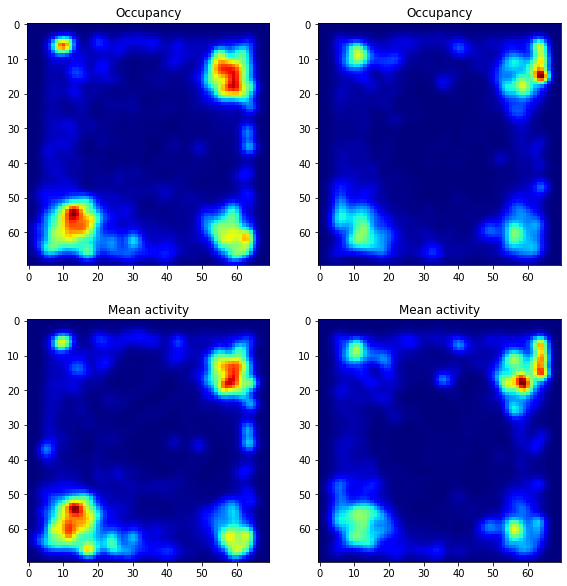

In [8]:
sigma = 1.5
NEURON = 10

figure = plt.figure(figsize=(20, 10))
gs = figure.add_gridspec(2, 4)

for day in range(len(tracking_list[day])):
    
    occupancy = occupancy_map(tracking_list[day],binnumber = BINS)
    activity_map_variable = neuron_activity_map(activity_list[day],tracking_list[day], binnumber = BINS, neuronID = NEURON)
#def neuron_activity_map(activity= None,tracking = None,binnumber = 70, neurinID = 0):

    occupancy = gaussian_filter(occupancy, sigma)
    activity_map_variable = gaussian_filter(activity_map_variable, sigma)
    
    axes0 = figure.add_subplot(gs[0,day])
    axes1 = figure.add_subplot(gs[1, day])

    axes0.imshow(occupancy, cmap = 'jet')
    axes0.set_title('Occupancy')
    axes1.imshow(activity_map_variable, cmap='jet')
    axes1.set_title('Mean activity')
    

In [9]:
# for each day creates a list that counts and saves times of different events.
events_day_list_1 = []
events_counter_day_list = []
events_time_starts_day = []
for day in range(len(behaviour_list)):
    events_list = []
    events_counter_list = []
    events_time_starts = []
    random_events = []
    start_counter = 100
    counter = 0
    for i in range(behaviour_list[day].shape[0]):
        if behaviour_list[day][i] != start_counter:
            events_list.append(start_counter)
            events_counter_list.append(counter)
            events_time_starts.append(i)
            start_counter = behaviour_list[day][i]
            counter = 1
        else:
            counter = counter + 1      
    events_day_list_1.append(events_list)
    events_counter_day_list.append(events_counter_list)
    events_time_starts_day.append(events_time_starts)

In [11]:

## compute events duration for type of event. Here we create lists that we can access to know the duration of each ID event
## we will use this to balance the dataset

events_duration_list = []
total_duration_list = []

for day in range(len(behaviour_list)):
    events_duration_day = []
    total_duration_day = []
    for target in id_target:
        events = np.array(events_day_list_1[day])  # all events in a day
        events_counter = np.array(events_counter_day_list[day]) #duration of all day events
        events_time = np.array(events_time_starts_day[day]) # start time of events in day

        position_events = np.where(events == target)[0] # select events related to one specific ID
        events_duration_target = events_counter[position_events]   # take the duration of the events for that ID
        events_duration_day.append(events_duration_target)
        total_duration_day.append(np.sum(events_duration_target))
    events_duration_list.append(events_duration_day)
    total_duration_list.append(total_duration_day)

In [13]:
### Balancing the number of events for selected targets 

selection_target = [3,4]    # here we balcance the data only for this targets of behaviour

events_day_list= []         # create a list with the selected index of the ID-list to make a balanced selection
events_day_list_shuffle = []
events_number_list = []

for day in range(len(behaviour_list)):
    arg_min_target_time = np.argmin(total_duration_list[day])
    n_events = len(events_duration_list[day][arg_min_target_time])
    events_number_list.append(n_events)
    
    events_list = []
    events_list_copy = []
    for target in id_target:
        sorted_events = np.sort(events_duration_list[day][target]) #sort of events
        arg_sorted_events = np.argsort(events_duration_list[day][target]) #take the index sorted by duration of events
        longer_events = np.where(sorted_events > 1)[0]
        selected_events = arg_sorted_events[longer_events[0]:n_events]   # take only the first (sorter duration) events
        events_list.append(selected_events)                           # save the position of long and balanced events
        events_list_copy.append(selected_events.copy())               # make a copy of this events to create a shuffle list
        
    events_day_list.append(events_list)                              #this list contains index that are selected from the list of index of a specific target
    events_day_list_shuffle.append(events_list_copy)

In [16]:
## put all events together and take neural activity from each event
events_activity_pre_norm= []
events_duration_list = []
events_activity_pca = []
events_activity_cca = []


for day in range(len(behaviour_list)):
    target_activity = []
    target_activity_pca = []
    target_activity_cca = []
    events_duration_day = []
    for target in id_target:
        events = np.array(events_day_list_1[day])
        events_counter = np.array(events_counter_day_list[day])
        events_time = np.array(events_time_starts_day[day])

        all_events = np.where(events == target)[0]
        
        #print(all_events)
        #print(events_day_list[day][target])
        position_events = all_events[events_day_list[day][target]]
        
        events_duration = events_counter[position_events]   # convert to seconds
        time = events_time[position_events]
        i = 0
        event_target = []
        event_target_pca = []
        event_target_cca = []
        #events_duration_target = np.zeros(len(events_duration),)
        events_duration_target = []
        for event in events_duration:
            if event > 2:
                local_activity = activity_list[day][:,time[i]-period:time[i]+period]
                local_activity_pca = activity_list_pca[day][:,time[i]-period:time[i]+period]
                local_activity_cca = activity_list_cca[day][time[i]-period:time[i]+period,:].T
                event_target.append(local_activity)
                event_target_pca.append(local_activity_pca)
                event_target_cca.append(local_activity_cca)
                #events_duration_target[i]=1
                events_duration_target.append(events_duration[i])
            i = i + 1
        target_activity.append(event_target)
        target_activity_pca.append(event_target_pca)
        target_activity_cca.append(event_target_cca)
        events_duration_day.append(events_duration_target)
    events_activity_pre_norm.append(target_activity)
    events_duration_list.append(events_duration_day)
    events_activity_pca.append(target_activity_pca)
    events_activity_cca.append(target_activity_cca)


    

In [ ]:
# z-score the traces
events_activity = []
for day in range(len(behaviour_list)):
    target_activity = []
    for target in id_target:
        mean_z_score = np.mean(events_activity_pre_norm[day][target],axis=0)
        #print(mean_z_score.shape)
        std_z_score = np.std(events_activity_pre_norm[day][target],axis=0)
        events_target = []
        for event in range(len(events_activity_pre_norm[day][target])):
            new_activity = (events_activity_pre_norm[day][target][event]-mean_z_score)/std_z_score
            #new_activity = events_activity_pre_norm[day][target][event]
            events_target.append(new_activity)
        target_activity.append(events_target)
    events_activity.append(target_activity)

In [18]:
events_activity = events_activity_pre_norm




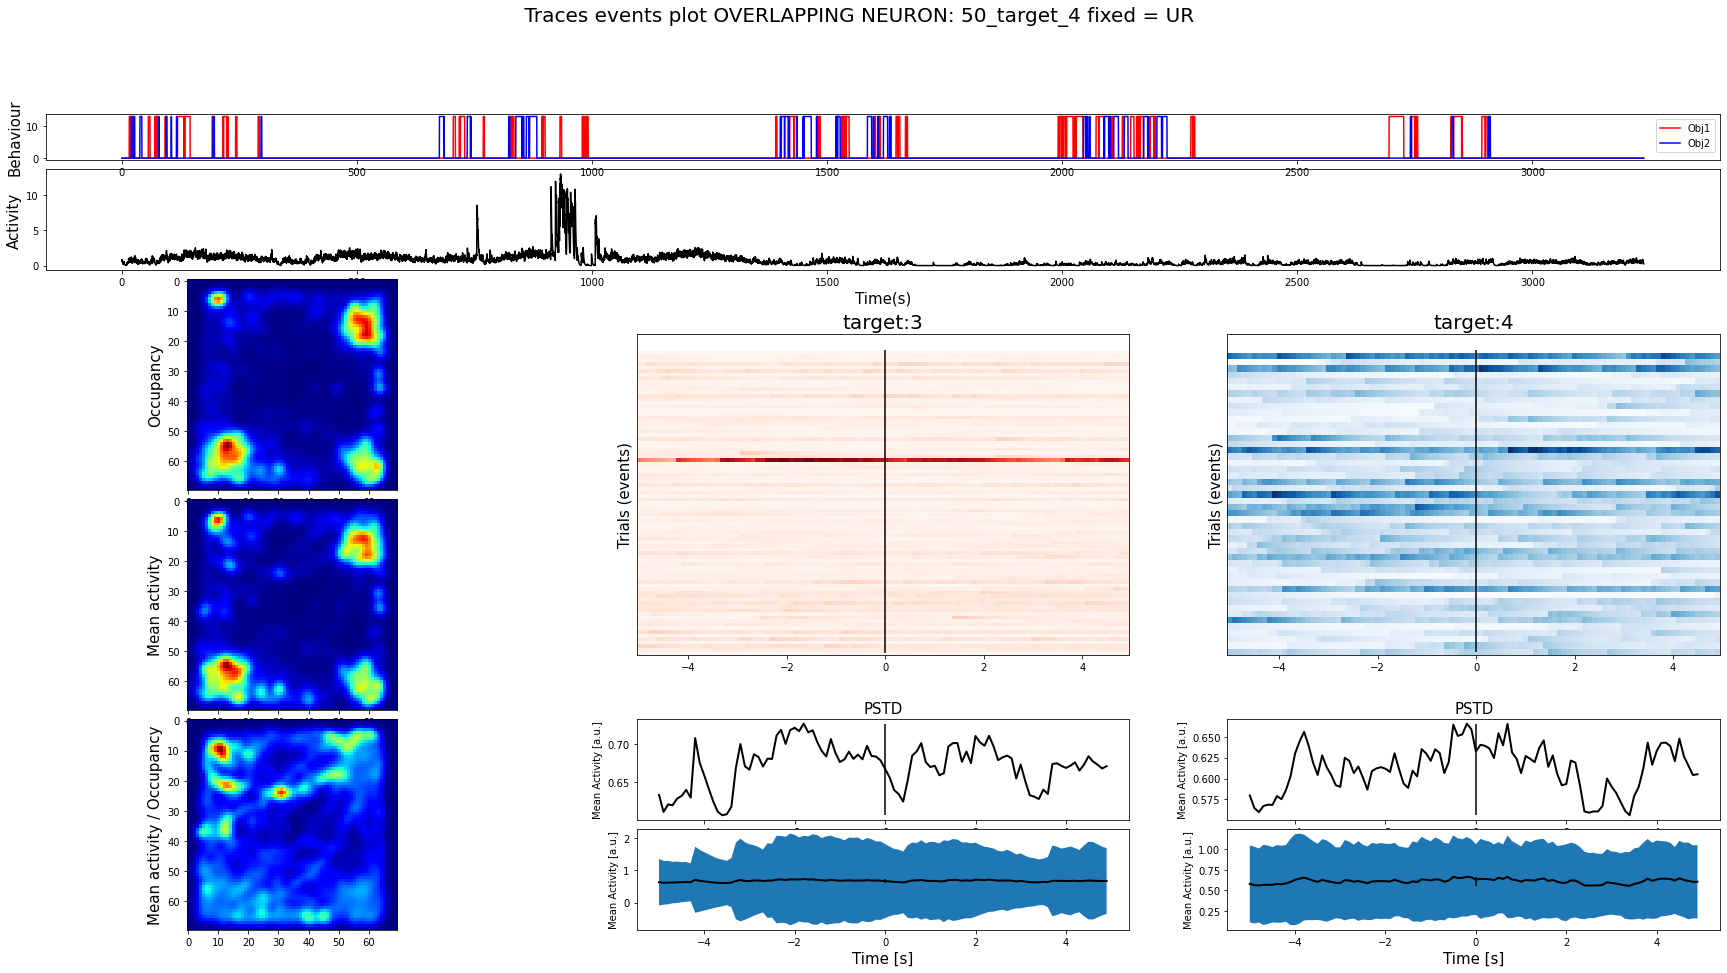

In [26]:
    ### Select a cell
    day = 0
    #for NEURON in range(100):
    NEURON = 50
    figure = plt.figure()
    gs = plt.GridSpec(15, 3)

    axes = figure.add_subplot(gs[1:3, 0:3])
    axes.plot(np.arange(0,len(activity_list[day][NEURON,:])/10,1/10),activity_list[day][NEURON,:],color = 'k')
    axes.set_xlabel('Time(s)',fontsize = 15)
    axes.set_ylabel('Activity',fontsize = 15)

    axes = figure.add_subplot(gs[0, 0:3])
    behaviour1 = np.zeros((len(behaviour_list[day]),))
    behaviour1[np.where(behaviour_list[day]==3)[0]] = np.max(activity_list[day][NEURON,:])
    axes.plot(np.arange(0,len(activity_list[day][NEURON,:])/10,1/10),behaviour1, color = 'r')
    behaviour1 = np.zeros((len(behaviour_list[day]),))
    behaviour1[np.where(behaviour_list[day]==4)[0]] = np.max(activity_list[day][NEURON,:])
    axes.plot(np.arange(0,len(activity_list[day][NEURON,:])/10,1/10),behaviour1, color = 'b')
    axes.set_ylabel('Behaviour',fontsize = 15)
    axes.legend(['Obj1','Obj2'])


    color_code = ['Reds','Blues']
    j = 1
    for target in selection_target:
        axes = figure.add_subplot(gs[4:10, j])
        color = events_duration_list[day][target]
        neuron_trial_activity = np.zeros((len(events_activity[day][target]),events_activity[day][3][0].shape[1]))
        for trial in range(len(events_activity[day][target])):
            neuron_trial_activity[trial,:] = events_activity_pre_norm[day][target][trial][NEURON,:]
            
        C_0 = neuron_trial_activity.copy()
        time_axis = np.arange(-period,period)/10
        neurons_axis = np.arange(0,C_0.shape[0])
        mesh = axes.pcolormesh(time_axis,neurons_axis, C_0, cmap=color_code[j-1],shading='auto')
            
#         C_0[0] += C_0[0].min()
#         for i in range(0, len(C_0)):
#             #C_0[i] += C_0[i].min() + C_0[:i].max()
#             C_0[i]= C_0[i]/(C_0[i].max()-C_0[i].min()) + i
#             if color[i]==1:
#                 axes.plot(np.arange(-period,period)/10,C_0[i],color_code[j-1])
#             else:
#                 axes.plot(np.arange(-period,period)/10,C_0[i],'k')
        #axes.set_xlabel('Time [s]',fontsize = 15)
    
        axes.set_yticks([])
        axes.set_ylabel('Trials (events)', fontsize = 15)
        axes.set_title('target:' + f'{target}', fontsize = 20)
        axes.vlines(0,0, C_0.shape[0], color = 'k')
        
        axes_1 = figure.add_subplot(gs[11:13, j])
        pstd = np.mean(neuron_trial_activity,axis = 0)
        time_axis = np.arange(-period,period)/10
        axes_1.plot(time_axis, pstd,'k', linewidth = 2)
        axes_1.set_title('PSTD', fontsize = 15)
        axes_1.vlines(0,min(pstd), max(pstd),color = 'k',linestyle = '-')
        axes_1.set_ylabel('Mean Activity [a.u.]',fontsize = 10)

        axes_1 = figure.add_subplot(gs[13:15, j])
        pstd_std = np.std(neuron_trial_activity,axis = 0)
        uperbound = pstd + pstd_std
        lowerbound = pstd - pstd_std
        time_axis = np.arange(-period,period)/10
        axes_1.plot(time_axis, pstd,'k', linewidth = 2)
        axes_1.fill_between(time_axis , lowerbound , uperbound)#, edgecolor=color[i], facecolor = color[i])
        axes_1.vlines(0,min(pstd), max(pstd),color = 'k',linestyle = '-')
        axes_1.set_xlabel('Time [s]',fontsize = 15)
        axes_1.set_ylabel('Mean Activity [a.u.]',fontsize = 10)
        j=j+1


    sigma = 1.5
    occupancy = occupancy_map(tracking_list[day],binnumber = BINS)
    activity_map_variable = neuron_activity_map(activity_list[day],tracking_list[day], binnumber = BINS, neuronID = NEURON)
    normalized_activity_map = np.zeros_like(activity_map_variable)
    normalized_activity_map[np.where(occupancy)] = activity_map_variable[np.where(occupancy)]/occupancy[np.where(occupancy)]
    
    occupancy = gaussian_filter(occupancy, sigma)
    activity_map_variable = gaussian_filter(activity_map_variable, sigma)
    normalized_activity_map = gaussian_filter(normalized_activity_map,sigma)
    
    axes0 = figure.add_subplot(gs[3:7,0])
    axes1 = figure.add_subplot(gs[7:11, 0])
    axes2 = figure.add_subplot(gs[11:15, 0])

    axes0.imshow(occupancy, cmap = 'jet')
    axes0.set_ylabel('Occupancy', fontsize = 15)
    axes1.imshow(activity_map_variable, cmap='jet')
    axes1.set_ylabel('Mean activity',fontsize = 15)
    axes2.imshow(normalized_activity_map, cmap = 'jet')
    axes2.set_ylabel('Mean activity / Occupancy', fontsize = 15)
    
    
    #axes = figure.add_subplot(gs[3:10,0])
    #axes.imshow(activity_map_variable, cmap='jet')
    #axes.set_title('Mean Spatial Neural activity')

    figure.set_size_inches([30., 15])

    figure.suptitle(' Traces events plot ' + task +' NEURON: '+f'{NEURON}'+'_target_'+f'{target}'+ ' fixed = ' + fixed   , fontsize = 20)
    figure_name = figure_path + 'traces_events_neuron_'+f'{NEURON}'+'_target_'+f'{target}'+'_'+f'{mouse}'+'_session_'+f'{session}'+\
                                 '_day_'+f'{day}'+'_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'
    figure.savefig(figure_name)
    #plt.close()

    

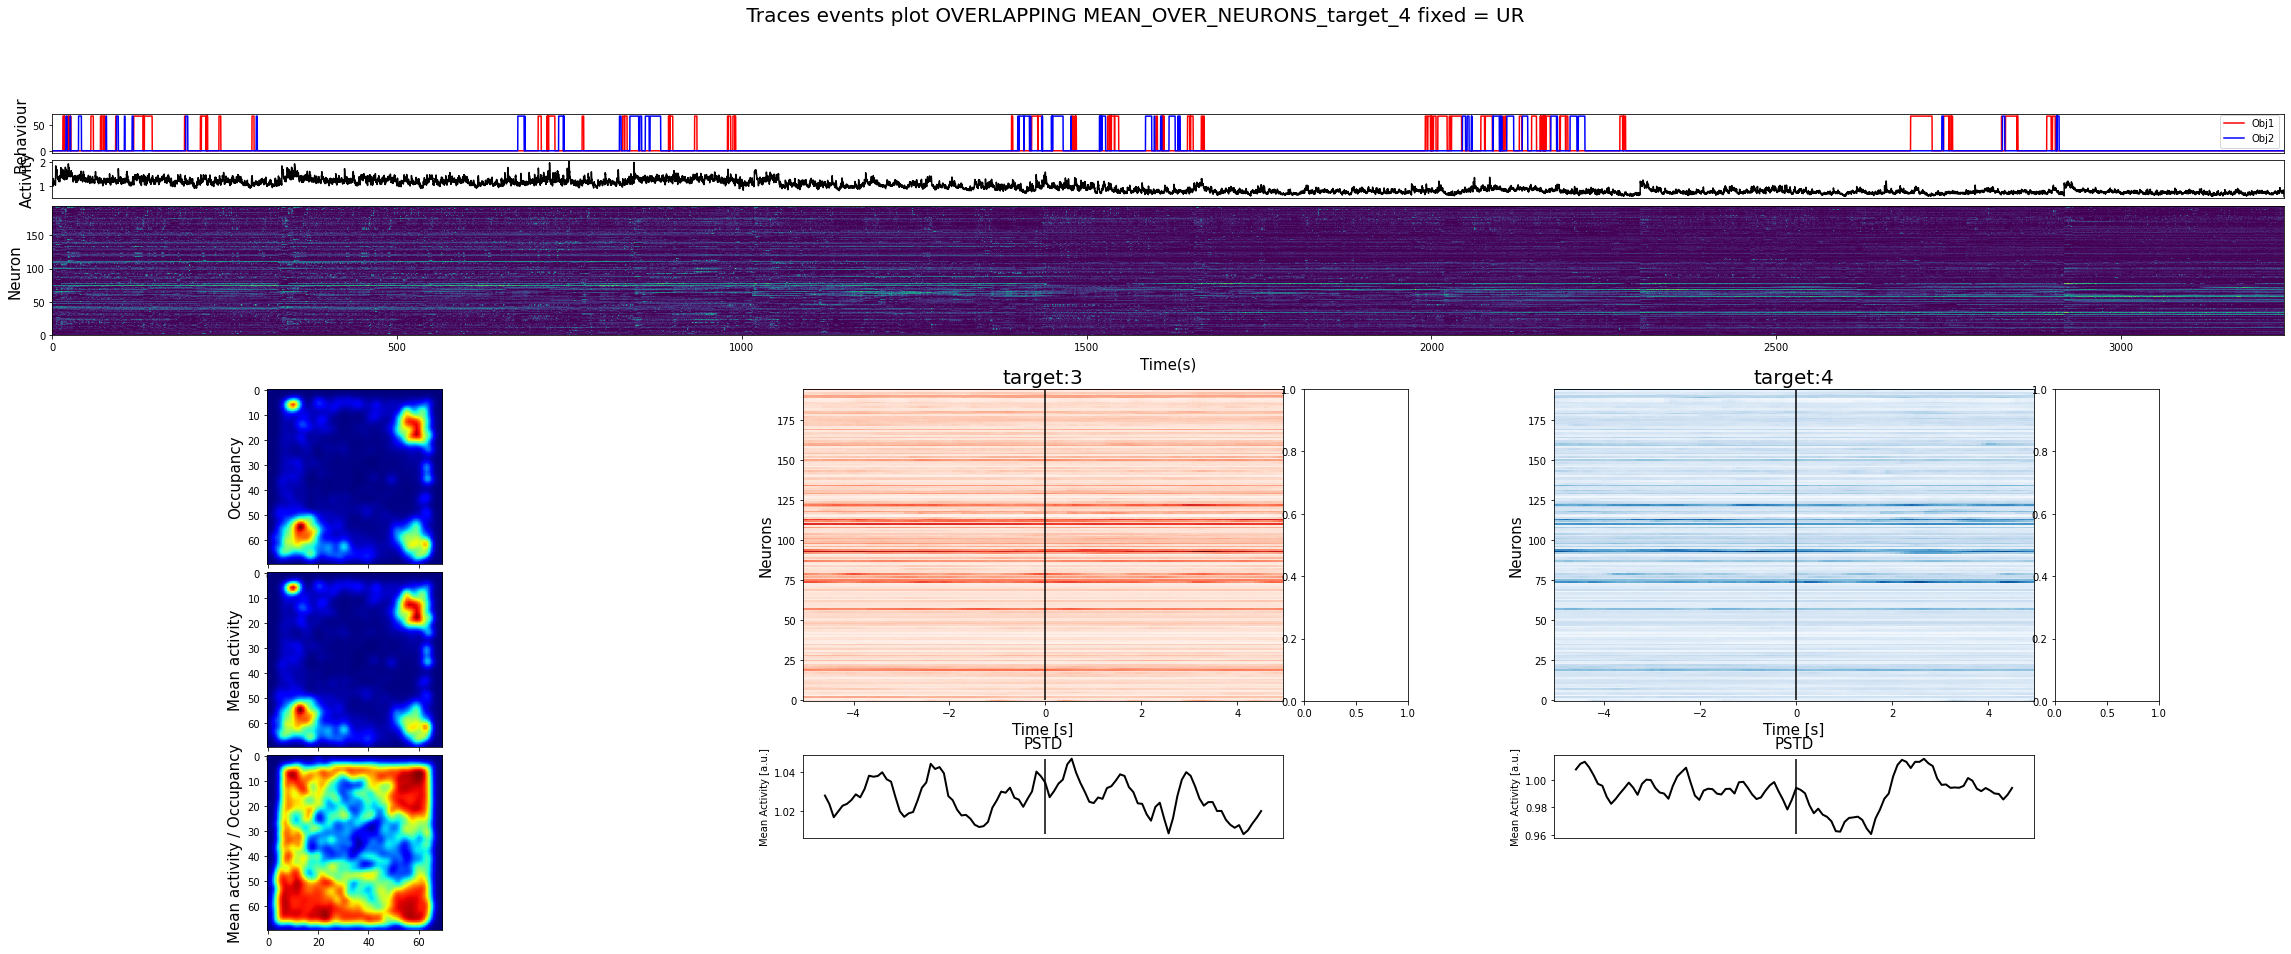

In [21]:
    ### Select a cell
    figure = plt.figure()
    gs = plt.GridSpec(18, 18)

    axes = figure.add_subplot(gs[1:2, 0:18])
    axes.plot(np.arange(0,len(activity_list[day][NEURON,:])/10,1/10),np.mean(activity_list[day],axis=0),color = 'k')
    axes.set_ylabel('Activity',fontsize = 15)
    axes.set_xticks([])
    axes.set_xlim([0,len(behaviour_list[day])/10])

    axes = figure.add_subplot(gs[0, 0:18])
    behaviour1 = np.zeros((len(behaviour_list[day]),))
    behaviour1[np.where(behaviour_list[day]==3)[0]] = np.max(activity_list[day][NEURON,:])
    axes.plot(np.arange(0,len(activity_list[day][NEURON,:])/10,1/10),behaviour1, color = 'r')
    behaviour1 = np.zeros((len(behaviour_list[day]),))
    behaviour1[np.where(behaviour_list[day]==4)[0]] = np.max(activity_list[day][NEURON,:])
    axes.plot(np.arange(0,len(activity_list[day][NEURON,:])/10,1/10),behaviour1, color = 'b')
    axes.set_ylabel('Behaviour',fontsize = 15)
    axes.legend(['Obj1','Obj2'])
    axes.set_xticks([])
    axes.set_xlim([0,len(behaviour_list[day])/10])

    
    axes = figure.add_subplot(gs[2:5, 0:18])
    time_axis = np.arange(0,len(behaviour_list[day]))/10
    neurons_axis = np.arange(0,events_activity[day][target][0].shape[0])
    activity = np.zeros((events_activity[day][target][0].shape[0],len(behaviour_list[day])))
    for i in neurons_axis:
        activity[i,:] = activity_list[day][i,:]/(np.max(activity_list[day][i,:])-np.mean(activity_list[day][i,:]))
    
    mesh = axes.pcolormesh(time_axis,neurons_axis,activity, cmap='viridis',shading='auto')
    axes.set_xlabel('Time(s)',fontsize = 15)
    axes.set_ylabel('Neuron',fontsize = 15)

    color_code = ['Reds','Blues']
    #color_code = ['r','b']
    columns = [np.arange(6,11)]
    j=0
    columns.append(np.arange(12,17))
    for target in selection_target:
        axes = figure.add_subplot(gs[6:13, 6*(j+1):6*(j+1)+4])
        trial_activity = np.zeros((events_activity[day][target][0].shape[0],events_activity[day][target][0].shape[1]))
        for neuron in range(events_activity[day][target][0].shape[0]):
            neuron_trial_activity = np.zeros((events_activity[day][target][0].shape[1],))
            for trial in range(len(events_activity[day][target])):
                neuron_trial_activity += events_activity[day][target][trial][neuron,:]#/(np.max(events_activity[day][target][trial][neuron,:])-np.min(events_activity[day][target][trial][neuron,:]))
            neuron_trial_activity = neuron_trial_activity / len(events_activity[day][target])
            trial_activity[neuron,:] = neuron_trial_activity
            
        C_0 = trial_activity.copy()
        time_axis = np.arange(-period,period)/10
        neurons_axis = np.arange(0,C_0.shape[0])
        #time_axis, neurons_axis = np.meshgrid(time_axis, neurons_axis)
        
        #surf = axes.plot_surface(time_axis, neurons_axis, C_0, cmap=color_code[j-1],linewidth=0, antialiased=False)
        mesh = axes.pcolormesh(time_axis,neurons_axis, C_0, cmap=color_code[j],shading='auto')
        #axes.imshow(neurons_axis,time_axis,C_0, cmap = color_code[j-1])
#         C_0[0] += C_0[0].min()
#         for i in range(0, C_0.shape[0]):
#             #C_0[i] += C_0[i].min() + C_0[:i].max()
#             C_0[i]= C_0[i]/(C_0[i].max()-C_0[i].min()) + i
#             axes.plot(np.arange(-period,period)/10,C_0[i],color_code[j])
        axes.set_xlabel('Time [s]',fontsize = 15)
    
        #axes.set_yticks()
        axes.set_xlabel('Time [s]', fontsize = 15)
        axes.set_ylabel('Neurons', fontsize = 15)
        axes.set_title('target:' + f'{target}', fontsize = 20)
        axes.vlines(0,0, neuron, color = 'k')
        
        axes_1 = figure.add_subplot(gs[14:16,6*(j+1):6*(j+1)+4])
        pstd = np.mean(trial_activity,axis = 0)
        pstd_std_error = np.std(neuron_trial_activity,axis = 0)/trial_activity.shape[0]
        time_axis = np.arange(-period,period)/10
        uperbound = pstd + pstd_std_error
        lowerbound = pstd - pstd_std_error
        axes_1.plot(time_axis, pstd,'k', linewidth = 2)
        axes_1.fill_between(time_axis , lowerbound , uperbound)#, edgecolor=color[i], facecolor = color[i])        
        axes_1.set_title('PSTD', fontsize = 15)
        axes_1.vlines(0,min(uperbound), max(lowerbound),color = 'k',linestyle = '-')
        axes_1.set_ylabel('Mean Activity [a.u.]',fontsize = 10)
        axes_1.set_xticks([])

#         axes_1 = figure.add_subplot(gs[16:18, 6*(j+1):6*(j+1)+4])
#         pstd_std = np.std(neuron_trial_activity,axis = 0)
#         uperbound = pstd + pstd_std
#         lowerbound = pstd - pstd_std
#         time_axis = np.arange(-period,period)/10
#         axes_1.plot(time_axis, pstd,'k', linewidth = 2)
#         axes_1.fill_between(time_axis , lowerbound , uperbound)#, edgecolor=color[i], facecolor = color[i])
#         axes_1.vlines(0,np.min(pstd-pstd_std), np.max(pstd+pstd_std),color = 'k',linestyle = 'dotted')
#         axes_1.set_xlabel('Time [s]',fontsize = 15)
#         axes_1.set_ylabel('Mean Activity [a.u.]',fontsize = 10)
        
        axes_1 = figure.add_subplot(gs[6:13,6*(j+1)+4])
        pop_vect = np.mean(trial_activity,axis = 1)
        #axes_1.plot(pop_vect,'k', linewidth = 2)

        #axes_1.set_title('PSTD', fontsize = 15)
        #axes_1.vlines(0,min(pstd), max(pstd),color = 'k',linestyle = '-')
        #axes_1.set_ylabel('Mean Activity [a.u.]',fontsize = 10)
        
        #axes_1.set_xticks([])
        #from matplotlib import transforms
        #base = plt.gca().transData
        #rot = transforms.Affine2D().rotate_deg(90)

        ## define transformed line
        #axes_1.plot(np.arange(0,neuron+1),pop_vect,'k',transform= base + rot)
        j=j+1
        

    sigma = 1.5
    occupancy = occupancy_map(tracking_list[day],binnumber = BINS)
    activity_map_variable = mean_activity_map(activity_list[day],tracking_list[day], binnumber = BINS)
    normalized_activity_map = np.zeros_like(activity_map_variable)
    normalized_activity_map[np.where(occupancy)] = activity_map_variable[np.where(occupancy)]/occupancy[np.where(occupancy)]
    
    normalized_activity_map = gaussian_filter(normalized_activity_map,sigma)
    occupancy = gaussian_filter(occupancy, sigma)
    activity_map_variable = gaussian_filter(activity_map_variable, sigma)
    
    axes0 = figure.add_subplot(gs[6:10,0:5])
    axes1 = figure.add_subplot(gs[10:14, 0:5])
    axes2 = figure.add_subplot(gs[14:18, 0:5])

    axes0.imshow(occupancy, cmap = 'jet')
    axes0.set_ylabel('Occupancy', fontsize = 15)
    axes1.imshow(activity_map_variable, cmap='jet')
    axes1.set_ylabel('Mean activity',fontsize = 15)
    axes2.imshow(normalized_activity_map, cmap = 'jet')
    axes2.set_ylabel('Mean activity / Occupancy', fontsize = 15)
    
    
    #axes = figure.add_subplot(gs[3:10,0])
    #axes.imshow(activity_map_variable, cmap='jet')
    #axes.set_title('Mean Spatial Neural activity')

    figure.set_size_inches([40., 15])

    figure.suptitle(' Traces events plot ' + task +' MEAN_OVER_NEURONS_target_'+f'{target}'+ ' fixed = ' + fixed   , fontsize = 20)
    figure_name = figure_path + 'traces_events_neuron_'+f'{NEURON}'+'_target_'+f'{target}'+'_'+f'{mouse}'+'_session_'+f'{session}'+\
                                 '_day_'+f'{day}'+'_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'
    figure.savefig(figure_name)
    #plt.close()


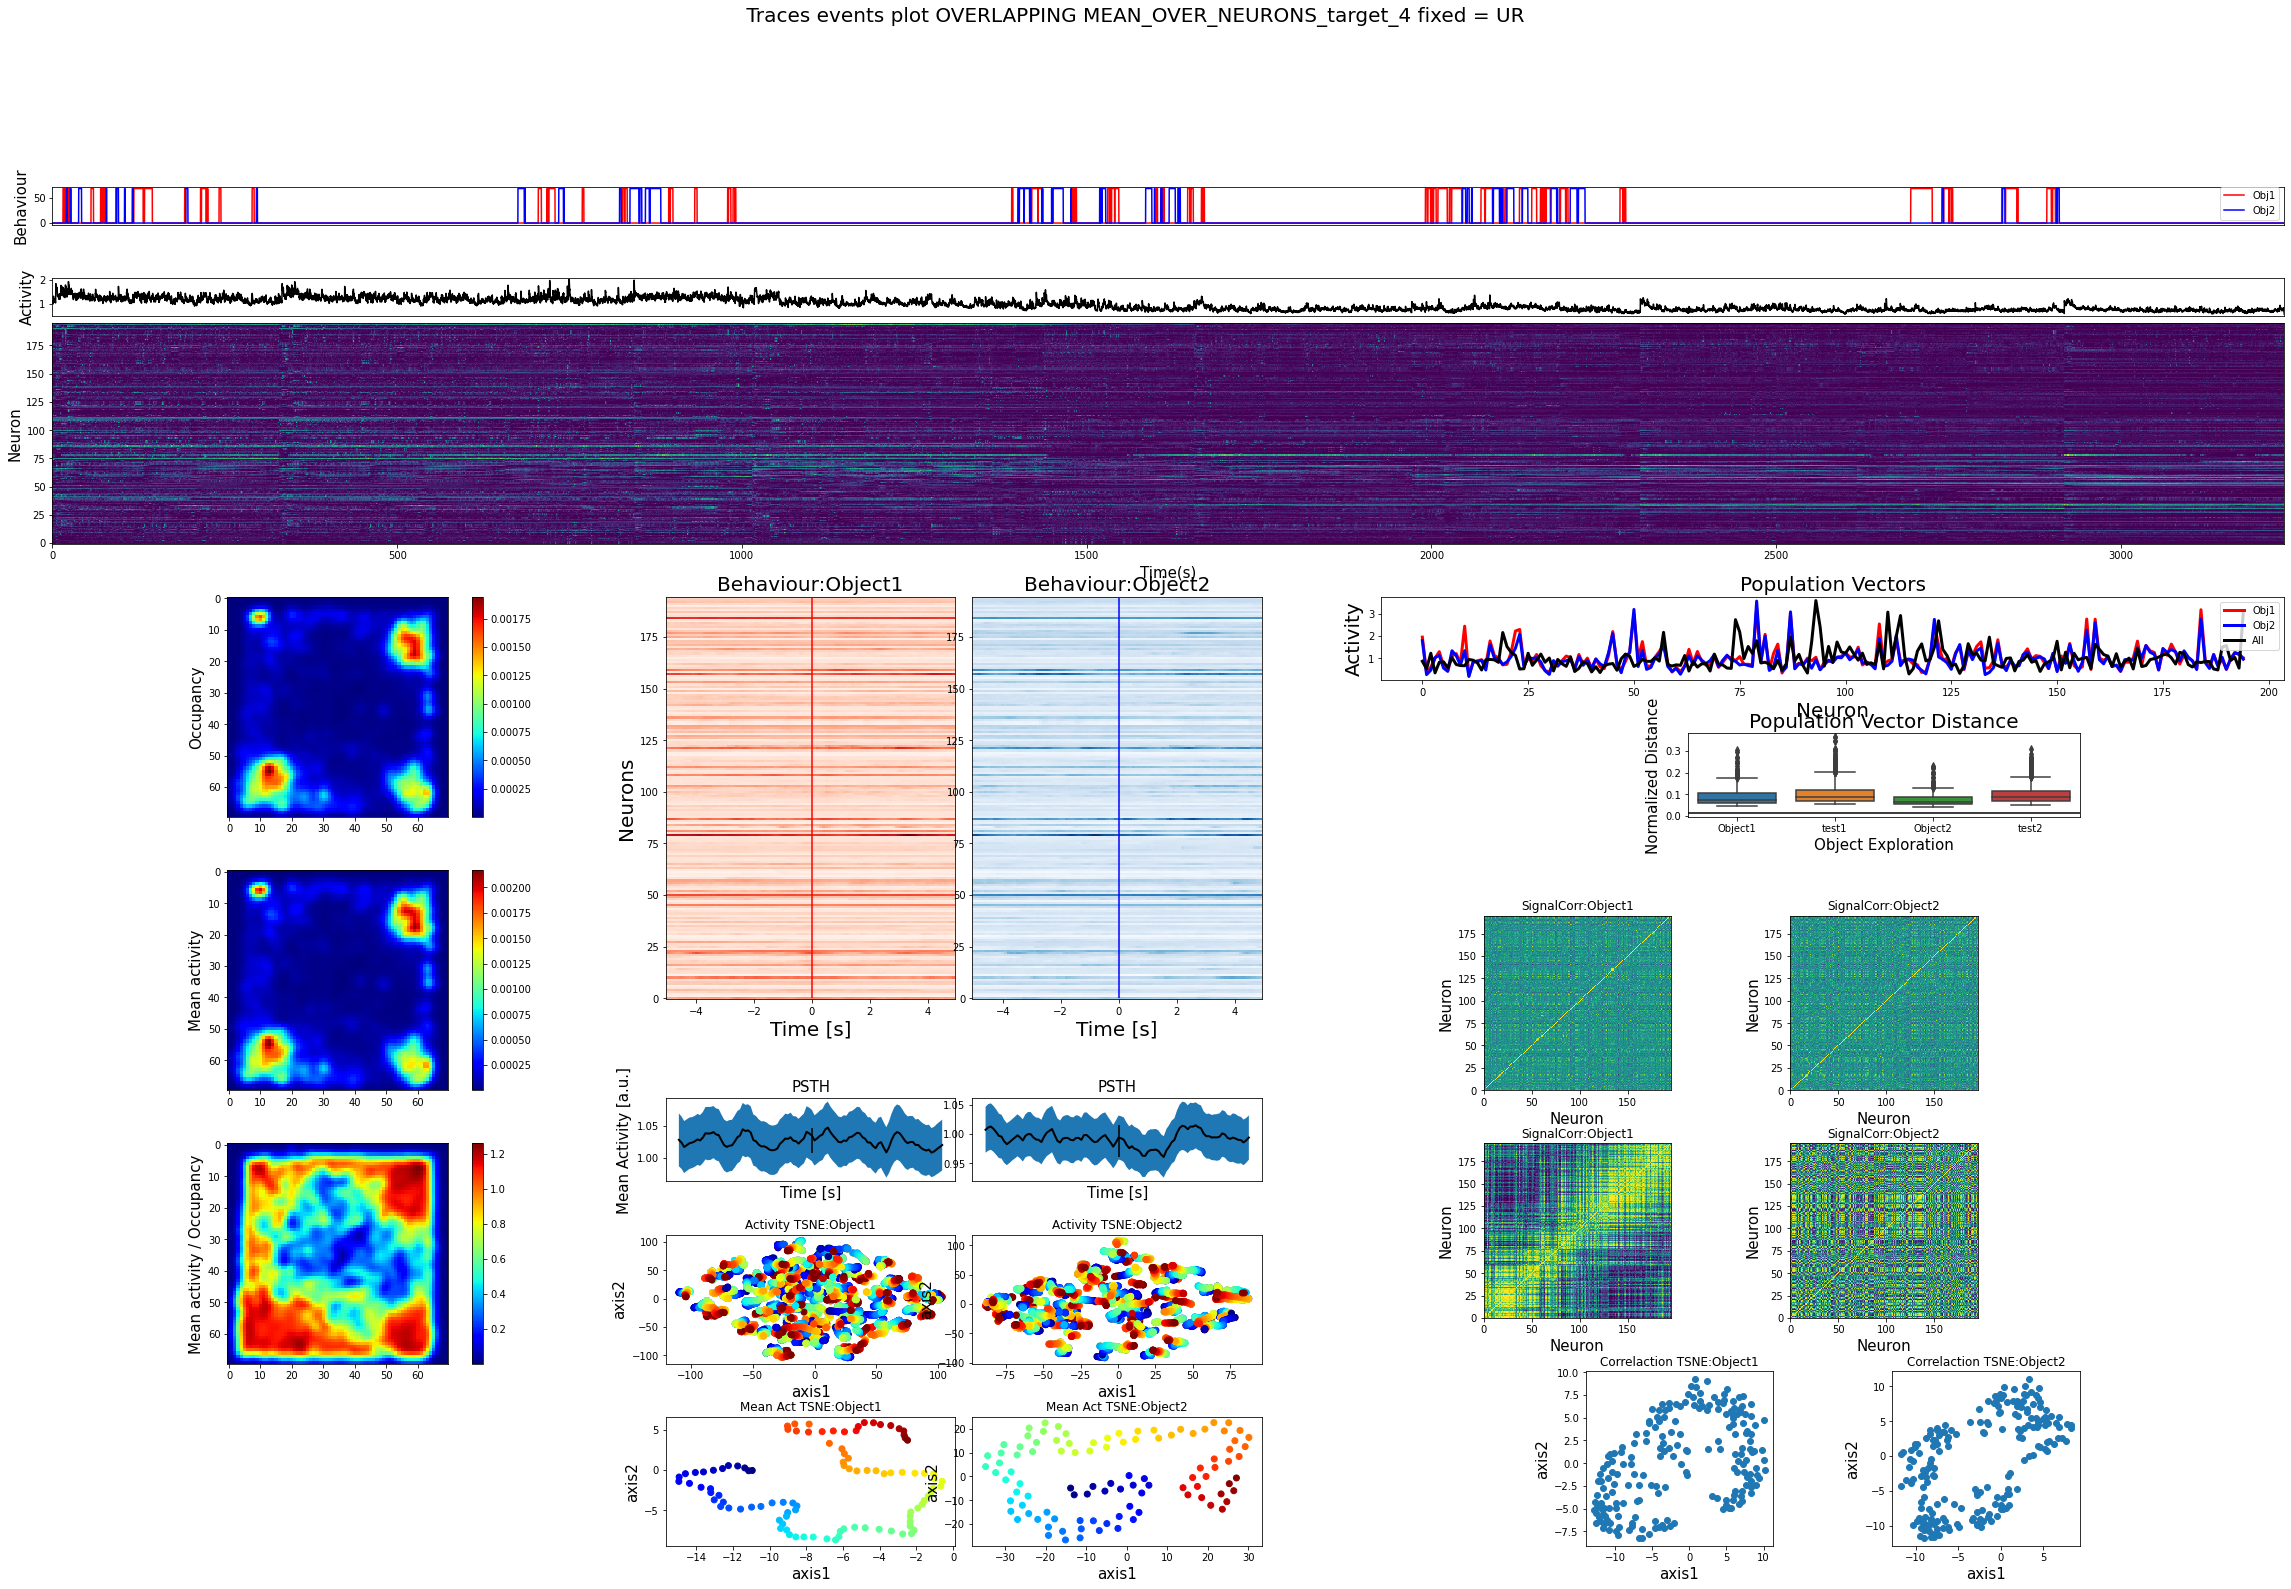

In [22]:
    ### Select a cell
    behaviour = ['Object1','Object2']
    events_activity = events_activity_pre_norm
    vmin_corr = -1
    vmax_corr = 1

    figure = plt.figure()
    gs = plt.GridSpec(30, 22)

    axes = figure.add_subplot(gs[2, 0:22])
    axes.plot(np.arange(0,len(activity_list[day][NEURON,:])/10,1/10),np.mean(activity_list[day],axis=0),color = 'k')
    axes.set_ylabel('Activity',fontsize = 15)
    axes.set_xticks([])
    axes.set_xlim([0,len(behaviour_list[day])/10])

    axes = figure.add_subplot(gs[0, 0:22])
    behaviour1 = np.zeros((len(behaviour_list[day]),))
    behaviour1[np.where(behaviour_list[day]==3)[0]] = np.max(activity_list[day][NEURON,:])
    axes.plot(np.arange(0,len(activity_list[day][NEURON,:])/10,1/10),behaviour1, color = 'r')
    behaviour1 = np.zeros((len(behaviour_list[day]),))
    behaviour1[np.where(behaviour_list[day]==4)[0]] = np.max(activity_list[day][NEURON,:])
    axes.plot(np.arange(0,len(activity_list[day][NEURON,:])/10,1/10),behaviour1, color = 'b')
    axes.set_ylabel('Behaviour',fontsize = 15)
    axes.legend(['Obj1','Obj2'])
    axes.set_xticks([])
    axes.set_xlim([0,len(behaviour_list[day])/10])

#     axes = figure.add_subplot(gs[1, 0:22])
#     behaviour1 = np.zeros((len(behaviour_list_copy[day]),))
#     behaviour1[np.where(behaviour_list_copy[day]==3)[0]] = np.max(activity_list[day][NEURON,:])
#     axes.plot(np.arange(0,len(activity_list[day][NEURON,:])/10,1/10),behaviour1, color = 'g')
#     behaviour1 = np.zeros((len(behaviour_list[day]),))
#     behaviour1[np.where(behaviour_list_copy[day]==4)[0]] = np.max(activity_list[day][NEURON,:])
#     axes.plot(np.arange(0,len(activity_list[day][NEURON,:])/10,1/10),behaviour1, color = 'orange')
#     behaviour1[np.where(behaviour_list_copy[day]==5)[0]] = np.max(activity_list[day][NEURON,:])
#     axes.plot(np.arange(0,len(activity_list[day][NEURON,:])/10,1/10),behaviour1, color = 'r')
#     behaviour1[np.where(behaviour_list_copy[day]==6)[0]] = np.max(activity_list[day][NEURON,:])
#     axes.plot(np.arange(0,len(activity_list[day][NEURON,:])/10,1/10),behaviour1, color = 'cyan')
#     axes.set_ylabel('Behaviour',fontsize = 15)
#     axes.legend(['UR','UL','LR','LL']) ###verify this
#     axes.set_xticks([])
#     axes.set_xlim([0,len(behaviour_list[day])/10])
    
    axes = figure.add_subplot(gs[3:8, 0:22])
    time_axis = np.arange(0,len(behaviour_list[day]))/10
    neurons_axis = np.arange(0,events_activity[day][target][0].shape[0])
    activity = np.zeros((events_activity[day][target][0].shape[0],len(behaviour_list[day])))
    for i in neurons_axis:
        activity[i,:] = activity_list[day][i,:]/(np.max(activity_list[day][i,:])-np.mean(activity_list[day][i,:]))
    
    mean_pop_vector = np.zeros((activity_list[day].shape[0],))
    mesh = axes.pcolormesh(time_axis,neurons_axis,activity, cmap='viridis',shading='auto')
    axes.set_xlabel('Time(s)',fontsize = 15)
    axes.set_ylabel('Neuron',fontsize = 15)

    color_code = ['Reds','Blues']
    color_code_pop = ['r','b']
    j=0
    
    ### definition of subplots that have plots from different exploratory behaviour
    axes_pop_vector = figure.add_subplot(gs[9:11,13:22])
    
    pop_vector_distance = []
    pop_vect_list = []
    mean_pop_vector_list = []

    for target in selection_target:
        
        ### subplots for mean activity 
        axes = figure.add_subplot(gs[9:18, 3*(j+1)+3:3*(j+1)+6])
        
        trial_activity = np.zeros((events_activity[day][target][0].shape[0],events_activity[day][target][0].shape[1]))
        trial_activity_complete = np.zeros((events_activity[day][target][0].shape[0],len(events_activity[day][target])*10+1))
        trial_activity_all_data = np.zeros((events_activity[day][target][0].shape[0],len(events_activity[day][target])*2*period+1))
        trial_activity_pca = np.zeros((events_activity[day][target][0].shape[0],events_activity[day][target][0].shape[1]))
        
        ### generate matrix with mean activity and entire trial repetitions activity
        for neuron in range(events_activity[day][target][0].shape[0]):
            neuron_trial_activity = np.zeros((events_activity[day][target][0].shape[1],))
            component_trial_activity = np.zeros((events_activity[day][target][0].shape[1],))
            init = 0
            init2=0
            for trial in range(len(events_activity[day][target])):
                neuron_trial_activity += events_activity[day][target][trial][neuron,:]#/(np.max(events_activity[day][target][trial][neuron,:])-np.min(events_activity[day][target][trial][neuron,:]))
                component_trial_activity +=events_activity_pca[day][target][trial][neuron,:]
                trial_activity_all_data[neuron,init2:init2+2*period]= events_activity[day][target][trial][neuron,:]
                trial_activity_complete[neuron,init:init+10] = events_activity[day][target][trial][neuron,period:period+10]
                init = init+10
                init2=init2+2*period
            neuron_trial_activity = neuron_trial_activity / len(events_activity[day][target])
            component_trial_activity = component_trial_activity / len(events_activity[day][target])
            trial_activity[neuron,:] = neuron_trial_activity
            trial_activity_pca[neuron,:] = component_trial_activity
        
        if j == 0:
            max_position = np.argmax(trial_activity[:,period:period+10],axis = 1)
            firing_order = np.argsort(max_position)
        C_0 = trial_activity.copy()
        C_0 = C_0[firing_order,:]
        trial_activity_complete = trial_activity_complete[firing_order,:]

        mean_pop_vector1 = np.mean(trial_activity,axis =1)
        mean_pop_vector_list.append(mean_pop_vector1)
        mean_pop_vector += mean_pop_vector1
        
        time_axis = np.arange(-period,period)/10
        neurons_axis = np.arange(0,C_0.shape[0])        
        mesh = axes.pcolormesh(time_axis,neurons_axis, C_0, cmap=color_code[j],shading='auto')
        axes.set_xlabel('Time [s]',fontsize = 20)
    
        #axes.set_yticks()
        axes.set_xlabel('Time [s]', fontsize = 20)
        if j==0:
            axes.set_ylabel('Neurons', fontsize = 20)
        axes.set_title('Behaviour:' + behaviour[j], fontsize = 20)
        axes.vlines(0,0, neuron, color = color_code_pop[j])
                
        
        axes_1 = figure.add_subplot(gs[20:22,3*(j+1)+3:3*(j+1)+6])
        pstd = np.mean(trial_activity,axis = 0)
        pstd_std_error = np.std(trial_activity,axis = 0)/np.sqrt(trial_activity.shape[0])
        uperbound = pstd + pstd_std_error
        lowerbound = pstd - pstd_std_error
        axes_1.plot(time_axis, pstd,'k', linewidth = 2)
        axes_1.fill_between(time_axis , lowerbound , uperbound)#, edgecolor=color[i], facecolor = color[i])
        axes_1.set_title('PSTH', fontsize = 15)
        axes_1.vlines(0,min(pstd), max(pstd),color = 'k',linestyle = '-')
        if j==0:
            axes_1.set_ylabel('Mean Activity [a.u.]',fontsize = 15)
        axes_1.set_xticks([])
        axes_1.set_xlabel('Time [s]',fontsize = 15)
        
        pop_vect = np.mean(C_0[:,period:period+10],axis = 1)
        axes_pop_vector.plot(np.arange(0,neuron+1),pop_vect, color_code_pop[j],linewidth = 3)
        axes_pop_vector.set_xlabel('Neuron',fontsize = 20)
        axes_pop_vector.set_ylabel('Activity', fontsize = 20)
        pop_vect_list.append(pop_vect)
        
        corr_matrix2 = stats.corr_matrix(neural_activity = trial_activity_complete)
        axes_corr = figure.add_subplot(gs[16:20,14+3*j:16+3*j])
        #axes_corr = figure.add_subplot(gs[17:21,3*(j+1):3*(j+1)+3])
        #axes_corr = figure.add_subplot(gs[22:26,3*(j+1):3*(j+1)+3])
        #axes_corr.imshow(corr_matrix2, cmap = 'viridis', origin = 'lower')
        mesh_corr = axes_corr.pcolormesh(corr_matrix2, cmap = 'viridis')
        axes_corr.set_xlabel('Neuron',fontsize = 15)
        axes_corr.set_ylabel('Neuron',fontsize = 15)
        axes_corr.set_title('SignalCorr:' + behaviour[j])
        mesh_corr.set_clim(vmin_corr,vmax_corr)


        corr_matrix = stats.corr_matrix(neural_activity = C_0[:,period:period+10])
        axes_corr = figure.add_subplot(gs[21:25,14+3*j:16+3*j])
        #axes_corr = figure.add_subplot(gs[22:26,3*(j+1):3*(j+1)+3])
        #axes_corr.imshow(corr_matrix, cmap = 'viridis', origin = 'lower')
        mesh_corr = axes_corr.pcolormesh(corr_matrix, cmap = 'viridis')
        axes_corr.set_xlabel('Neuron',fontsize = 15)
        axes_corr.set_ylabel('Neuron',fontsize = 15)
        axes_corr.set_title('SignalCorr:' + behaviour[j])
        mesh_corr.set_clim(vmin_corr,vmax_corr)

        tsne_components = 2
        events_embedded = TSNE(n_components=tsne_components).fit_transform(corr_matrix)
        axes_corr = figure.add_subplot(gs[26:30,15+3*j:17+3*j])
        axes_corr.scatter(events_embedded[:,0],events_embedded[:,1])#, cmap = 'viridis', origin = 'lower')
        axes_corr.set_xlabel('axis1',fontsize = 15)
        axes_corr.set_ylabel('axis2',fontsize = 15)
        axes_corr.set_title('Correlaction TSNE:' + behaviour[j])  
        
        events_embedded_temporal = TSNE(n_components=tsne_components).fit_transform(trial_activity_all_data.T)
        axes_corr = figure.add_subplot(gs[23:26,3*(j+1)+3:3*(j+1)+6])
        color1 = np.linspace(0, 20, 2*period)
        repetitions = len(events_activity[day][target])
        repeat_color =  np.tile(color1, (repetitions, 1)).flatten()
        axes_corr.scatter(events_embedded_temporal[:-1,0],events_embedded_temporal[:-1,1],c = repeat_color, cmap = cmap)
        axes_corr.set_xlabel('axis1',fontsize = 15)
        axes_corr.set_ylabel('axis2',fontsize = 15)
        axes_corr.set_title('Activity TSNE:' + behaviour[j])   
        
        events_embedded_mean_temporal = TSNE(n_components=tsne_components).fit_transform(trial_activity.T)
        axes_corr = figure.add_subplot(gs[27:30,3*(j+1)+3:3*(j+1)+6])
        color1 = np.linspace(0, 20, 2*period)
        axes_corr.scatter(events_embedded_mean_temporal[:,0],events_embedded_mean_temporal[:,1],c = color1, cmap = cmap)
        axes_corr.set_xlabel('axis1',fontsize = 15)
        axes_corr.set_ylabel('axis2',fontsize = 15)
        axes_corr.set_title('Mean Act TSNE:' + behaviour[j])   
        
        euclidean_distance = np.zeros((len(events_activity[day][target])*10,))
        for time_point in range(len(euclidean_distance)):
            euclidean_distance[time_point] = np.linalg.norm(pop_vect - trial_activity_complete[:,time_point])/ trial_activity.shape[0]
        pop_vector_distance.append(euclidean_distance)
   
        euclidean_distance = np.zeros((len(events_activity[day][target])*2*period,))
        for time_point in range(len(euclidean_distance)):
            euclidean_distance[time_point] = np.linalg.norm(pop_vect- trial_activity_all_data[:,time_point]) / trial_activity.shape[0]
        pop_vector_distance.append(euclidean_distance)
           
        j=j+1
    
    mean_pop_vector = mean_pop_vector/2
    axes_pop_vector.plot(np.arange(0,neuron+1),mean_pop_vector,'k',linewidth = 3) 
    axes_pop_vector.legend(['Obj1','Obj2','All'])
    axes_pop_vector.set_title('Population Vectors', fontsize = 20)
    
    label = ['Object1','test1','Object2','test2' ]
    axes_distance = figure.add_subplot(gs[12:14,16:20])
    axes_distance.set_title('Population Vector Distance',fontsize = 20)
    representation_distance = np.linalg.norm(pop_vect_list[0]-pop_vect_list[1])/ trial_activity.shape[0]
    axes_distance= sns.boxplot(data = pop_vector_distance, orient = 'v')
    axes_distance.axhline(representation_distance,color = 'k')
    axes_distance.set_xticklabels(label)
    axes_distance.set_xlabel('Object Exploration', fontsize = 15)
    axes_distance.set_ylabel('Normalized Distance', fontsize = 15)    
    
    
    sigma = 1.5
    occupancy = occupancy_map(tracking_list[day],binnumber = BINS)
    activity_map_variable = mean_activity_map(activity_list[day],tracking_list[day], binnumber = BINS)
    normalized_activity_map = np.zeros_like(activity_map_variable)
    normalized_activity_map[np.where(occupancy)] = activity_map_variable[np.where(occupancy)]/occupancy[np.where(occupancy)]
    
    normalized_activity_map = gaussian_filter(normalized_activity_map,sigma)
    occupancy = gaussian_filter(occupancy, sigma)
    activity_map_variable = gaussian_filter(activity_map_variable, sigma)
    
    axes0 = figure.add_subplot(gs[9:14,0:5])
    axes1 = figure.add_subplot(gs[15:20, 0:5])
    axes2 = figure.add_subplot(gs[21:26, 0:5])

    ax0 = axes0.imshow(occupancy, cmap = 'jet')
    axes0.set_ylabel('Occupancy', fontsize = 15)
    figure.colorbar(ax0, ax=axes0)
    
    ax1 = axes1.imshow(activity_map_variable, cmap='jet')
    axes1.set_ylabel('Mean activity',fontsize = 15)
    figure.colorbar(ax1, ax=axes1)

    ax2 = axes2.imshow(normalized_activity_map, cmap = 'jet')
    axes2.set_ylabel('Mean activity / Occupancy', fontsize = 15)
    figure.colorbar(ax2, ax=axes2)

    figure.set_size_inches([40., 25])

    figure.suptitle(' Traces events plot ' + task +' MEAN_OVER_NEURONS_target_'+f'{target}'+ ' fixed = ' + fixed   , fontsize = 20)
    
    figure_name = figure_path + 'traces_events_neuron_'+f'{NEURON}'+'_target_'+f'{target}'+'_'+f'{mouse}'+'_session_'+f'{session}'+\
                                 '_day_'+f'{day}'+'_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'_version2.png'
    figure.savefig(figure_name)
    

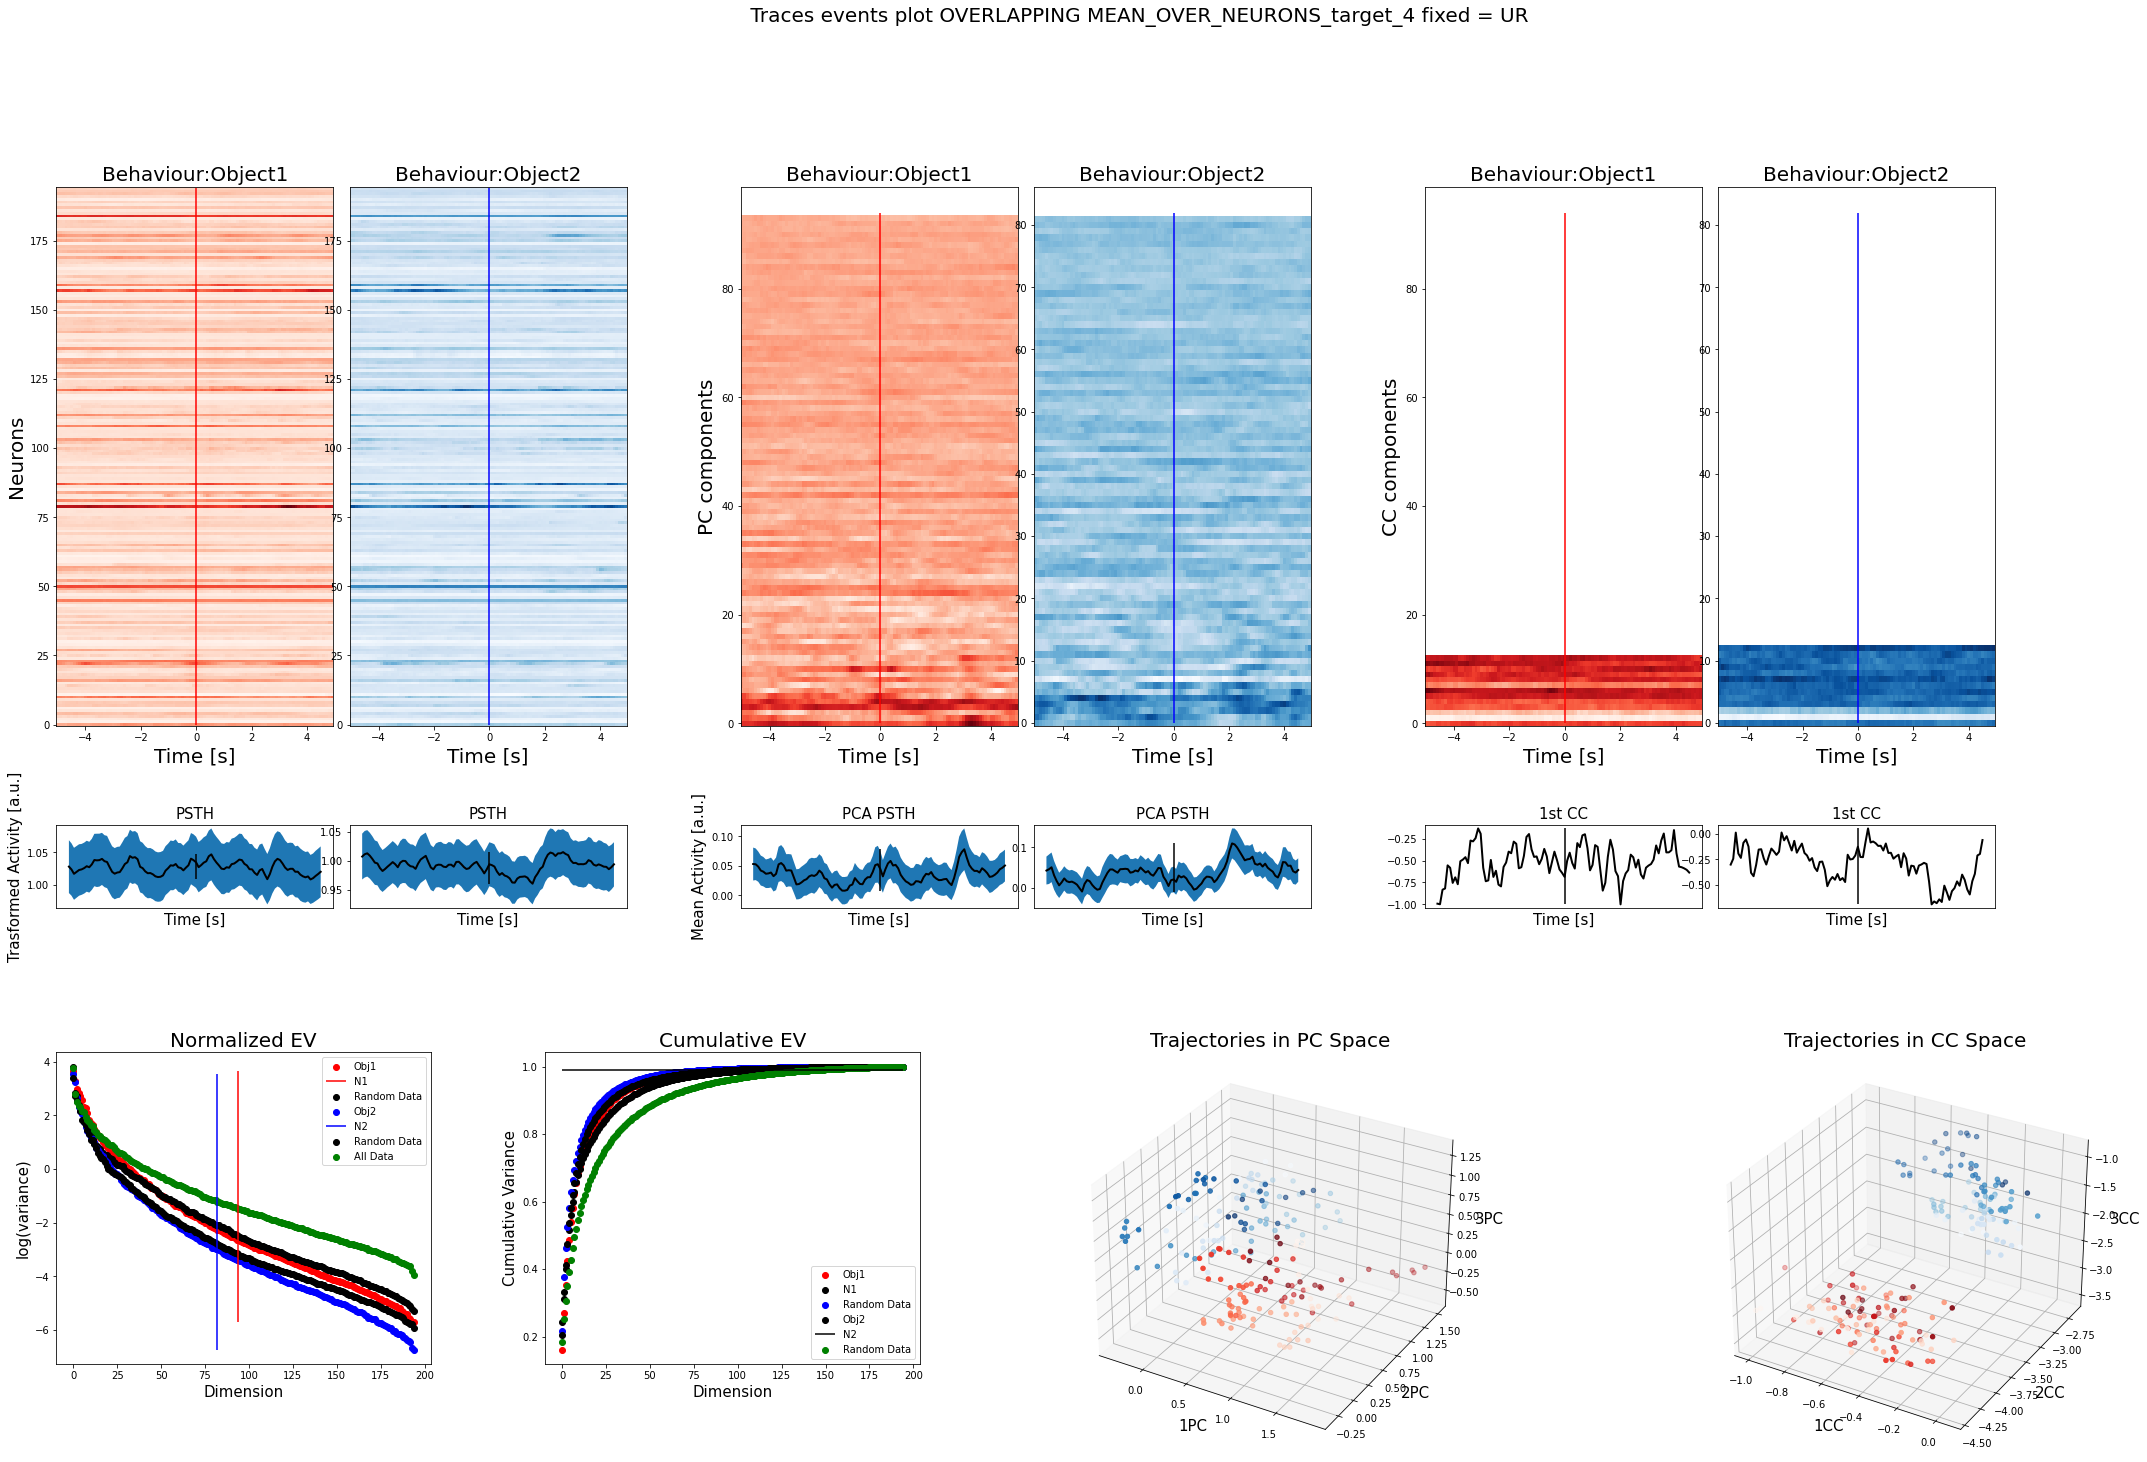

In [28]:
    ### Select a cell
    behaviour = ['Object1','Object2']

    figure = plt.figure()
    gs = plt.GridSpec(30, 23)

    color_code = ['Reds','Blues']
    color_code_pop = ['r','b']
    j=0
    CAPTURED_VARIANCE= 0.99
    
    ### definition of subplots that have plots from different exploratory behaviour
    #axes_pop_vector = figure.add_subplot(gs[17:19,3:9])
    axes_pca_variance = figure.add_subplot(gs[19:26,0:4])
    axes_pca_cum_variance = figure.add_subplot(gs[19:26,5:9])

    #axes_1pc = figure.add_subplot(gs[17:19,10:16])
    
    axes_pc_trajectory = figure.add_subplot(gs[19:28,9:16],projection = '3d')
    axes_pc_trajectory.set_title('Trajectories in PC Space', fontsize = 20)
    axes_pc_trajectory.set_xlabel('1PC',fontsize = 15)
    axes_pc_trajectory.set_ylabel('2PC',fontsize = 15)
    axes_pc_trajectory.set_zlabel('3PC',fontsize = 15)

    axes_cc_trajectory = figure.add_subplot(gs[19:28,16:22],projection = '3d')
    axes_cc_trajectory.set_title('Trajectories in CC Space', fontsize = 20)
    axes_cc_trajectory.set_xlabel('1CC',fontsize = 15)
    axes_cc_trajectory.set_ylabel('2CC',fontsize = 15)
    axes_cc_trajectory.set_zlabel('3CC',fontsize = 15)
    
    pop_vector_distance = []
    pop_vect_list = []
    mean_pop_vector_list = []

    for target in selection_target:
        
        ### subplots for mean activity 
        axes = figure.add_subplot(gs[0:12, 3*j:3*j+3])
        axes_pca_space = figure.add_subplot(gs[0:12, 3*j+7:3*j+10])
        axes_cca_space = figure.add_subplot(gs[0:12, 3*j+14:3*j+17])

        
        trial_activity = np.zeros((events_activity[day][target][0].shape[0],events_activity[day][target][0].shape[1]))
        trial_activity_complete = np.zeros((events_activity[day][target][0].shape[0],len(events_activity[day][target])*10+1))
        trial_activity_all_data = np.zeros((events_activity[day][target][0].shape[0],len(events_activity[day][target])*2*period+1))
        trial_activity_pca = np.zeros((events_activity[day][target][0].shape[0],events_activity[day][target][0].shape[1]))
        trial_activity_cca = np.zeros((cca_components,events_activity[day][target][0].shape[1]))
       
        ### generate matrix with mean activity and entire trial repetitions activity
        for neuron in range(events_activity[day][target][0].shape[0]):
            neuron_trial_activity = np.zeros((events_activity[day][target][0].shape[1],))
            component_trial_activity = np.zeros((events_activity[day][target][0].shape[1],))
            cca_trial_activity = np.zeros((events_activity[day][target][0].shape[1],))
            init = 0
            init2=0
            for trial in range(len(events_activity[day][target])):
                neuron_trial_activity += events_activity[day][target][trial][neuron,:]#/(np.max(events_activity[day][target][trial][neuron,:])-np.min(events_activity[day][target][trial][neuron,:]))
                component_trial_activity +=events_activity_pca[day][target][trial][neuron,:]
                if neuron < cca_components:
                    cca_trial_activity +=events_activity_cca[day][target][trial][neuron,:]
                trial_activity_all_data[neuron,init2:init2+2*period]= events_activity[day][target][trial][neuron,:]
                trial_activity_complete[neuron,init:init+10] = events_activity[day][target][trial][neuron,period:period+10]
                init = init+10
                init2=init2+2*period
            neuron_trial_activity = neuron_trial_activity / len(events_activity[day][target])
            component_trial_activity = component_trial_activity / len(events_activity[day][target])
            trial_activity[neuron,:] = neuron_trial_activity
            trial_activity_pca[neuron,:] = component_trial_activity
            if neuron < cca_components:
                trial_activity_cca[neuron,:] = cca_trial_activity / cca_components
        
        random_events_matrix = np.zeros((events_activity[day][target][0].shape[0],len(events_activity[day][target])*20+1))
        init3 = 0
        for trial in range(len(events_activity[day][target])):
            possible_positions = np.where(behaviour_list[day]>0)[0]
            random_position = np.random.choice(possible_positions[np.logical_and(possible_positions>period,possible_positions<behaviour_list[day].shape[0]-period)])
            random_events_matrix[:,init3:init3+20] = activity_list[day][:,random_position-10:random_position+10]
            init3=init3+20
       
        if j == 0:
            max_position = np.argmax(trial_activity[:,period:period+10],axis = 1)
            firing_order = np.argsort(max_position)
        C_0 = trial_activity.copy()
        C_0 = C_0[firing_order,:]
        trial_activity_complete = trial_activity_complete[firing_order,:]

        mean_pop_vector1 = np.mean(trial_activity,axis =1)
        mean_pop_vector_list.append(mean_pop_vector1)
        mean_pop_vector += mean_pop_vector1
        
        time_axis = np.arange(-period,period)/10
        neurons_axis = np.arange(0,C_0.shape[0])        
        mesh = axes.pcolormesh(time_axis,neurons_axis, C_0, cmap=color_code[j],shading='auto')
        axes.set_xlabel('Time [s]',fontsize = 20)
        axes.set_xlabel('Time [s]', fontsize = 20)
        if j==0:
            axes.set_ylabel('Neurons', fontsize = 20)
        axes.set_title('Behaviour:' + behaviour[j], fontsize = 20)
        axes.vlines(0,0, neuron, color = color_code_pop[j])
        
        axes_1 = figure.add_subplot(gs[14:16,3*j:3*j+3])
        pstd = np.mean(trial_activity,axis = 0)
        pstd_std_error = np.std(trial_activity,axis = 0)/np.sqrt(trial_activity.shape[0])
        uperbound = pstd + pstd_std_error
        lowerbound = pstd - pstd_std_error
        axes_1.plot(time_axis, pstd,'k', linewidth = 2)
        axes_1.fill_between(time_axis , lowerbound , uperbound)#, edgecolor=color[i], facecolor = color[i])
        axes_1.set_title('PSTH', fontsize = 15)
        axes_1.vlines(0,min(pstd), max(pstd),color = 'k',linestyle = '-')
        if j==0:
            axes_1.set_ylabel('Mean Activity [a.u.]',fontsize = 15)
        axes_1.set_xticks([])
        axes_1.set_xlabel('Time [s]',fontsize = 15)

        pca.fit(trial_activity_complete.T)
        variance = pca.explained_variance_ / (1 + np.sqrt(trial_activity_complete.shape[0]/trial_activity_complete.shape[1]))
        cum_variance = np.cumsum(variance / sum(variance))
        axes_pca_variance.scatter(np.arange(0,neuron+1),np.log(variance),color = color_code_pop[j])
        axes_pca_cum_variance.scatter(np.arange(0,neuron+1),cum_variance,color = color_code_pop[j])
        number_of_componentes = np.where(cum_variance > CAPTURED_VARIANCE)[0][0]
        axes_pca_variance.vlines(number_of_componentes,min(np.log(variance)),max(np.log(variance)),color = color_code_pop[j],linestyle = '-')

        axes_pca_space.axes.pcolormesh(time_axis,neurons_axis[0:number_of_componentes], trial_activity_pca[0:number_of_componentes,:], cmap=color_code[j],shading='auto')
        axes_pca_space.set_xlabel('Time [s]',fontsize = 20)
    
        axes_cca_space.axes.pcolormesh(time_axis,neurons_axis[0:cca_components], trial_activity_cca, cmap=color_code[j],shading='auto')
        axes_cca_space.set_xlabel('Time [s]',fontsize = 20)
    
        color = np.linspace(0, 20, 2*period)
        axes_pc_trajectory.scatter(trial_activity_pca[0,:],trial_activity_pca[1,:],trial_activity_pca[2,:], c = color, cmap = color_code[j])
        axes_cc_trajectory.scatter(trial_activity_cca[0,:],trial_activity_cca[1,:],trial_activity_cca[2,:], c = color, cmap = color_code[j])
        
        
        #axes.set_yticks()
        axes_pca_space.set_xlabel('Time [s]', fontsize = 20)
        if j==0:
            axes_pca_space.set_ylabel('PC components', fontsize = 20)
        axes_pca_space.set_title('Behaviour:' + behaviour[j], fontsize = 20)
        axes_pca_space.vlines(0,0, number_of_componentes, color = color_code_pop[j])
        
        #axes.set_yticks()
        axes_cca_space.set_xlabel('Time [s]', fontsize = 20)
        if j==0:
            axes_cca_space.set_ylabel('CC components', fontsize = 20)
        axes_cca_space.set_title('Behaviour:' + behaviour[j], fontsize = 20)
        axes_cca_space.vlines(0,0, number_of_componentes, color = color_code_pop[j])
        
#         axes_1pc.plot(np.arange(0,neuron+1),pca.components_[0,:],color=color_code_pop[j])
#         axes_1pc.set_title('1st PC',fontsize = 20)
#         axes_1pc.set_xlabel('Neurons', fontsize = 15)
#         axes_1pc.set_ylabel('a.u.', fontsize = 15)
        
        axes_2 = figure.add_subplot(gs[14:16,3*j+7:3*j+10])
        pstd = np.mean(trial_activity_pca[0:number_of_componentes,:],axis = 0)
        pstd_std_error = np.std(trial_activity_pca[0:number_of_componentes,:],axis = 0)/np.sqrt(number_of_componentes)
        uperbound = pstd + pstd_std_error
        lowerbound = pstd - pstd_std_error
        axes_2.plot(time_axis, pstd,'k', linewidth = 2)
        axes_2.fill_between(time_axis , lowerbound , uperbound)#, edgecolor=color[i], facecolor = color[i])
        axes_2.set_title('PCA PSTH', fontsize = 15)
        axes_2.vlines(0,min(pstd), max(pstd),color = 'k',linestyle = '-')
        if j==0:
            axes_2.set_ylabel('Mean Activity [a.u.]',fontsize = 15)
        axes_2.set_xticks([])
        axes_2.set_xlabel('Time [s]',fontsize = 15)
        
        axes_3 = figure.add_subplot(gs[14:16,3*j+14:3*j+17])
        pstd = trial_activity_cca[0,:]
        #pstd_std_error = np.std(trial_activity,axis = 0)/np.sqrt(trial_activity.shape[0])
        #uperbound = pstd + pstd_std_error
        #lowerbound = pstd - pstd_std_error
        axes_3.plot(time_axis, pstd,'k', linewidth = 2)
        #axes_1.fill_between(time_axis , lowerbound , uperbound)#, edgecolor=color[i], facecolor = color[i])
        axes_3.set_title('1st CC', fontsize = 15)
        axes_3.vlines(0,min(pstd), max(pstd),color = 'k',linestyle = '-')
        if j==0:
            axes_1.set_ylabel('Trasformed Activity [a.u.]',fontsize = 15)
        axes_3.set_xticks([])
        axes_3.set_xlabel('Time [s]',fontsize = 15)
        
        #pca.fit(trial_activity_all_data.T)
        #variance = pca.explained_variance_ / (1 + np.sqrt(trial_activity_all_data.shape[0]/trial_activity_all_data.shape[1]))**2
        #cum_variance = np.cumsum(variance / sum(variance))
        #axes_pca_variance.scatter(np.arange(0,neuron+1),np.log(variance),color = 'k')
        #axes_1pc.plot(np.arange(0,neuron+1),pca.components_[0,:],color='k')
        #axes_pca_cum_variance.scatter(np.arange(0,neuron+1),cum_variance,color = 'k')

        pca.fit(random_events_matrix.T)
        variance = pca.explained_variance_ / (1 + np.sqrt(random_events_matrix.shape[0]/random_events_matrix.shape[1]))**2
        cum_variance = np.cumsum(variance / sum(variance))
        axes_pca_variance.scatter(np.arange(0,neuron+1),np.log(variance),color = 'k')
        #axes_1pc.plot(np.arange(0,neuron+1),pca.components_[0,:],color='k')
        axes_pca_cum_variance.scatter(np.arange(0,neuron+1),cum_variance,color = 'k')
        
           
        j=j+1
    
    axes_pca_cum_variance.hlines(CAPTURED_VARIANCE,0,neuron,color = 'k' ,linestyle = '-')

#     axes_1pc.legend(['Obj1','Obj2'], fontsize = 15)
#     axes_1pc.set_ylim([-1,1])

    axes_pca_variance.scatter(np.arange(0,neuron+1),np.log(variance_list[day]),color = 'g')
    axes_pca_variance.legend(['Obj1','N1','Random Data','Obj2','N2','Random Data', 'All Data'])
    axes_pca_variance.set_title('Normalized EV', fontsize = 20)
    axes_pca_variance.set_ylabel('log(variance)',fontsize = 15)
    axes_pca_variance.set_xlabel('Dimension',fontsize = 15)
    
    axes_pca_cum_variance.scatter(np.arange(0,neuron+1),variance_ratio_list[day],color = 'g')
    axes_pca_cum_variance.legend(['Obj1','N1','Random Data','Obj2','N2','Random Data', 'All Data'])
    axes_pca_cum_variance.set_title('Cumulative EV', fontsize = 20)
    axes_pca_cum_variance.set_ylabel('Cumulative Variance',fontsize = 15)
    axes_pca_cum_variance.set_xlabel('Dimension',fontsize = 15)
    
    figure.set_size_inches([40., 25])

    figure.suptitle(' Traces events plot ' + task +' MEAN_OVER_NEURONS_target_'+f'{target}'+ ' fixed = ' + fixed   , fontsize = 20)
    figure_name = figure_path + 'traces_events_target_'+f'{target}'+'_'+f'{mouse}'+'_session_'+f'{session}'+\
                                 '_day_'+f'{day}'+'_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'
    figure.savefig(figure_name)
    #plt.close()
    
    

In [ ]:
        
    ###spatial prediction 
    figure = plt.figure()
    gs = plt.GridSpec(20, 15)
    objects_positions = ['LL','LR','UR','UL']
    
    from sklearn.model_selection import train_test_split
    from sklearn.naive_bayes import GaussianNB

    FR_limit = 12

    index = speed_selection(tracking_list[day], speed_limit = 3)
    tracking = tracking_list[day][:,index]
    ypre = np.array(binned_tracking(tracking = tracking, binnumber = BINS )).T

    binsx = ypre[:,0]
    binsy = ypre[:,1]

    Xpre = activity_list[day].T
    Xpre = Xpre[np.where(np.logical_and(ypre[:,0]>=0,ypre[:,1]>=0))[0],:]
    firing_rate = np.mean(Xpre,axis = 0)*10
    selected_cells = np.where(firing_rate < FR_limit)[0]
    X = Xpre[:,selected_cells]

    y = [binsx[i]*BINS + binsy[i] for i in range(len(binsx))]

    X_train, X_test, y_train, y_test = train_test_split(X[0:len(y)], y, test_size=0.1, random_state=0)

    gnb = GaussianNB()
    y_pred = gnb.fit(X_train, y_train).predict(X_test)
    
    y_pred_x = [(int(y_pred[i]/BINS)*100/BINS) for i in range(len(y_pred))]
    y_pred_y = [(y_pred[i]%BINS*100/BINS) for i in range(len(y_pred))]

    y_test_x = [int(y_test[i]/BINS*100/BINS) for i in range(len(y_test))]
    y_test_y = [y_test[i]%BINS*100/BINS for i in range(len(y_test))]

    x_dist = np.array([ y_pred_x[i] - y_test_x[i] for i in range(len(y_pred_x))])
    y_dist = np.array([ y_pred_y[i] - y_test_y[i] for i in range(len(y_pred_x))])

    distance = np.sqrt((x_dist)*(x_dist)+(y_dist)*(y_dist))
    axes_pos_prediction = figure.add_subplot(gs[0:5, 1:5])
    
    axes_pos_prediction.plot(ypre[:,0]*100/BINS,ypre[:,1]*100/BINS,'k')
    axes_pos_prediction.scatter(y_pred_x,y_pred_y,s = 50,color = 'g')
    axes_pos_prediction.set_xlim([0,100])
    axes_pos_prediction.set_ylim([0,100])
    axes_pos_prediction.set_xlabel('X [cm]')
    axes_pos_prediction.set_ylabel('Y [cm]')
    axes_pos_prediction.set_title('GNB position', fontsize = 20)
    
    axes_pos_prediction_distance = figure.add_subplot(gs[7:9, 2:4])
    axes_pos_prediction_distance = sns.boxplot(data = distance, orient = 'v')
    axes_pos_prediction_distance.set_xticklabels(['SpatialDistance'])
    axes_pos_prediction_distance.set_xlabel('Distance to prediction', fontsize = 15)
    axes_pos_prediction_distance.set_ylabel('Distance (cm)', fontsize = 15)      
    axes_pos_prediction_distance.set_title('Distance Prediction', fontsize = 20)
    
    ############################################################
    ###canonical correlations analysis
    dim = 2
    kfold_number = 10
    kf = KFold(n_splits=kfold_number)

    ### prepare neural data
    Xpre_all = activity_list[day].T
    ### select non interneurons cells
    firing_rate = np.mean(Xpre_all,axis = 0)*10
    selected_cells = np.where(firing_rate < FR_limit)[0]
    Xpre_all = Xpre_all[:,selected_cells]
    
    ### select in track part of experiment where there is exploration
    index_track = np.logical_and(behaviour_list[day]>2,behaviour_list[day]<5)
    ybehaviour = behaviour_list[day][index_track]
    yparameters = parameters_list[day][:,index_track]
    Xpre_day = Xpre_all[index_track,:]
    # selected_temporal_bins for preserving class balance (here classes are not balanced)
    selected_temporal_bins = np.arange(0,Xpre_day.shape[0])
    X_day = Xpre_day[selected_temporal_bins,:]
    ybehaviour_day = ybehaviour[selected_temporal_bins]
    yparameters_day = yparameters[:,selected_temporal_bins]
    
    cca_components = min(13,X_day.shape[1])
    cca = CCA(n_components=cca_components)

    X = cca.fit(X_day, yparameters_day.T).transform(X_day)
    axes_cca = figure.add_subplot(gs[0:5,6:10],projection='3d')
    for j in range(3,5):
        exploration = np.where(ybehaviour_day == j)[0]
        axes_cca.scatter(X[exploration,0],X[exploration,1],X[exploration,2],c=color_code_pop[j-3])
    axes_cca.set_title('CCA projections',fontsize = 20)
    axes_cca.legend(['Object 1', 'Object 2'])
       
    
    ### select in track part of experiment where there is exploration
    index_track = np.logical_and(behaviour_list_copy[day]>2,behaviour_list_copy[day]<7)
    ybehaviour = behaviour_list_copy[day][index_track]
    yparameters = parameters_list[day][:,index_track]
    Xpre_day = Xpre_all[index_track,:]
    # selected_temporal_bins for preserving class balance (here classes are not balanced)
    selected_temporal_bins = np.arange(0,Xpre_day.shape[0])
    X_day = Xpre_day[selected_temporal_bins,:]
    ybehaviour_day = ybehaviour[selected_temporal_bins]
    yparameters_day = yparameters[:,selected_temporal_bins]
    
    X = cca.fit(X_day, yparameters_day.T).transform(X_day)
    axes_cca = figure.add_subplot(gs[0:5,11:15],projection='3d')
    color_cca = ['g','orange','cyan','yellow']
    for j in range(3,7):
        exploration = np.where(ybehaviour_day == j)[0]
        axes_cca.scatter(X[exploration,0],X[exploration,1],X[exploration,2],c=color_cca[j-3])
    axes_cca.set_title('CCA projections',fontsize = 20)
       
    ### train a decoder in the cca + gnb
    i= 0
    scores = np.zeros((10,))
    for train_index, test_index in kf.split(X_day):
        X_train_cca, X_test_cca = X_day[train_index], X_day[test_index]
        y_train_cca, y_test_cca = yparameters_day[:,train_index], yparameters_day[:,test_index]
        y_train_gnb, y_test_gnb = ybehaviour_day[train_index], ybehaviour_day[test_index]

        X_cca_train = cca.fit(X_train_cca, y_train_cca.T).transform(X_train_cca)
        X_cca_test = cca.fit(X_train_cca, y_train_cca.T).transform(X_test_cca)
        #y_pred = gnb.fit(X_cca_train, y_train_gnb).predict(X_cca_test)
        #conf_cca = confusion_matrix(y_test_gnb,y_pred)
        scores[i] = gnb.fit(X_cca_train, y_train_gnb).score(X_cca_test, y_test_gnb)
        i = i+1

    ### do the same in shuffling data
    block = 5
    size = np.floor(X_day.shape[0]/block).astype(int)
    order = np.random.permutation(np.arange(0,size*block).reshape(size,block)).reshape(size*block,)
    X_day_shuffle = np.random.permutation(X_day)
    X_day_shuffle[0:size*block,:] = X_day[order,:]
    i= 0
    scores_shuffle = np.zeros((10,))
    for train_index, test_index in kf.split(X_day_shuffle):
        X_train_cca, X_test_cca = X_day_shuffle[train_index], X_day_shuffle[test_index]
        y_train_cca, y_test_cca = yparameters_day[:,train_index], yparameters_day[:,test_index]
        y_train_gnb, y_test_gnb = ybehaviour_day[train_index], ybehaviour_day[test_index]

        X_cca_train = cca.fit(X_train_cca, y_train_cca.T).transform(X_train_cca)
        X_cca_test = cca.fit(X_train_cca, y_train_cca.T).transform(X_test_cca)
        #y_pred = gnb.fit(X_cca_train, y_train_gnb).predict(X_cca_test)
        #conf_cca = confusion_matrix(y_test_gnb,y_pred)
        scores_shuffle[i] = gnb.fit(X_cca_train, y_train_gnb).score(X_cca_test, y_test_gnb)
        i = i+1
    
    plot_list = []
    plot_list.append(scores)
    plot_list.append(scores_shuffle)    
    axes_cca_gnb = figure.add_subplot(gs[6:9,7:10])
    label = ['DayData', 'ShuffleData', ]
    axes_cca_gnb = sns.boxplot(data = plot_list, orient = 'v')
    axes_cca_gnb  = sns.swarmplot(data=plot_list, color=".25")
    #axes_cca_gnb.bar([])
    axes_cca_gnb.set_xticklabels(label)
    axes_cca_gnb.set_xlabel('Data set', fontsize = 15)
    axes_cca_gnb.set_ylabel('Performace', fontsize = 15)
    axes_cca_gnb.set_title('CCA+GNB Classifier', fontsize = 20)
    axes_cca_gnb.set_ylim([0,1])
    axes_cca_gnb.hlines(1/2, -10, 21, colors='k', linestyles='--') 


        
    ### train a decoder in the cca + gnb
    i= 0
    scores = np.zeros((10,))
    for train_index, test_index in kf.split(X_day):
        X_train_cca, X_test_cca = X_day[train_index], X_day[test_index]
        y_train_cca, y_test_cca = yparameters_day[:,train_index], yparameters_day[:,test_index]
        y_train_gnb, y_test_gnb = ybehaviour_day[train_index], ybehaviour_day[test_index]

        X_cca_train = cca.fit(X_train_cca, y_train_cca.T).transform(X_train_cca)
        X_cca_test = cca.fit(X_train_cca, y_train_cca.T).transform(X_test_cca)
        #y_pred = gnb.fit(X_cca_train, y_train_gnb).predict(X_cca_test)
        #conf_cca = confusion_matrix(y_test_gnb,y_pred)
        scores[i] = gnb.fit(X_cca_train, y_train_gnb).score(X_cca_test, y_test_gnb)
        i = i+1

    ### do the same in shuffling data
    block = 5
    size = np.floor(X_day.shape[0]/block).astype(int)
    order = np.random.permutation(np.arange(0,size*block).reshape(size,block)).reshape(size*block,)
    X_day_shuffle = np.random.permutation(X_day)
    X_day_shuffle[0:size*block,:] = X_day[order,:]
    i= 0
    scores_shuffle = np.zeros((10,))
    for train_index, test_index in kf.split(X_day_shuffle):
        X_train_cca, X_test_cca = X_day_shuffle[train_index], X_day_shuffle[test_index]
        y_train_cca, y_test_cca = yparameters_day[:,train_index], yparameters_day[:,test_index]
        y_train_gnb, y_test_gnb = ybehaviour_day[train_index], ybehaviour_day[test_index]

        X_cca_train = cca.fit(X_train_cca, y_train_cca.T).transform(X_train_cca)
        X_cca_test = cca.fit(X_train_cca, y_train_cca.T).transform(X_test_cca)
        #y_pred = gnb.fit(X_cca_train, y_train_gnb).predict(X_cca_test)
        #conf_cca = confusion_matrix(y_test_gnb,y_pred)
        scores_shuffle[i] = gnb.fit(X_cca_train, y_train_gnb).score(X_cca_test, y_test_gnb)
        i = i+1
    
    plot_list = []
    plot_list.append(scores)
    plot_list.append(scores_shuffle)    
    axes_cca_gnb = figure.add_subplot(gs[6:10,6:10])
    label = ['DayData', 'ShuffleData', ]
    axes_cca_gnb = sns.boxplot(data = plot_list, orient = 'v')
    axes_cca_gnb  = sns.swarmplot(data=plot_list, color=".25")
    #axes_cca_gnb.bar([])
    axes_cca_gnb.set_xticklabels(label)
    axes_cca_gnb.set_xlabel('Data set', fontsize = 15)
    axes_cca_gnb.set_ylabel('Performace', fontsize = 15)
    axes_cca_gnb.set_title('CCA+GNB Classifier', fontsize = 20)
    axes_cca_gnb.set_ylim([0,1])
    axes_cca_gnb.hlines(1/2, -10, 21, colors='k', linestyles='--') 


    ###training and testing in different trials
    cca_training_list = []
    cca_gnb_training_list = []
    testing_input_list = []
    testing_output_list = []


    cca_training_list_shuffle = []
    cca_gnb_training_list_shuffle = []
    testing_input_list_shuffle = []
    testing_output_list_shuffle = []

    ##trial to trail train and test decoder
    Xpreall = activity_list[day].T
    firing_rate = np.mean(Xpreall,axis = 0)*10
    selected_cells = np.where(firing_rate < FR_limit)[0]
    Xpreall = Xpreall[:,selected_cells]
    X_resting = []
    
    for trial in range(5):
        
        print('Trial = ' + f'{day*5+trial+1}')
        time0 = int(timeline_list[day][trial*2])
        time1 = int(timeline_list[day][trial*2+1])
        time2 = int(timeline_list[day][trial*2+1]) + 2500

        Xpre = Xpreall[time0:time1,:]     
        tracking_trial = tracking_list[day][:,time0:time1]
        behaviour_trial = behaviour_list[day][time0:time1]
        parameters_trial = parameters_list[day][:,time0:time1]
        index_track = np.logical_and(behaviour_trial>2,behaviour_trial<5)
        X_resting.append(Xpreall[time1:time2,:])
        
        #define list to save classifier for each kfold iteration
        cca_training = []
        gnb_cca_training = []
          
        test_input_kfold = []
        test_output_kfold = []
        
        #define list to save classifier for each kfold iteration
        cca_training_shuffle = []
        gnb_cca_training_shuffle = []
          
        test_input_kfold_shuffle = []
        test_output_kfold_shuffle = []
          
        if index_track.shape[0] > 0:
            
            ybehaviour= behaviour_trial[index_track]
            yparameters = parameters_trial[:,index_track]

            Xpre = Xpre[index_track,:]     
            selected_temporal_bins = np.arange(0,Xpre.shape[0])
            X = Xpre[selected_temporal_bins,:]

            ybehaviour = ybehaviour[selected_temporal_bins]
            yparameters = yparameters[:,selected_temporal_bins]
          
            #select training and testing datasets
            for train_index, test_index in kf.split(X):
                X_train, X_test= X[train_index], X[test_index]
                y_train_params, y_test_params = yparameters[:,train_index], yparameters[:,test_index]
                y_train, y_test = ybehaviour[train_index], ybehaviour[test_index]
                
                #save testing data for this kfold
                test_input_kfold.append(X_test)
                test_output_kfold.append(y_test)
                        
                #train cca+classifier
                cca_training.append(CCA(n_components = cca_components).fit(X_train, y_train_params.T))   
                gnb_cca_training.append(GaussianNB().fit(CCA(n_components = cca_components).fit(X_train, y_train_params.T).transform(X_train),y_train))
        
            #select training and testing datasets
            size = np.floor(X.shape[0]/block).astype(int)
            order = np.random.permutation(np.arange(0,size*block).reshape(size,block)).reshape(size*block,)
            Xshuffle = Xpre
            Xshuffle[0:size*block,:] = Xshuffle[order,:]
            
            for train_index, test_index in kf.split(Xshuffle):
                X_train, X_test= Xshuffle[train_index], Xshuffle[test_index]
                y_train_params, y_test_params = yparameters[:,train_index], yparameters[:,test_index]
                y_train, y_test = ybehaviour[train_index], ybehaviour[test_index]
                
                #save testing data for this kfold
                test_input_kfold_shuffle.append(X_test)
                test_output_kfold_shuffle.append(y_test)
                        
                #train cca+classifier
                cca_training_shuffle.append(CCA(n_components = cca_components).fit(X_train, y_train_params.T))   
                gnb_cca_training_shuffle.append(GaussianNB().fit(CCA(n_components = cca_components).fit(X_train, y_train_params.T).transform(X_train),y_train))
        
        cca_training_list.append(cca_training)
        cca_gnb_training_list.append(gnb_cca_training)
        
        testing_output_list.append(test_output_kfold)
        testing_input_list.append(test_input_kfold)
        
        cca_training_list_shuffle.append(cca_training_shuffle)
        cca_gnb_training_list_shuffle.append(gnb_cca_training_shuffle)
        
        testing_output_list_shuffle.append(test_output_kfold_shuffle)
        testing_input_list_shuffle.append(test_input_kfold_shuffle)
    
    score_matrix_gnb_cca_list = []
    score_matrix_gnb_cca_list_shuffle = []

    score_matrix_gnb_cca = np.zeros((5,5))
    score_matrix_gnb_cca_shuffle = np.zeros((5,5))

    counter = np.zeros((5,5))
    for trial_train in range(5):
        i = trial_train
        if len(cca_training_list[i]):
            for trial_test in range(5):
                j = trial_test 
                if len(cca_training_list[j]):
                    for k in range(kfold_number):
                        for l in range(kfold_number):
                            if trial_train != trial_test or (trial_train == trial_test and k!=l):

                                counter[trial_train,trial_test ]+=1
                                ##score gnb+cca

                                data_transformation = cca_training_list[i][k].transform(testing_input_list[j][l])
                                classifier = cca_gnb_training_list[i][k]
                                score_gnb_cca = classifier.score(data_transformation,testing_output_list[j][l])

                                score_matrix_gnb_cca[trial_train,trial_test ]+= score_gnb_cca

                                ## shuffling
                                data_transformation = cca_training_list_shuffle[i][k].transform(testing_input_list_shuffle[j][l])
                                classifier = cca_gnb_training_list_shuffle[i][k]
                                score_gnb_cca_shuffle = classifier.score(data_transformation,testing_output_list_shuffle[j][l])

                                score_matrix_gnb_cca_shuffle[trial_train,trial_test ]+= score_gnb_cca_shuffle

    score_matrix_gnb_cca_list.append(score_matrix_gnb_cca)
    score_matrix_gnb_cca_list_shuffle.append(score_matrix_gnb_cca_shuffle)
        
    post_trial = []
    pre_trial = []
    same_trial = []

    post_trial_shuffle = []
    pre_trial_shuffle = []
    same_trial_shuffle = []

    matrix = score_matrix_gnb_cca_list[0]/counter 
    matrix_shuffle = score_matrix_gnb_cca_list_shuffle[0]/counter 
    same_trial = matrix.diagonal()
    same_trial_shuffle = matrix_shuffle.diagonal()

    tril = np.tril(matrix,k=-1).flatten()
    tril = tril[tril>0]
    for i in range(tril.shape[0]):
        pre_trial.append(tril[i])

    tril = np.tril(matrix_shuffle,k=-1).flatten()
    tril = tril[tril>0]
    for i in range(tril.shape[0]):
        pre_trial_shuffle.append(tril[i])    

    triu = np.tril(matrix.T,k=-1).flatten()
    triu = triu[triu>0]
    for i in range(tril.shape[0]):
        post_trial.append(triu[i])

    triu = np.tril(matrix_shuffle.T,k=-1).flatten()
    triu = triu[triu>0]
    for i in range(tril.shape[0]):
        post_trial_shuffle.append(triu[i])

    axes_cca_gnb = figure.add_subplot(gs[6:10,11:15])
    plot_list = np.array([same_trial, pre_trial, post_trial])
    plot_list_shuffle = np.array([same_trial_shuffle, pre_trial_shuffle, post_trial_shuffle])

    label = ['Trial Training', 'Pre trial', 'Post trial', ]
    ax= sns.boxplot(data = plot_list, orient = 'v')
    ax = sns.boxplot(data = plot_list_shuffle, orient = 'v',color = '1')
    #ax = sns.swarmplot(data=plot_list, color=".25")
    ax.set_xticklabels(label)
    ax.set_xlabel('Training and testing condition', fontsize = 15)
    ax.set_ylabel('Performace', fontsize = 15)
    ax.set_title('CCA+GNB Exploration in Trial',fontsize = 20)
    ax.set_ylim([0,1])
    ax.hlines(1/2, -1/2, 3, colors='k', linestyles='--') 

    classification_gnb_cca = []
    probability_gnb_cca = []
    for trial_train in range(5):
        i = trial_train
        data_transformation = cca_training_list[i][0].transform(X_resting[i])
        classifier = cca_gnb_training_list[i][0]
        probability_gnb_cca.append(classifier.predict_proba(data_transformation))
        classification_gnb_cca.append(classifier.predict(data_transformation))
    

    for trial in range(5):
        axes_gnb_cca_resting = figure.add_subplot(gs[11+trial*2,0:8])
        for j in range(2):
            if len(probability_gnb_cca[trial]) > 1:
                axes_gnb_cca_resting.plot(probability_gnb_cca[trial][:,j],color = color_code_pop[j], linewidth = 3)
        axes_gnb_cca_resting.set_ylabel('Probability', fontsize = 15)

    axes_gnb_cca_resting.set_xlabel('Resting time [s]', fontsize = 15)
    axes_gnb_cca_resting.set_title('Replay probability of decoding', fontsize = 25)
    
    axes_gnb_cca_resting_mean = figure.add_subplot(gs[12:17,10:14])
    replay = np.zeros((5,2))
    for trial in range(5):
        proportion1 = sum(np.logical_and(classification_gnb_cca[trial]==3,probability_gnb_cca[trial][:,0]>0.95))/classification_gnb_cca[trial].shape[0]
        proportion2 = sum(np.logical_and(classification_gnb_cca[trial]==4,probability_gnb_cca[trial][:,1]>0.95))/classification_gnb_cca[trial].shape[0]
        replay[trial,0] = proportion1
        replay[trial,1] = proportion2
    axes_gnb_cca_resting_mean.bar(np.arange(0,5),replay[:,0], alpha = 0.25, color = 'r')
    axes_gnb_cca_resting_mean.bar(np.arange(0,5),replay[:,1],alpha = 0.25, color = 'b')
    axes_gnb_cca_resting_mean.set_title('Replay proportion', fontsize = 20)
    axes_gnb_cca_resting_mean.set_xlabel('Trial', fontsize = 15)
    axes_gnb_cca_resting_mean.set_ylabel('Proportion', fontsize = 15)
    
    figure.set_size_inches([30, 25])

    figure.suptitle(' Traces events plot ' + task +' MEAN_OVER_NEURONS_target_'+f'{target}'+ ' fixed = ' + fixed   , fontsize = 20)
    figure_name = figure_path + 'traces_events_neuron_'+f'{NEURON}'+'_target_'+f'{target}'+'_'+f'{mouse}'+'_session_'+f'{session}'+\
                                 '_day_'+f'{day}'+'_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'_decoding.png'
    figure.savefig(figure_name)

    

In [ ]:
color_code_pop[j]
    

## Same but by position

## NaiveBayes from SKlearn

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

day = 0
FR_limit = 12

index = speed_selection(tracking_list[day], speed_limit = 3)
tracking = tracking_list[day][:,index]
ypre = np.array(binned_tracking(tracking = tracking, binnumber = BINS )).T

binsx = ypre[:,0]
binsy = ypre[:,1]

print(np.unique(binsy).shape)

Xpre = activity_list[day].T
Xpre = Xpre[np.where(np.logical_and(ypre[:,0]>0,ypre[:,1]>0))[0],:]
firing_rate = np.mean(Xpre,axis = 0)*10
selected_cells = np.where(firing_rate < FR_limit)[0]
X = Xpre[:,selected_cells]
#X = X.astype(int)

y = [binsx[i]*BINS + binsy[i] for i in range(len(binsx))]

print(X.shape)
print(np.unique(y).shape)
print(BINS*BINS)

#### Naive Bayes with Gaussian model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

added_bins = np.arange(0,BINS)
added_pairs = [added_bins[i]*BINS+added_bins[j] for i in range(BINS) for j in range(BINS)]
added_activity = np.zeros((len(added_pairs),X_train.shape[1]))
X_train = np.concatenate((X_train,added_activity))
X_test = np.concatenate((X_test,added_activity))

y_train = y_train + added_pairs
y_test = y_test + added_pairs

gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
y_pred_proba = gnb.fit(X_train, y_train).predict_proba(X_test)

In [ ]:
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

In [ ]:
y_train_x = [int(y_train[i]/BINS) for i in range(len(y_train))]
y_train_y = [y_train[i]%BINS for i in range(len(y_train))]

y_test_x = [int(y_test[i]/BINS) for i in range(len(y_test))]
y_test_y = [y_test[i]%BINS for i in range(len(y_test))]

occupancy_train = occupancy_map(np.array([y_train_x,y_train_y]),binnumber = BINS)
occupancy_train = gaussian_filter(occupancy_train, sigma)

occupancy_test = occupancy_map(np.array([y_test_x,y_test_y]),binnumber = BINS)
occupancy_test = gaussian_filter(occupancy_test, sigma)

In [ ]:
print(y_pred_proba.shape)


t = 100
time_map = np.zeros((BINS,BINS))
for x in range(BINS):
    for y in range(BINS):
        time_map[x,y] = y_pred_proba[t,x*BINS+y]

#time_map = gaussian_filter(time_map, sigma)   
plt.imshow(time_map)


In [ ]:
figure = plt.figure(figsize=(10, 10))
gs = figure.add_gridspec(1, 2)
axes0 = figure.add_subplot(gs[0,0])
axes1 = figure.add_subplot(gs[0,1])

pos0 = axes0.imshow(occupancy_train, cmap = 'jet')
axes0.set_title('Occupancy Train')
figure.colorbar(pos0, ax=axes0)
pos1 = axes1.imshow(occupancy_test, cmap = 'jet')
axes1.set_title('Occupancy Test')
figure.colorbar(pos1, ax=axes1)

In [ ]:
plt.scatter(y_pred,y_test)

In [ ]:
y_pred_x = [int(y_pred[i]/BINS) for i in range(len(y_pred))]
y_pred_y = [y_pred[i]%BINS for i in range(len(y_pred))]

y_test_x = [int(y_test[i]/BINS) for i in range(len(y_test))]
y_test_y = [y_test[i]%BINS for i in range(len(y_test))]

x_dist = np.array([ y_pred_x[i] - y_test_x[i] for i in range(len(y_pred_x))])
y_dist = np.array([ y_pred_y[i] - y_test_y[i] for i in range(len(y_pred_x))])
     
distance = np.sqrt((x_dist)*(x_dist)+(y_dist)*(y_dist))
print('MeanError: ' + str(np.mean(distance)) + ' Std: ' + str(np.std(distance)))
print('MeanErrorProp: ' + str(np.mean(distance)/BINS) + ' PRopStd: ' + str(np.std(distance)/BINS))

In [ ]:
figure , axes = plt.subplots(1,3)
axes[0].plot(ypre[:,0],ypre[:,1])
axes[0].scatter(y_pred_x,y_pred_y,color = 'r')
axes[0].set_xlim([0,BINS])
axes[0].set_ylim([0,BINS])

axes[1].scatter(y_test_x,y_pred_x)

axes[2].scatter(y_test_y,y_pred_y)
figure.set_size_inches(25,5)


In [ ]:
from sklearn.metrics import confusion_matrix
confx = confusion_matrix(y_test_x,y_pred_x)
confy = confusion_matrix(y_test_y,y_pred_y)

In [ ]:
figure = plt.figure(figsize=(10, 10))
gs = figure.add_gridspec(1, 2)
axes0 = figure.add_subplot(gs[0,0])
axes1 = figure.add_subplot(gs[0,1])

#confx = gaussian_filter(confx,sigma)
#confy = gaussian_filter(confy,sigma)

pos0 = axes0.imshow(confx, cmap = 'jet')
axes0.set_title('confusion X')
figure.colorbar(pos0, ax=axes0)
pos1 = axes1.imshow(confy, cmap = 'jet')
axes1.set_title('confusion Y')
figure.colorbar(pos1, ax=axes1)

## Exponential Naive Bayes

In [ ]:
### TO BE CONSTRUCTED

## Gaussian Naive Bayes for trial to trial decoding

In [ ]:
activity_list[day].shape

In [ ]:
day = 0
FR_limit = 10

X = []
y = []
X_shuffle = []
ypre_list = []
for day in range(4):
    for trial in range(5):
        time0 = int(timeline_list[day][trial*2])
        time1 = int(timeline_list[day][trial*2+1])

        tracking_trial = tracking_list[day][:,time0:time1]
        index = speed_selection(tracking_trial, speed_limit = 3)

        tracking = tracking_trial[:,index]
        ypre = np.array(binned_tracking(tracking = tracking, binnumber = BINS )).T
        ypre_list.append(ypre)
        binsx = ypre[np.where(np.logical_and(ypre[:,0]>0,ypre[:,1]>0))[0],0]
        binsy = ypre[np.where(np.logical_and(ypre[:,0]>0,ypre[:,1]>0))[0],1]

        Xpre = activity_list[day][:,time0:time1].T
        Xpre = Xpre[np.where(np.logical_and(ypre[:,0]>0,ypre[:,1]>0))[0],:]
        firing_rate = np.mean(Xpre,axis = 0)*10
        selected_cells = np.where(firing_rate < FR_limit)[0]
        X_decode = Xpre[:,selected_cells]
        X.append(X_decode.copy())
        np.random.shuffle(X_decode)
        X_shuffle.append(X_decode)
        y.append([binsx[i]*BINS + binsy[i] for i in range(len(binsx))])

In [ ]:
print(type(X_shuffle[0]))
y_test_list = []
y_pred_list = []
y_pred_list_shuffle = []
y_test_list_shuffle = []

for trial in range(5*4): 
    X_train, X_test, y_train, y_test = train_test_split(X[trial], y[trial], test_size=0.1, random_state=0)
    X_train_shuffle , X_test_shuffle , y_train_shuffle, y_test_shuffle = train_test_split(X_shuffle[trial], y[trial], test_size=0.1, random_state=0)
    gnb = GaussianNB()
    y_pred = gnb.fit(X_train, y_train).predict(X_test)
    y_test_list.append(y_test)
    y_pred_list.append(y_pred)
    
    y_pred_shuffle = gnb.fit(X_train_shuffle, y_train_shuffle).predict(X_test_shuffle)
    y_test_list_shuffle.append(y_test_shuffle)
    y_pred_list_shuffle.append(y_pred_shuffle)
    print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

In [ ]:
figure, axes = plt.subplots(1,5)
for trial in range(5):
    axes[trial].scatter(y_test_list[trial],y_pred_list[trial])
figure.set_size_inches(25,5)

In [ ]:
figure , axes = plt.subplots(3,5)

for trial in range(5):
    
    y_pred = y_pred_list[trial]
    y_test = y_test_list[trial]
    
    y_pred_x = [int(y_pred[i]/BINS) for i in range(len(y_pred))]
    y_pred_y = [y_pred[i]%BINS for i in range(len(y_pred))]

    y_test_x = [int(y_test[i]/BINS) for i in range(len(y_test))]
    y_test_y = [y_test[i]%BINS for i in range(len(y_test))]

    x_dist = np.array([ y_pred_x[i] - y_test_x[i] for i in range(len(y_pred_x))])
    y_dist = np.array([ y_pred_y[i] - y_test_y[i] for i in range(len(y_pred_x))])
     
    distance = np.sqrt((x_dist)*(x_dist)+(y_dist)*(y_dist))
    print('MeanError: ' + str(np.mean(distance)) + ' Std: ' + str(np.std(distance)))
    print('MeanErrorProp: ' + str(np.mean(distance)/BINS) + ' PRopStd: ' + str(np.std(distance)/BINS))
    
    axes[0,trial].plot(ypre_list[trial][:,0],ypre_list[trial][:,1])
    axes[0,trial].scatter(y_pred_x,y_pred_y,color = 'r')
    axes[0,trial].set_xlim([0,BINS])
    axes[0,trial].set_ylim([0,BINS])

    axes[1,trial].scatter(y_test_x,y_pred_x)

    axes[2,trial].scatter(y_test_y,y_pred_y)
    figure.set_size_inches(25,10)


In [ ]:
distance_trial = []
distance_trial_shuffle = []

distance_trial_std = []
distance_trial_std_shuffle = []

for trial in range(5*4):
    
    y_pred = y_pred_list[trial]
    y_test = y_test_list[trial]
    
    y_pred_x = [int(y_pred[i]/BINS) for i in range(len(y_pred))]
    y_pred_y = [y_pred[i]%BINS for i in range(len(y_pred))]

    y_test_x = [int(y_test[i]/BINS) for i in range(len(y_test))]
    y_test_y = [y_test[i]%BINS for i in range(len(y_test))]

    x_dist = np.array([ y_pred_x[i] - y_test_x[i] for i in range(len(y_pred_x))])
    y_dist = np.array([ y_pred_y[i] - y_test_y[i] for i in range(len(y_pred_x))])
    distance = np.sqrt((x_dist)*(x_dist)+(y_dist)*(y_dist))
    distance_trial.append(np.mean(distance))
    distance_trial_std.append(np.std(distance))
    
        
    y_pred = y_pred_list_shuffle[trial]
    y_test = y_test_list_shuffle[trial]
    
    y_pred_x = [int(y_pred[i]/BINS) for i in range(len(y_pred))]
    y_pred_y = [y_pred[i]%BINS for i in range(len(y_pred))]

    y_test_x = [int(y_test[i]/BINS) for i in range(len(y_test))]
    y_test_y = [y_test[i]%BINS for i in range(len(y_test))]

    x_dist = np.array([ y_pred_x[i] - y_test_x[i] for i in range(len(y_pred_x))])
    y_dist = np.array([ y_pred_y[i] - y_test_y[i] for i in range(len(y_pred_x))])
    distance = np.sqrt((x_dist)*(x_dist)+(y_dist)*(y_dist))
    distance_trial_shuffle.append(np.mean(distance))
    distance_trial_std_shuffle.append(np.std(distance))
    


In [ ]:
figure, axes = plt.subplots(1)

axes.errorbar(np.arange(1,len(distance_trial)+1),np.array(distance_trial)*100/BINS,np.array(distance_trial_std)*100/BINS)
axes.errorbar(np.arange(1,len(distance_trial_shuffle)+1),np.array(distance_trial_shuffle)*100/BINS,np.array(distance_trial_shuffle)*100/BINS)
axes.legend(['MeanDecodedDistance','MeanDecodedDistance_shuffling'])
axes.set_xlabel('Trial number', fontsize = 15)
axes.set_ylabel('Mean distance [cm]', fontsize = 15)
axes.set_ylim([0,100])

plt.vlines(1, 6, 100, colors='k', linestyles='-')
plt.vlines(6, 6, 100, colors='k', linestyles='-')
plt.vlines(11, 6, 100, colors='k', linestyles='-')
plt.vlines(16, 6, 100, colors='k', linestyles='-')
plt.vlines(21, 6, 100, colors='k', linestyles='-')
plt.hlines((700/BINS)/7, 0, 21, colors='b', linestyles='--') 

figure.suptitle('mouse_' + f'{mouse}' + '_' + task , fontsize = 15)

figure_name = 'position_decoder_naive_bayes_'+'mouse_' + f'{mouse}' + '_' + task +'_BINS_'+f'{BINS}' +'.png'
figure.savefig(figure_path + figure_name)

In [ ]:
print(BINS)